Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!
  
  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 14

In [1]:
%autosave 360

Autosaving every 360 seconds


In [2]:
num_days_R_prediction=14
num_BackTrack_Days=0

In [3]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [4]:
%%R
max_days_prediction<-num_days_R_prediction

In [5]:
bypass_weather=1 # =1 bypass weather_pi api calls
#
number_past_days_training=8 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=50
#
## DROP_N=0   => 22/01
## DROP_N=15  => 06/02
## DROP_N=45  => 08/03
## DROP_N=75  => 07/04
## DROP_N=145 => 08/06
## DROP_N=175 => 15/07
## DROP_N=237 => 15/09/2020
## DROP_N=447 => 13/04/2021
## DROP_N=480 => 16/05/2021
## DROP_N=495 => 31/05/2021
## DROP_N=520 => 25/06/2021
#
drop_n_dataset_days=520
#

### Load Data from Github - John Hopkins Institute 

In [6]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [7]:
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN              Antarctica   
6                                             NaN     Antigua and Barbuda   
7                                             NaN               Argentina   
8                                             NaN                 Armenia   
9                    Australian Capital Territory               Australia   
10                                New South Wales               Australia   
11                             Northern Territory               Australia   
12                                     Queensland               Australia   
13                                South Australia               Australia   
14                                       Tasmania               Australia   
15                                       Victoria               Australia   
16                              Western Australia               Australia   
17                                            NaN                 Austria   
18                                            NaN              Azerbaijan   
19                                            NaN                 Bahamas   
20                                            NaN                 Bahrain   
21                                            NaN              Bangladesh   
22                                            NaN                Barbados   
23                                            NaN                 Belarus   
24                                            NaN                 Belgium   
25                                            NaN                  Belize   
26                                            NaN                   Benin   
27                                            NaN                  Bhutan   
28                                            NaN                 Bolivia   
29                                            NaN  Bosnia and Herzegovina   
..                                            ...                     ...   
254                                           NaN                 Tunisia   
255                                           NaN                  Turkey   
256                                           NaN           United States   
257                                           NaN                  Uganda   
258                                           NaN                 Ukraine   
259                                           NaN    United Arab Emirates   
260                                      Anguilla          United Kingdom   
261                                       Bermuda          United Kingdom   
262                        British Virgin Islands          United Kingdom   
263                                Cayman Islands          United Kingdom   
264                               Channel Islands          United Kingdom   
265                   Falkland Islands (Malvinas)          United Kingdom   
266                                     Gibraltar          United Kingdom   
267                                      Guernsey          United Kingdom   
268                                   Isle of Man          United Kingdom   
269                                        Jersey          United Kingdom   
270                                    Montserrat          United Kingdom   
271  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
272                      Turks and Caicos Islands          United Kingdom   
273                                           NaN          United Kingdom   
274                            

## Get Population

In [8]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [9]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region  \
0                                             NaN             Afghanistan   
1                                             NaN                 Albania   
2                                             NaN                 Algeria   
3                                             NaN                 Andorra   
4                                             NaN                  Angola   
5                                             NaN              Antarctica   
6                                             NaN     Antigua and Barbuda   
7                                             NaN               Argentina   
8                                             NaN                 Armenia   
9                    Australian Capital Territory               Australia   
10                                New South Wales               Australia   
11                             Northern Territory               Australia   
12                                     Queensland               Australia   
13                                South Australia               Australia   
14                                       Tasmania               Australia   
15                                       Victoria               Australia   
16                              Western Australia               Australia   
17                                            NaN                 Austria   
18                                            NaN              Azerbaijan   
19                                            NaN                 Bahamas   
20                                            NaN                 Bahrain   
21                                            NaN              Bangladesh   
22                                            NaN                Barbados   
23                                            NaN                 Belarus   
24                                            NaN                 Belgium   
25                                            NaN                  Belize   
26                                            NaN                   Benin   
27                                            NaN                  Bhutan   
28                                            NaN                 Bolivia   
29                                            NaN  Bosnia and Herzegovina   
..                                            ...                     ...   
260                                           NaN                 Tunisia   
261                                           NaN                  Turkey   
262                                           NaN           United States   
263                                           NaN                  Uganda   
264                                           NaN                 Ukraine   
265                                           NaN    United Arab Emirates   
266                                      Anguilla          United Kingdom   
267                                       Bermuda          United Kingdom   
268                        British Virgin Islands          United Kingdom   
269                                Cayman Islands          United Kingdom   
270                               Channel Islands          United Kingdom   
271                   Falkland Islands (Malvinas)          United Kingdom   
272                                     Gibraltar          United Kingdom   
273                                      Guernsey          United Kingdom   
274                                   Isle of Man          United Kingdom   
275                                        Jersey          United Kingdom   
276                                    Montserrat          United Kingdom   
277  Saint Helena, Ascension and Tristan da Cunha          United Kingdom   
278                      Turks and Caicos Islands          United Kingdom   
279                                           NaN          United Kingdom   
280                            

In [10]:
# merge region death
death.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN              Mali  17.570692   -3.996166        0        0   
186            NaN             Malta  35.937500   14.375400        0        0   
187            NaN  Marshall Islands   7.131500  171.184500        0        0   
188            NaN        Mauritania  21.007900  -10.940800        0        0   
189            NaN         Mauritius -20.348404   57.552152        0        0   
190            NaN            Mexico  23.634500 -102.552800        0        0   
191            NaN        Micronesia   7.425600  150.550800        0        0   
192            NaN           Moldova  47.411600   28.369900        0        0   
193            NaN            Monaco  43.733300    7.416700        0        0   
194            NaN          Mongolia  46.862500  103.846700        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  2/16/22  2/17/22  2/18/22  \
185        0        0        0        0  ...      717      717      717   
186        0        0        0        0  ...      594      594      594   
187        0        0        0        0  ...        0        0        0   
188        0        0        0        0  ...      973      975      976   
189        0        0        0        0  ...      786      786      786   
190        0        0        0        0  ...   314128   314598   314598   
191        0        0        0        0  ...        0        0        0   
192        0        0        0        0  ...    11009    11041    11068   
193        0        0        0        0  ...       50       50       51   
194        0        0        0        0  ...     2152     2152     2157   

     2/19/22  2/20/22  2/21/22  2/22/22  2/23/22   Population   \
185      717      720      720      722      722    20,250,833   
186      594      596      598      599      601       441,543   
187        0        0        0        0        0           NaN   
188      976      976      977      977      977     4,649,658   
189      786      786      786      786      786     1,273,985   
190   315525   315688   315688   315786   316492   128,640,794   
191        0        0        0        0        0           NaN   
192    11093    11104    11117    11136    11157     4,035,942   
193       51       51       51       51       51        39,183   
194     2159     2159     2159     2161     2163     3,278,290   

                   region  
185              Mali_nan  
186             Malta_nan  
187  Marshall Islands_nan  
188        Mauritania_nan  
189         Mauritius_nan  
190            Mexico_nan  
191        Micronesia_nan  
192           Moldova_nan  
193            Monaco_nan  
194          Mongolia_nan  

[10 rows x 770 columns]

In [11]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat       Long  \
175                               NaN        Moldova  47.411600   28.36990   
176                               NaN         Monaco  43.733300    7.41670   
177                               NaN       Mongolia  46.862500  103.84670   
178                               NaN     Montenegro  42.708678   19.37439   
179                               NaN        Morocco  31.791700   -7.09260   
180                               NaN     Mozambique -18.665700   35.52960   
181                               NaN        Namibia -22.957600   18.49040   
182                               NaN          Nepal  28.166700   84.25000   
183                             Aruba    Netherlands  12.521100  -69.96830   
184  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.23850   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  2/16/22  \
175        0        0        0        0        0        0  ...        0   
176        0        0        0        0        0        0  ...        0   
177        0        0        0        0        0        0  ...        0   
178        0        0        0        0        0        0  ...        0   
179        0        0        0        0        0        0  ...        0   
180        0        0        0        0        0        0  ...        0   
181        0        0        0        0        0        0  ...        0   
182        0        0        0        0        0        0  ...        0   
183        0        0        0        0        0        0  ...        0   
184        0        0        0        0        0        0  ...        0   

     2/17/22  2/18/22  2/19/22  2/20/22  2/21/22  2/22/22  2/23/22  \
175        0        0        0        0        0        0        0   
176        0        0        0        0        0        0        0   
177        0        0        0        0        0        0        0   
178        0        0        0        0        0        0        0   
179        0        0        0        0        0        0        0   
180        0        0        0        0        0        0        0   
181        0        0        0        0        0        0        0   
182        0        0        0        0        0        0        0   
183        0        0        0        0        0        0        0   
184        0        0        0        0        0        0        0   

      Population                                         region  
175     4,035,942                                   Moldova_nan  
176        39,183                                    Monaco_nan  
177     3,278,290                                  Mongolia_nan  
178       622 500                                Montenegro_nan  
179    36,817,128                                   Morocco_nan  
180    31,542,919                                Mozambique_nan  
181     2,540,905                                   Namibia_nan  
182    29,300,000                                     Nepal_nan  
183       116,600                             Netherlands_Aruba  
184        26,000  Netherlands_Bonaire, Sint Eustatius and Saba  

[10 rows x 770 columns]

In [12]:
confirmed.iloc[185:195,:]

Province/State    Country/Region        Lat        Long  1/22/20  1/23/20  \
185            NaN              Mali  17.570692   -3.996166        0        0   
186            NaN             Malta  35.937500   14.375400        0        0   
187            NaN  Marshall Islands   7.131500  171.184500        0        0   
188            NaN        Mauritania  21.007900  -10.940800        0        0   
189            NaN         Mauritius -20.348404   57.552152        0        0   
190            NaN            Mexico  23.634500 -102.552800        0        0   
191            NaN        Micronesia   7.425600  150.550800        0        0   
192            NaN           Moldova  47.411600   28.369900        0        0   
193            NaN            Monaco  43.733300    7.416700        0        0   
194            NaN          Mongolia  46.862500  103.846700        0        0   

     1/24/20  1/25/20  1/26/20  1/27/20  ...  2/16/22  2/17/22  2/18/22  \
185        0        0        0        0  ...    30303    30321    30333   
186        0        0        0        0  ...    70328    70437    70516   
187        0        0        0        0  ...        7        7        7   
188        0        0        0        0  ...    58584    58593    58595   
189        0        0        0        0  ...    70862    70862    70862   
190        0        0        0        0  ...  5344840  5366405  5366405   
191        0        0        0        0  ...        1        1        1   
192        0        0        0        0  ...   488899   490751   492604   
193        0        0        0        0  ...     9111     9128     9162   
194        0        0        0        0  ...   891267   893721   893721   

     2/19/22  2/20/22  2/21/22  2/22/22  2/23/22   Population   \
185    30338    30340    30346    30352    30355    20,250,833   
186    70588    70665    70739    70829    70908       441,543   
187        7        7        7        7        7           NaN   
188    58604    58611    58616    58618    58621     4,649,658   
189    70862    70862    70862    70862    70862     1,273,985   
190  5407711  5413425  5413425  5418257  5436566   128,640,794   
191        1        1        1        1        1           NaN   
192   494219   495184   495415   496976   497946     4,035,942   
193     9186     9188     9188     9267     9305        39,183   
194   893721   893721   899002   899706   903150     3,278,290   

                   region  
185              Mali_nan  
186             Malta_nan  
187  Marshall Islands_nan  
188        Mauritania_nan  
189         Mauritius_nan  
190            Mexico_nan  
191        Micronesia_nan  
192           Moldova_nan  
193            Monaco_nan  
194          Mongolia_nan  

[10 rows x 770 columns]

In [13]:
confirmed.iloc[220:230,:]

Province/State                    Country/Region        Lat        Long  \
220            NaN                            Poland  51.919400   19.145100   
221            NaN                          Portugal  39.399900   -8.224500   
222            NaN                             Qatar  25.354800   51.183900   
223            NaN                           Romania  45.943200   24.966800   
224            NaN                            Russia  61.524010  105.318756   
225            NaN                            Rwanda  -1.940300   29.873900   
226            NaN             Saint Kitts and Nevis  17.357822  -62.782998   
227            NaN                       Saint Lucia  13.909400  -60.978900   
228            NaN  Saint Vincent and the Grenadines  12.984300  -61.287200   
229            NaN                             Samoa -13.759000 -172.104600   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...   2/16/22  \
220        0        0        0        0        0        0  ...   5466198   
221        0        0        0        0        0        0  ...   3131899   
222        0        0        0        0        0        0  ...    352447   
223        0        0        0        0        0        0  ...   2613716   
224        0        0        0        0        0        0  ...  14445698   
225        0        0        0        0        0        0  ...    129337   
226        0        0        0        0        0        0  ...      5511   
227        0        0        0        0        0        0  ...     22269   
228        0        0        0        0        0        0  ...      8248   
229        0        0        0        0        0        0  ...        33   

      2/17/22   2/18/22   2/19/22   2/20/22   2/21/22   2/22/22   2/23/22  \
220   5495432   5519411   5540302   5553989   5563446   5582217   5602680   
221   3148387   3163869   3178029   3187389   3193178   3206281   3219439   
222    352894    353346    353780    354222    354638    355032    355397   
223   2629090   2643614   2655933   2663630   2671314   2686089   2697566   
224  14624423  14802439  14979363  15147762  15297628  15430540  15566425   
225    129345    129359    129369    129372    129378    129419    129436   
226      5511      5518      5523      5523      5523      5523      5524   
227     22426     22468     22468     22468     22545     22568     22594   
228      8468      8468      8468      8468      8278      8297      8301   
229        33        33        33        33        33        33        33   

      Population                                 region  
220    37,980,000                            Poland_nan  
221    10,290,000                          Portugal_nan  
222     2,870,256                             Qatar_nan  
223    19,530,000                           Romania_nan  
224   144,500,000                            Russia_nan  
225    12,952,218                            Rwanda_nan  
226        53,673             Saint Kitts and Nevis_nan  
227       184,106                       Saint Lucia_nan  
228       110,940  Saint Vincent and the Grenadines_nan  
229           NaN                             Samoa_nan  

[10 rows x 770 columns]

## Create Time Series + Plots

In [14]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [15]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [16]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

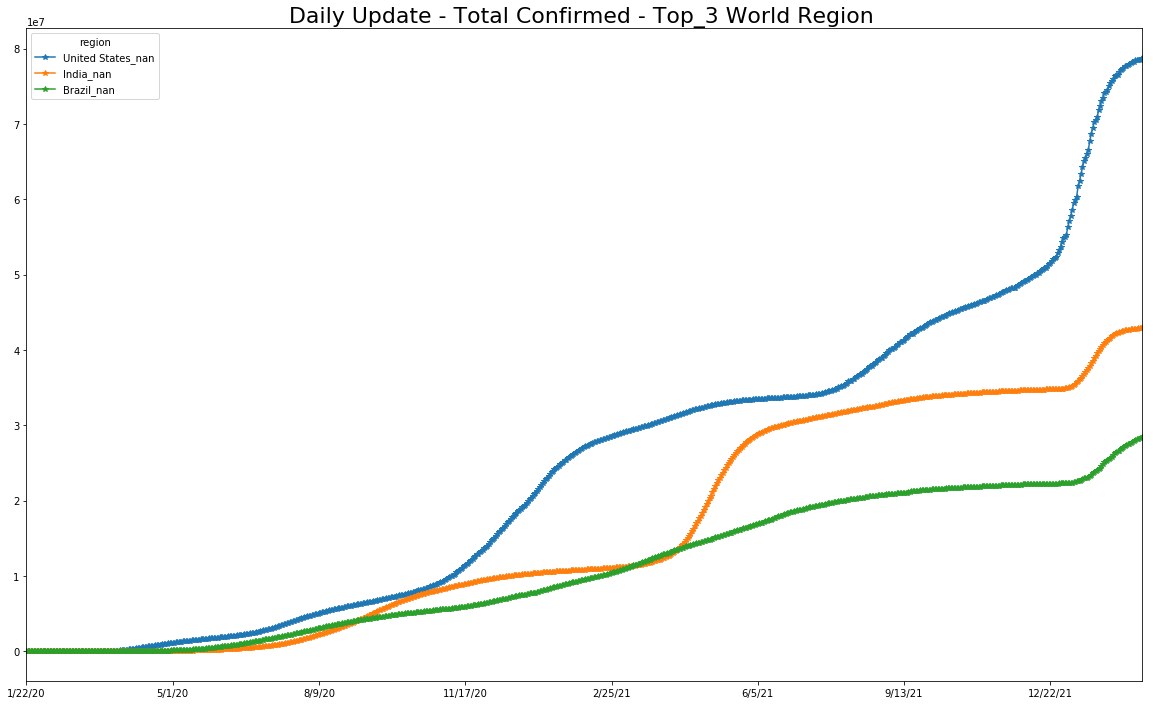

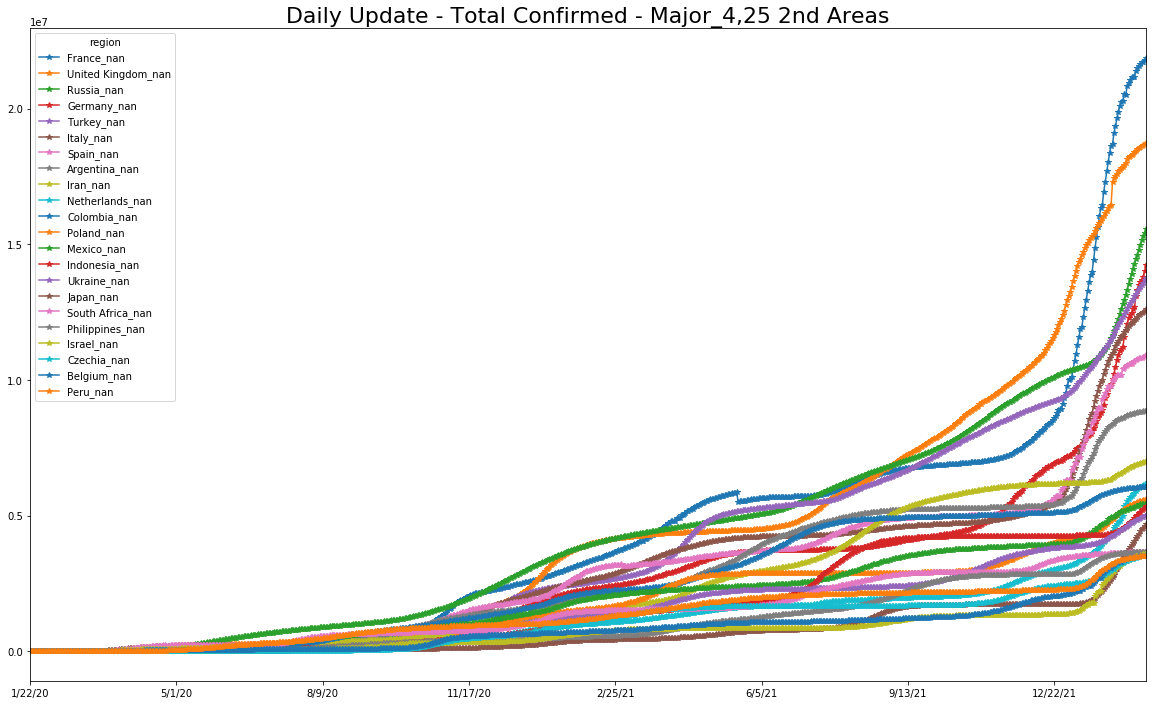

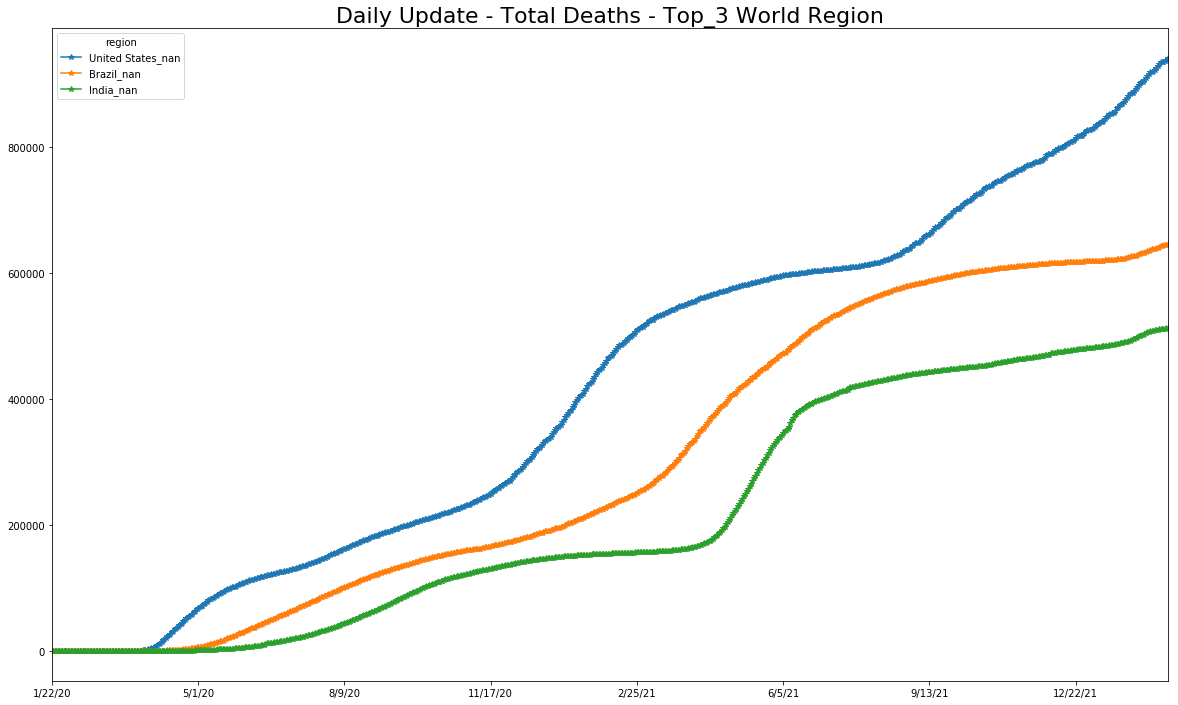

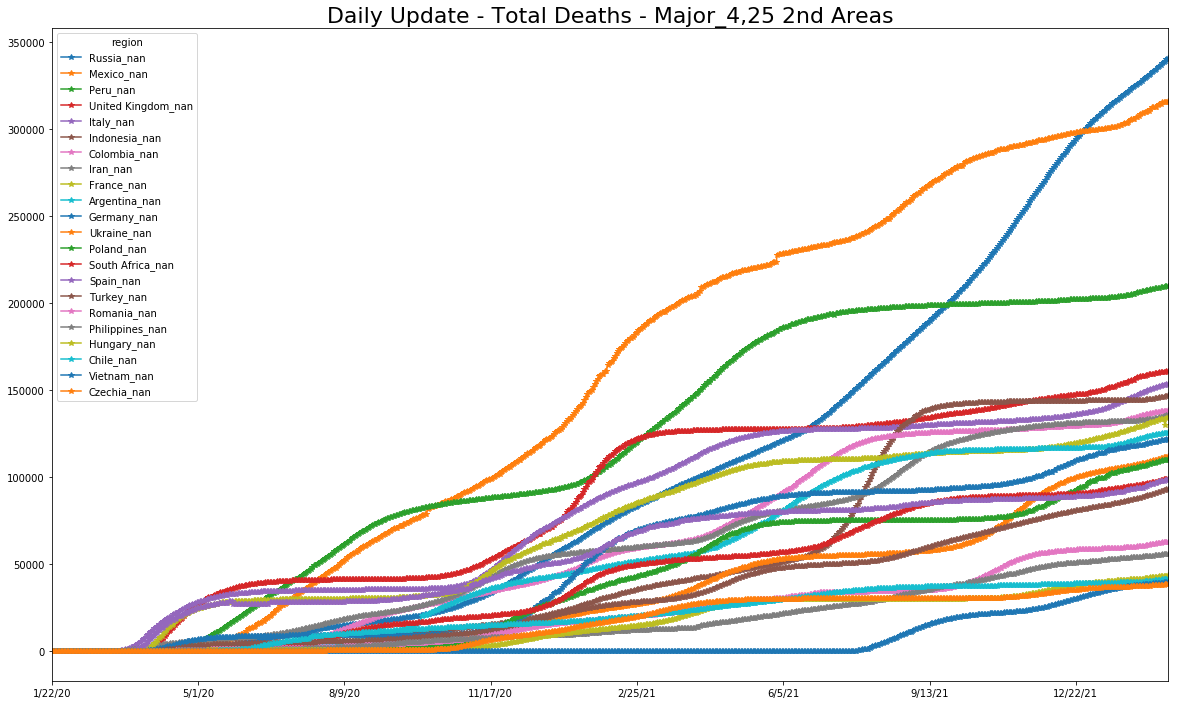

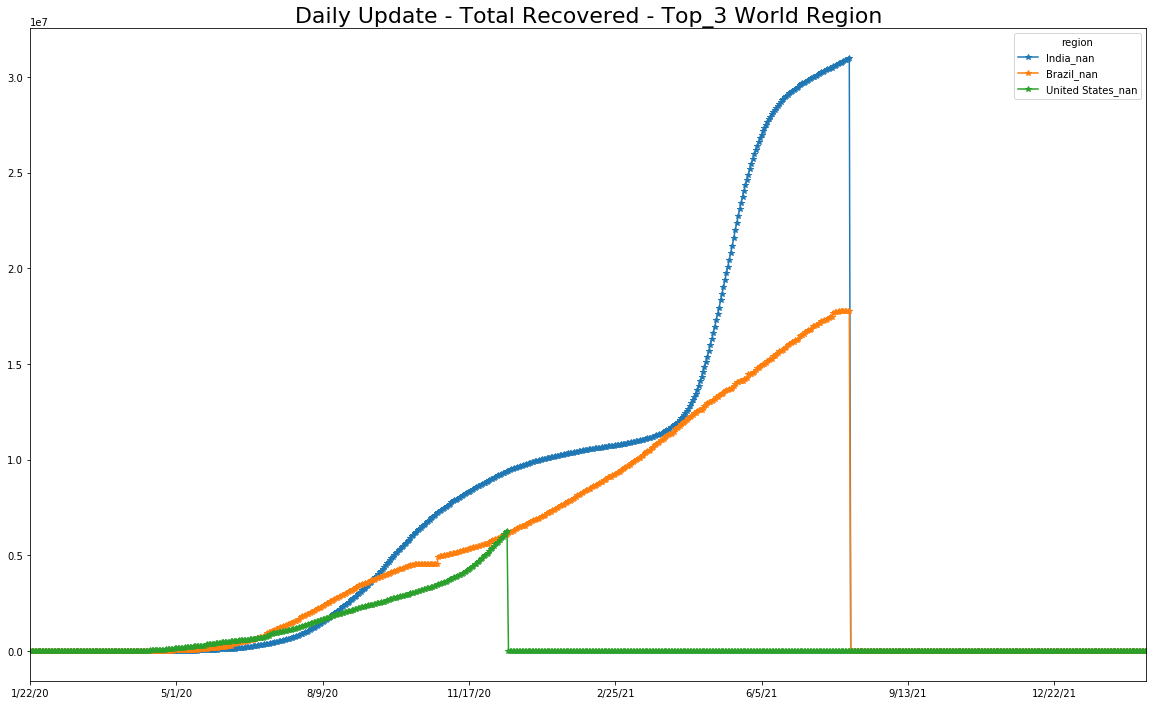

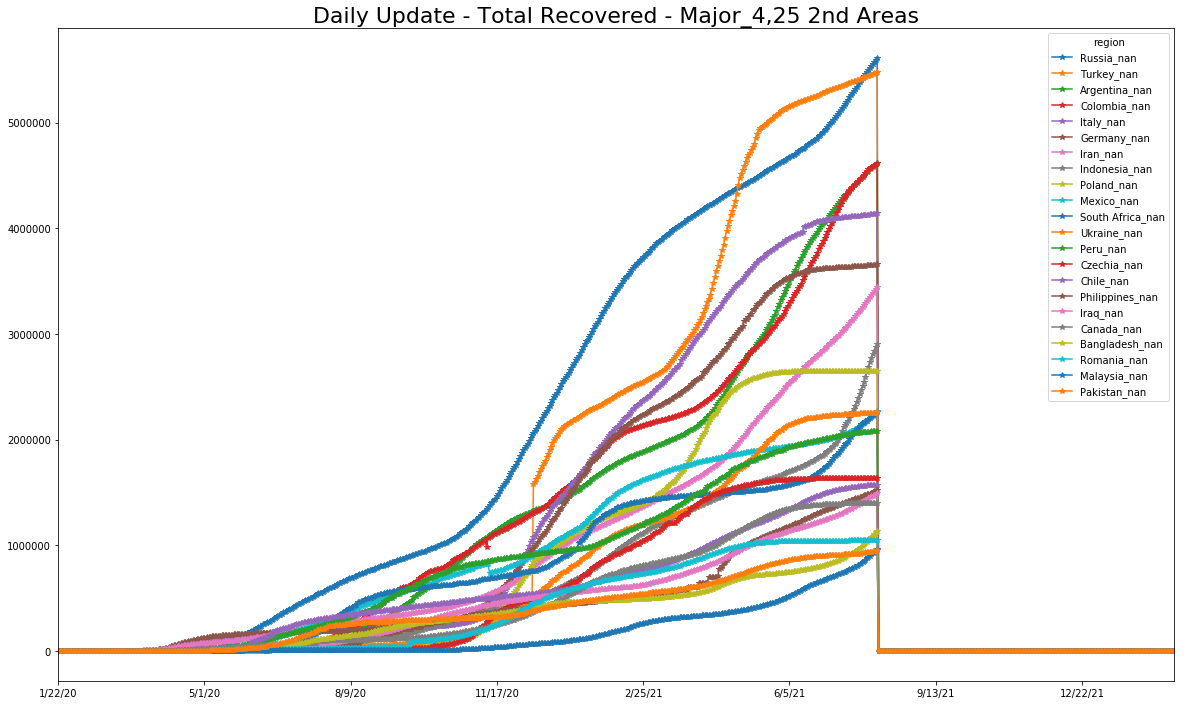

In [17]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [18]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [19]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [20]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2022/02/24


In [21]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [22]:
w[:]

Empty DataFrame
Columns: [date, region, min, max]
Index: []

## Kalman Filter With R

In [23]:
# Joao - FIX - Improve Performance 
## DROP_N=15
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [24]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
6/25/21           111592       132506       137772        13882       38371   
6/26/21           113124       132509       138113        13882       38528   
6/27/21           114220       132512       138465        13882       38556   

region   Antarctica_nan  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
6/25/21               0                     1263        4374587       224635   
6/26/21               0                     1263        4393142       224728   
6/27/21               0                     1263        4405247       224797   

region   Australia_Australian Capital Territory  ...  Uruguay_nan  \
6/25/21                                     124  ...       363580   
6/26/21                                     124  ...       364859   
6/27/21                                     124  ...       365866   

region   Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  Vietnam_nan  \
6/25/21          108184            4         266952        14537   
6/26/21          108730            4         268349        15325   
6/27/21          109223            4         269635        15740   

region   West Bank and Gaza_nan  Winter Olympics 2022_nan  Yemen_nan  \
6/25/21                  313520                         0       6905   
6/26/21                  313520                         0       6906   
6/27/21                  313721                         0       6908   

region   Zambia_nan  Zimbabwe_nan  
6/25/21      143215         45217  
6/26/21      146031         46018  
6/27/21      148568         46442  

[3 rows x 284 columns]

In [25]:
ts[-4:]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
2/20/22           172205       270164       264054        37589       98638   
2/21/22           172441       270370       264201        37589       98658   
2/22/22           172716       270455       264365        37820       98671   
2/23/22           172901       270734       264488        37901       98698   

region   Antarctica_nan  Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
2/20/22              11                     7408        8827504       415464   
2/21/22              11                     7408        8838674       415757   
2/22/22              11                     7408        8855624       416510   
2/23/22              11                     7429        8868188       417456   

region   Australia_Australian Capital Territory  ...  Uruguay_nan  \
2/20/22                                   45086  ...       815704   
2/21/22                                   45662  ...       819379   
2/22/22                                   46591  ...       823784   
2/23/22                                   47247  ...       827814   

region   Uzbekistan_nan  Vanuatu_nan  Venezuela_nan  Vietnam_nan  \
2/20/22          235267           11         510553      2787493   
2/21/22          235427           15         511073      2834373   
2/22/22          235602           15         511772      2890522   
2/23/22          235740           15         512560      2972378   

region   West Bank and Gaza_nan  Winter Olympics 2022_nan  Yemen_nan  \
2/20/22                  627956                       509      11736   
2/21/22                  633684                       509      11741   
2/22/22                  636055                       509      11746   
2/23/22                  638172                       510      11751   

region   Zambia_nan  Zimbabwe_nan  
2/20/22      311194        233352  
2/21/22      311264        233571  
2/22/22      311592        233980  
2/23/22      311888        234589  

[4 rows x 284 columns]

In [26]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [27]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [28]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [29]:
p=%R pred_all

In [30]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [31]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [32]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [33]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [34]:
w_in_model.tail(2)

date       region   min   max
8379 2020-05-10  Vietnam_nan  26.9  33.0
8380 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [35]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [36]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [37]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2021-06-26  Afghanistan_nan     113124             0             0   
2     2021-06-27  Afghanistan_nan     114220          1532             0   
3     2021-06-28  Afghanistan_nan     115751          1096             0   
4     2021-06-29  Afghanistan_nan     117158          1531          4159   
5     2021-06-30  Afghanistan_nan     118659          1407          4034   
6     2021-07-01  Afghanistan_nan     120216          1501          4439   
7     2021-07-02  Afghanistan_nan     122156          1557          4465   
8     2021-07-03  Afghanistan_nan     123485          1940          4998   
9     2021-07-04  Afghanistan_nan     124748          1329          4826   
10    2021-07-05  Afghanistan_nan     125937          1263          4532   
11    2021-07-06  Afghanistan_nan     127464          1189          3781   
12    2021-07-07  Afghanistan_nan     129021          1527          3979   
13    2021-07-08  Afghanistan_nan     130113          1557          4273   
14    2021-07-09  Afghanistan_nan     131586          1092          4176   
15    2021-07-10  Afghanistan_nan     132777          1473          4122   
16    2021-07-11  Afghanistan_nan     133578          1191          3756   
17    2021-07-12  Afghanistan_nan     134653           801          3465   
18    2021-07-13  Afghanistan_nan     135889          1075          3067   
19    2021-07-14  Afghanistan_nan     136643          1236          3112   
20    2021-07-15  Afghanistan_nan     137853           754          3065   
21    2021-07-16  Afghanistan_nan     139051          1210          3200   
22    2021-07-17  Afghanistan_nan     140224          1198          3162   
23    2021-07-18  Afghanistan_nan     140602          1173          3581   
24    2021-07-19  Afghanistan_nan     141499           378          2749   
25    2021-07-20  Afghanistan_nan     142414           897          2448   
26    2021-07-21  Afghanistan_nan     142762           915          2190   
27    2021-07-22  Afghanistan_nan     143183           348          2160   
28    2021-07-23  Afghanistan_nan     143439           421          1684   
29    2021-07-24  Afghanistan_nan     143666           256          1025   
30    2021-07-25  Afghanistan_nan     143871           227           904   
...          ...              ...        ...           ...           ...   
71020 2022-01-26     Zimbabwe_nan     228943           235           597   
71021 2022-01-27     Zimbabwe_nan     229096           167           689   
71022 2022-01-28     Zimbabwe_nan     229333           153           555   
71023 2022-01-29     Zimbabwe_nan     229415           237           557   
71024 2022-01-30     Zimbabwe_nan     229460            82           472   
71025 2022-01-31     Zimbabwe_nan     229666            45           364   
71026 2022-02-01     Zimbabwe_nan     229851           206           333   
71027 2022-02-02     Zimbabwe_nan     230012           185           436   
71028 2022-02-03     Zimbabwe_nan     230170           161           552   
71029 2022-02-04     Zimbabwe_nan     230170           158           504   
71030 2022-02-05     Zimbabwe_nan     230402             0           319   
71031 2022-02-06     Zimbabwe_nan     230402           232           390   
71032 2022-02-07     Zimbabwe_nan     230402             0           232   
71033 2022-02-08     Zimbabwe_nan     230603             0           232   
71034 2022-02-09     Zimbabwe_nan     230740           201           201   
71035 2022-02-10     Zimbabwe_nan     231040           137           338   
71036 2022-02-11     Zimbabwe_nan     231214           300           638   
71037 2022-02-12     Zimbabwe_nan     231299           174           611   
71038 2022-02-13     Zimbabwe_nan     231381            85           559   
71039 2022-02-14     Zimbabwe_nan     231603            82           341   
71040 2022-02-15     Zimbabwe_nan     231603           222  

In [38]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [39]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
71049 2022-02-24  Zimbabwe_nan          0           609          1237   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
71049          2376         100.260283         100.530105         101.023203   

       last_day  kalman_prediction  population  infected_rate  min  max  
71049    234589           234742.0    14862924       0.000158  NaN  NaN

In [40]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
71049 2022-02-24  Zimbabwe_nan          0           609          1237   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
71049          2376         100.260283         100.530105         101.023203   

       last_day  kalman_prediction  population  infected_rate  min  max  
71049    234589           234742.0    14862924       0.000158  NaN  NaN

In [41]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
### Assumption : Each affected person can contact up to 9 others that not report or are assimptomatic COVID19 cases.
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=np.clip(ratiod['infected_rate']*900,0.0,1.0)
#
ratiod['delta : pred new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : pred new_cases per 1M hab']=ratiod['delta : pred new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
69577  2022-02-22  Zimbabwe_nan     233980           219           541   
69578  2022-02-23  Zimbabwe_nan     234589           409           756   
69579  2022-02-24  Zimbabwe_nan          0           609          1237   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
69577          1968         100.093854         100.232163         100.849734   
69578          2377         100.175112         100.324156         101.026330   
69579          2376         100.260283         100.530105         101.023203   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
69577               233571  ...    14862924       0.000157  NaN  NaN   
69578               233980  ...    14862924       0.000157  NaN  NaN   
69579               234589  ...    14862924       0.000158  NaN  NaN   

       population_percentage : infected_rate confirmed  \
69577                                         0.015715   
69578                                         0.015743   
69579                                         0.015784   

       population_percentage : factor 9/10 infected_rate confirmed  \
69577                                           0.141436             
69578                                           0.141683             
69579                                           0.142052             

       delta : pred new_cases  delta : pred new_cases per 1M hab  \
69577                   366.0                          24.625033   
69578                   263.0                          17.695038   
69579                   153.0                          10.294071   

       delta : roling 7day AVG  \
69577               281.142857   
69578               339.571429   
69579               339.428571   

       delta : aprox 14-day case notification rate per 100k hab  
69577                                          26.482003         
69578                                          31.985631         
69579                                          31.972175         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse           mae
273  United States_nan  2.559784e+13  5.059430e+06  442087.02459


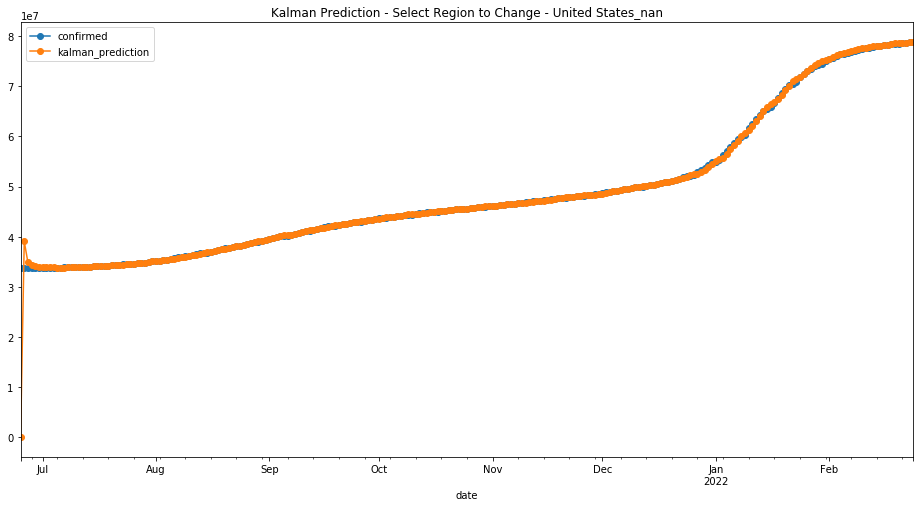

In [42]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse          rmse          mae
218  Russia_nan  1.020011e+12  1.009956e+06  77134.57377


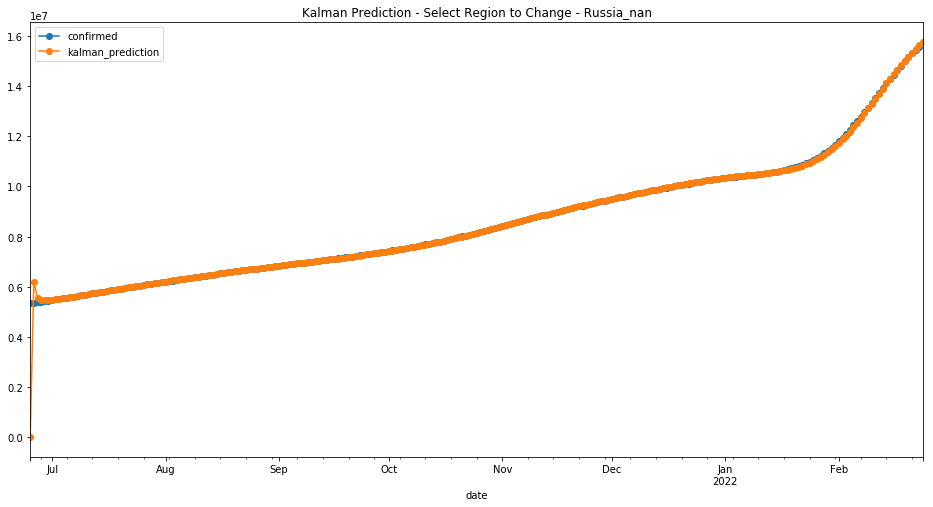

In [43]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse          rmse            mae
31  Brazil_nan  3.381653e+12  1.838927e+06  154867.401639


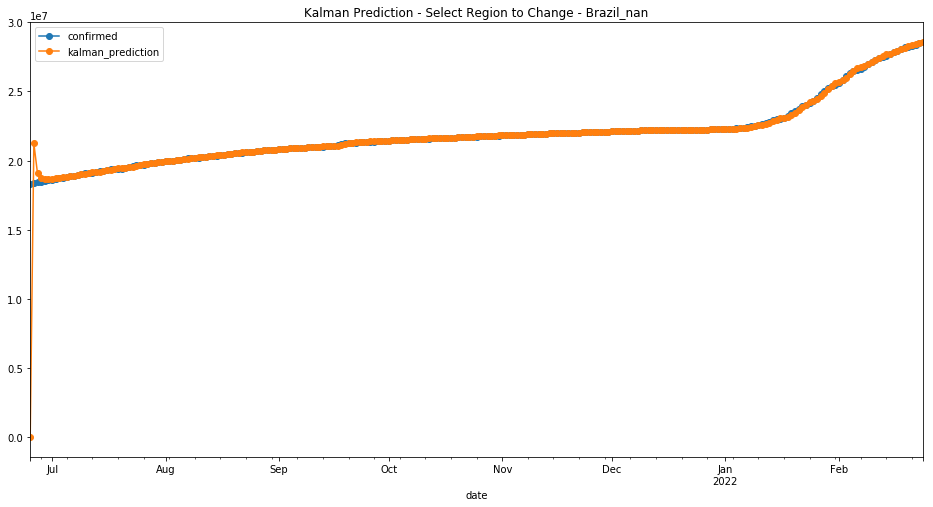

In [44]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse          rmse           mae
272  United Kingdom_nan  1.451191e+12  1.204654e+06  103269.67623


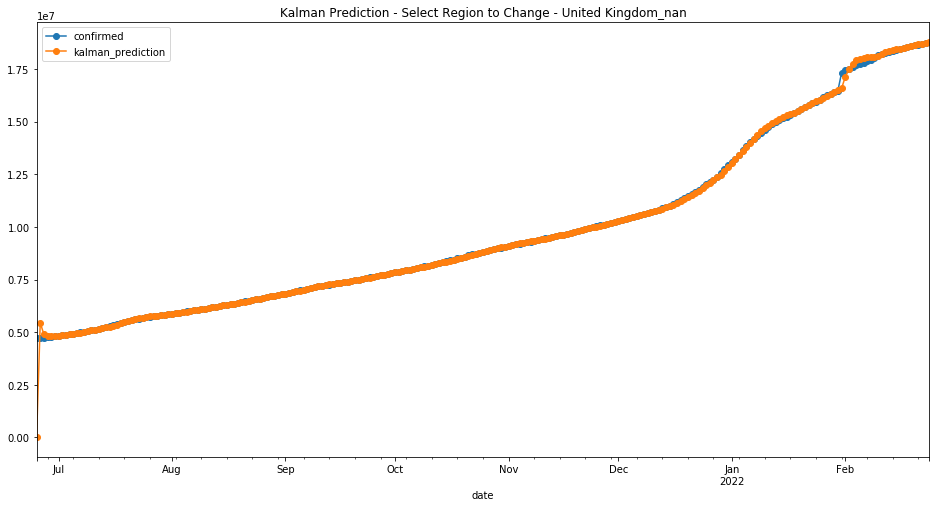

In [45]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [46]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment (build 11.0.13+8-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.13+8-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp66v009we
  JVM stdout: /tmp/tmp66v009we/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp66v009we/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  ----------------------------------------
H2O cluster uptime:         01 secs
H2O cluster timezone:       Etc/GMT
H2O data parsing timezone:  UTC
H2O cluster version:        3.22.0.1
H2O cluster version age:    3 years, 3 months and 28 days !!!
H2O cluster name:           H2O_from_python_unknownUser_afq73q
H2O cluster total nodes:    1
H2O cluster free memory:    3.541 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.7.7 final
--------------------------  ----------------------------------------

In [47]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2022-02-16
last_train_date= 2022-02-23
first_bootstrap_date= 2022-02-15
boost_bootstrap_date= 2022-02-20
first_test_date= 2022-02-14
last_test_date= 2022-02-24
first_valid_date= 2022-02-22


In [48]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [49]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [50]:
pred2.iloc[:25]

0  confirmed       date           region
0   173275.0     171422 2022-02-15  Afghanistan_nan
1   173461.0     171519 2022-02-16  Afghanistan_nan
2   173569.0     171673 2022-02-17  Afghanistan_nan
3   173666.0     171857 2022-02-18  Afghanistan_nan
4   173755.0     171931 2022-02-19  Afghanistan_nan
5   173749.0     172205 2022-02-20  Afghanistan_nan
6   173939.0     172441 2022-02-21  Afghanistan_nan
7   174136.0     172716 2022-02-22  Afghanistan_nan
8   174386.0     172901 2022-02-23  Afghanistan_nan
9   174575.0          0 2022-02-24  Afghanistan_nan
10  269349.0     268491 2022-02-15      Albania_nan
11  269510.0     268940 2022-02-16      Albania_nan
12  269927.0     269301 2022-02-17      Albania_nan
13  270234.0     269601 2022-02-18      Albania_nan
14  270497.0     269904 2022-02-19      Albania_nan
15  270808.0     270164 2022-02-20      Albania_nan
16  271070.0     270370 2022-02-21      Albania_nan
17  271271.0     270455 2022-02-22      Albania_nan
18  271341.0     270734 2022-02-23      Albania_nan
19  271614.0          0 2022-02-24      Albania_nan
20  264081.0     262570 2022-02-15      Algeria_nan
21  264491.0     262994 2022-02-16      Algeria_nan
22  264907.0     263369 2022-02-17      Algeria_nan
23  265265.0     263685 2022-02-18      Algeria_nan
24  265573.0     263936 2022-02-19      Algeria_nan

In [51]:
pred2.iloc[175:195]

0  confirmed       date          region
175  2446344.0    2473099 2022-02-20     Austria_nan
176  2507477.0    2494535 2022-02-21     Austria_nan
177  2516470.0    2515962 2022-02-22     Austria_nan
178  2539534.0    2550371 2022-02-23     Austria_nan
179  2577420.0          0 2022-02-24     Austria_nan
180   754600.0     752605 2022-02-15  Azerbaijan_nan
181   759717.0     759753 2022-02-16  Azerbaijan_nan
182   766644.0     764202 2022-02-17  Azerbaijan_nan
183   770058.0     768019 2022-02-18  Azerbaijan_nan
184   773815.0     771709 2022-02-19  Azerbaijan_nan
185   777346.0     774394 2022-02-20  Azerbaijan_nan
186   779676.0     775432 2022-02-21  Azerbaijan_nan
187   780000.0     777804 2022-02-22  Azerbaijan_nan
188   782226.0     779783 2022-02-23  Azerbaijan_nan
189   783609.0          0 2022-02-24  Azerbaijan_nan
190    33771.0      32972 2022-02-15     Bahamas_nan
191    33784.0      33005 2022-02-16     Bahamas_nan
192    33794.0      33005 2022-02-17     Bahamas_nan
193    33854.0      33018 2022-02-18     Bahamas_nan
194    33843.0      33024 2022-02-19     Bahamas_nan

In [52]:
pred2.iloc[220:240]

0  confirmed       date        region
220   52008.0      52310 2022-02-15  Barbados_nan
221   52205.0      52637 2022-02-16  Barbados_nan
222   52568.0      52909 2022-02-17  Barbados_nan
223   52868.0      53253 2022-02-18  Barbados_nan
224   53094.0      53508 2022-02-19  Barbados_nan
225   53408.0      53698 2022-02-20  Barbados_nan
226   53646.0      53884 2022-02-21  Barbados_nan
227   53804.0      54106 2022-02-22  Barbados_nan
228   53954.0      54344 2022-02-23  Barbados_nan
229   54140.0          0 2022-02-24  Barbados_nan
230  846694.0     843717 2022-02-15   Belarus_nan
231  851856.0     851636 2022-02-16   Belarus_nan
232  860267.0     859884 2022-02-17   Belarus_nan
233  867984.0     868078 2022-02-18   Belarus_nan
234  875905.0     875934 2022-02-19   Belarus_nan
235  883699.0     883217 2022-02-20   Belarus_nan
236  891047.0     887582 2022-02-21   Belarus_nan
237  894956.0     890089 2022-02-22   Belarus_nan
238  897146.0     896319 2022-02-23   Belarus_nan
239  903744.0          0 2022-02-24   Belarus_nan

In [53]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [54]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  137205701378.6885
# MSE on the validation data =  95499849453431.92
# R^2 on the training data =  0.9987531635019932
# R^2 on the validation data =  0.4090105509294878


In [55]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1645686559668_1


ModelMetricsRegression: drf
** Reported on train data. **

MSE: 137205701378.6885
RMSE: 370412.87960691715
MAE: 25355.68722658559
RMSLE: 0.4542176485299941
Mean Residual Deviance: 137205701378.6885

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 95499849453431.92
RMSE: 9772402.44021049
MAE: 2913955.48481091
RMSLE: 8.437494304436013
Mean Residual Deviance: 95499849453431.92
Scoring History: 


timestamp            duration    number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse     validation_mae      validation_deviance
---  -------------------  ----------  -----------------  ------------------  ------------------  -------------------  ------------------  ------------------  ---------------------
     2022-02-24 07:09:27  0.063 sec   0.0                nan                 nan                 nan                  nan                 nan                 nan
     2022-02-24 07:09:28  0.474 sec   1.0                148033.7025509403   46530.02553338538   21913977090.940273   10363309.214002993  3044078.7316066297  107398177865039.31
     2022-02-24 07:09:28  0.660 sec   2.0                155268.7828669281   47026.49080929078   24108394932.977257   9907980.73072212    2928507.7447447563  98168082160360.83
     2022-02-24 07:09:28  0.919 sec   3.0                463762.994763435    53965.56905899256   215076115311.9498    9882447.551560195   2927210.8226679675  97662769609338.11
     2022-02-24 07:09:28  1.037 sec   4.0                432049.8332081307   50420.682582709225  186667058375.17352   9882704.862390513   2942225.840143582   97667855397117.06
---  ---                  ---         ---                ---                 ---                 ---                  ---                 ---                 ---
     2022-02-24 07:09:39  12.105 sec  195.0              361771.5114972376   27082.6359220716    130878626530.99591   9769467.803206159   2916884.181682729   95442501157881.77
     2022-02-24 07:09:43  16.134 sec  281.0              354242.5857951104   26071.30393161145   125487809590.80615   9777339.186429705   2913901.299712719   95596361566493.9
     2022-02-24 07:09:47  20.139 sec  367.0              369192.29503122775  25712.338616613662  136302950710.42513   9772835.398017978   2915494.1847452982  95508311716753.22
     2022-02-24 07:09:52  24.159 sec  449.0              369627.17213597865  25463.163695988344  136624246381.24039   9774395.273492951   2914099.1587535227  95538802962481.33
     2022-02-24 07:09:54  26.786 sec  500.0              370412.87960691715  25355.68722658559   137205701378.6885    9772402.44021049    2913955.48481091    95499849453431.92


See the whole table with table.as_data_frame()
Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
kalman_prediction  1.5489e+20             1                    0.344696
last_day           1.27807e+20            0.825143             0.284423
region             9.74212e+19            0.628969             0.216803
7_day_change       2.9239e+19             0.188772             0.065069
3_day_change       1.78582e+19            0.115296             0.0397419
infected_rate      9.16821e+18            0.0591916            0.0204031
1_day_change       7.87503e+18            0.0508426            0.0175252
7_day_change_rate  2.23291e+18            0.0144161            0.00496917
3_day_change_rate  2.0528e+18             0.0132533            0.00456834
1_day_change_rate  8.09189e+17            0.00522427           0.00180078

In [56]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0  kalman_prediction         1.548904e+20           1.000000    0.344696
1           last_day         1.278066e+20           0.825143    0.284423
2             region         9.742123e+19           0.628969    0.216803
3       7_day_change         2.923900e+19           0.188772    0.065069
4       3_day_change         1.785819e+19           0.115296    0.039742
5      infected_rate         9.168214e+18           0.059192    0.020403
6       1_day_change         7.875027e+18           0.050843    0.017525
7  7_day_change_rate         2.232914e+18           0.014416    0.004969
8  3_day_change_rate         2.052801e+18           0.013253    0.004568
9  1_day_change_rate         8.091888e+17           0.005224    0.001801

In [57]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


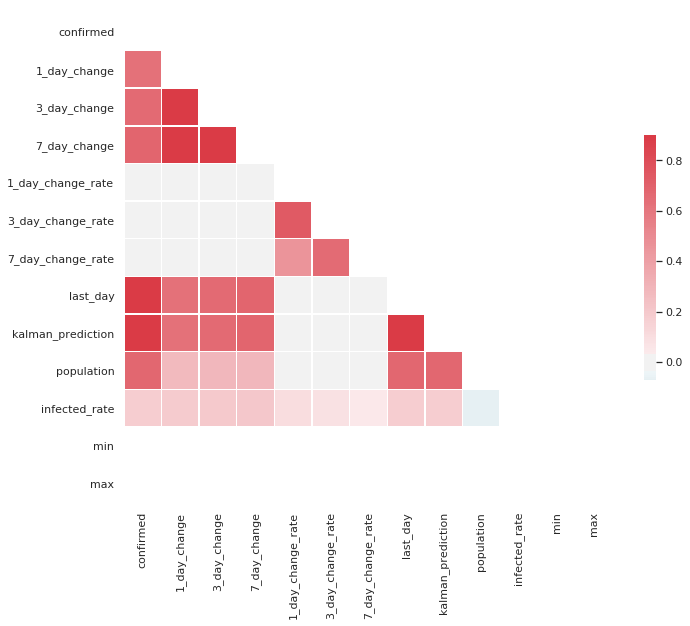

In [58]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [59]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.625324
3_day_change         0.663485
7_day_change         0.684743
1_day_change_rate    0.021817
3_day_change_rate    0.013247
7_day_change_rate    0.002663
last_day             0.992853
kalman_prediction    0.994006
population           0.678002
infected_rate        0.176676
min                       NaN
max                       NaN
Name: confirmed, dtype: float64


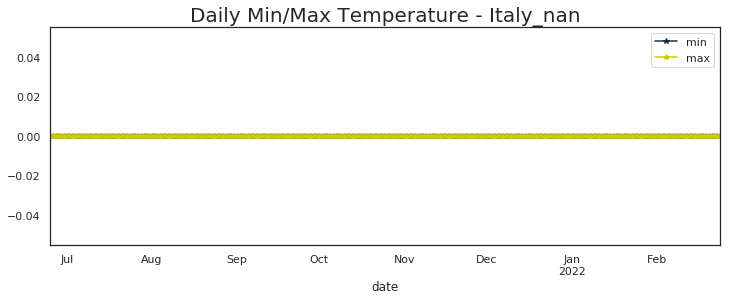

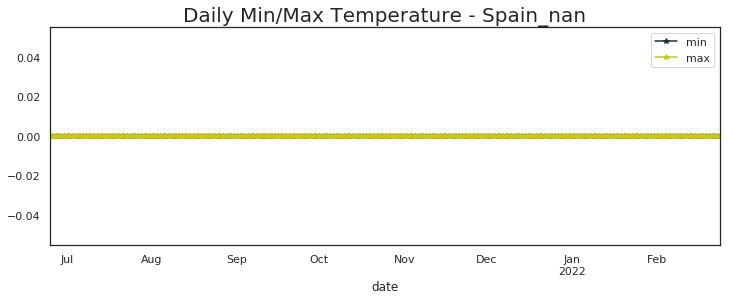

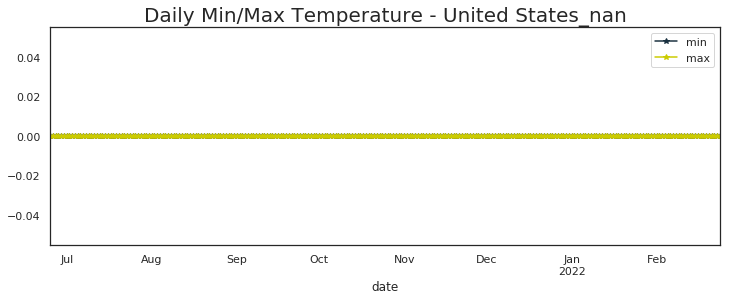

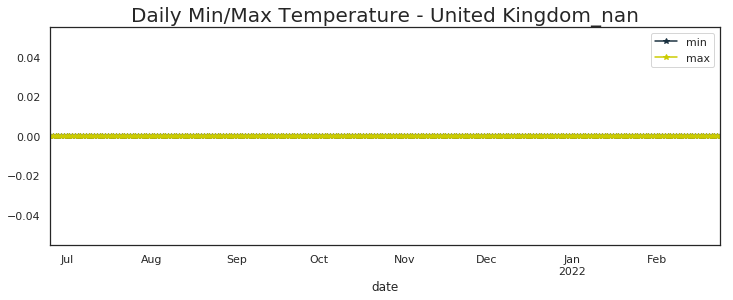

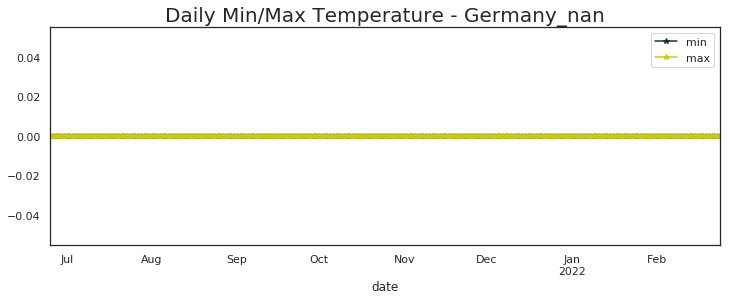

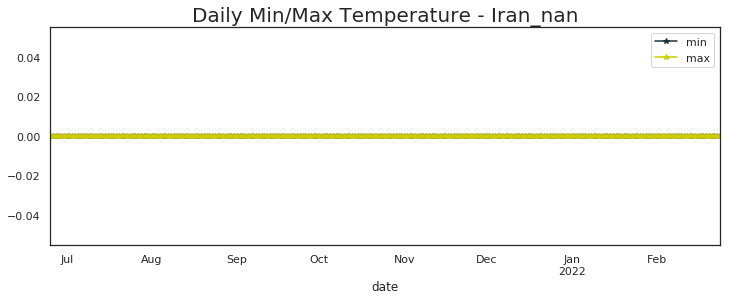

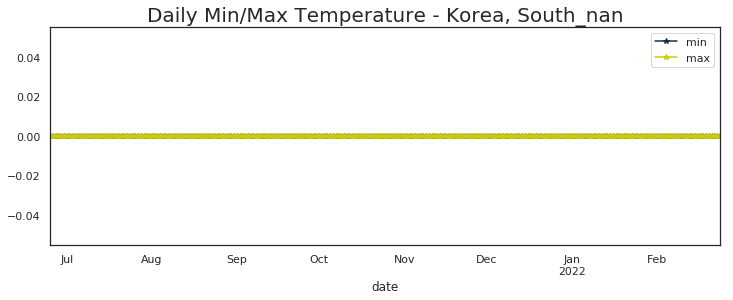

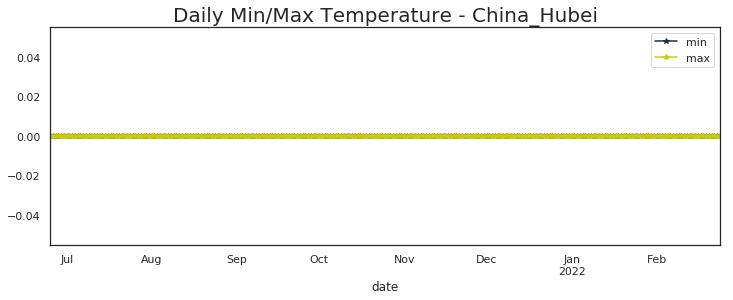

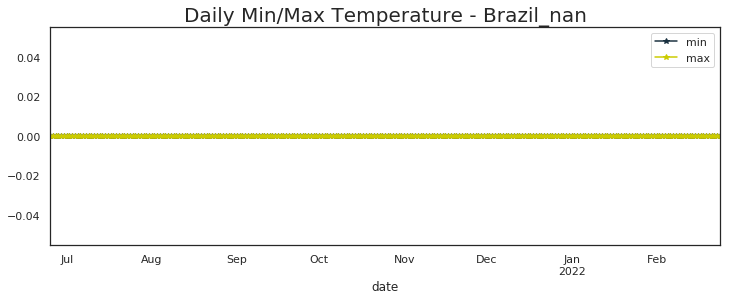

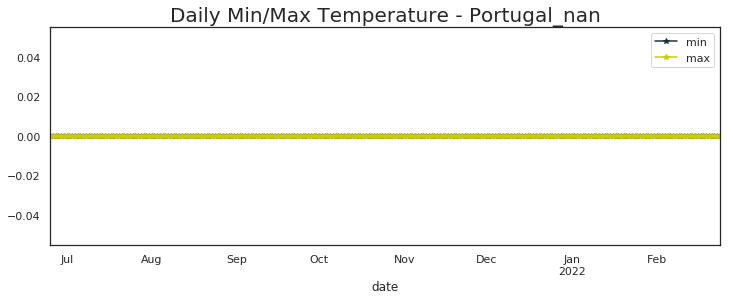

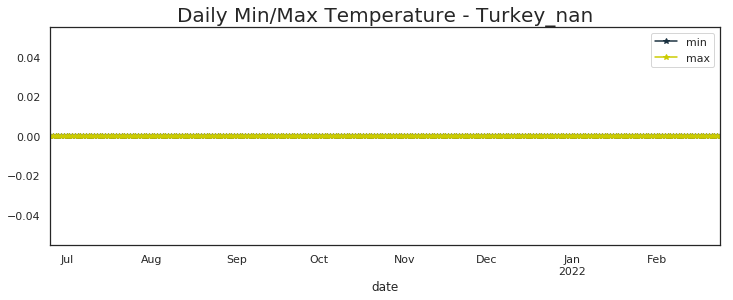

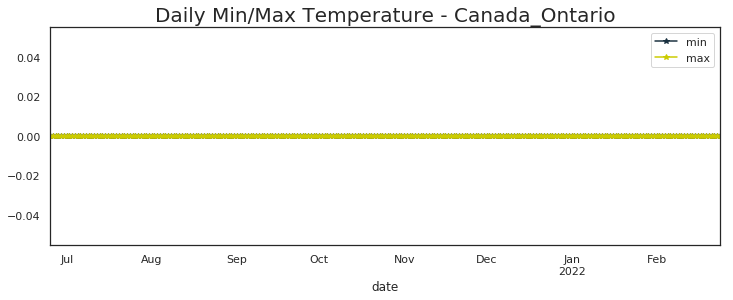

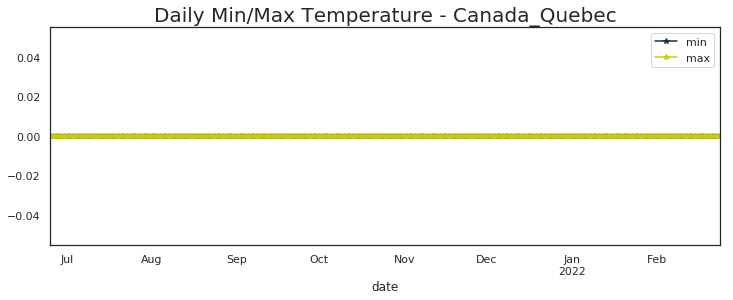

In [60]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [61]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                            min  max
region                              
United States_nan           0.0  0.0
India_nan                   0.0  0.0
Brazil_nan                  0.0  0.0
France_nan                  0.0  0.0
United Kingdom_nan          0.0  0.0
Russia_nan                  0.0  0.0
Germany_nan                 0.0  0.0
Turkey_nan                  0.0  0.0
Italy_nan                   0.0  0.0
Spain_nan                   0.0  0.0
Argentina_nan               0.0  0.0
Iran_nan                    0.0  0.0
Netherlands_nan             0.0  0.0
Colombia_nan                0.0  0.0
Poland_nan                  0.0  0.0
Mexico_nan                  0.0  0.0
Indonesia_nan               0.0  0.0
Ukraine_nan                 0.0  0.0
Japan_nan                   0.0  0.0
South Africa_nan            0.0  0.0
Philippines_nan             0.0  0.0
Israel_nan                  0.0  0.0
Czechia_nan                 0.0  0.0
Belgium_nan                 0.0  0.0
Pe

### Kalman X Days Ahead Prediction

In [62]:
%%R

#install.packages('reshape')

NULL


In [63]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [64]:
all_new=%R all_new

In [65]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

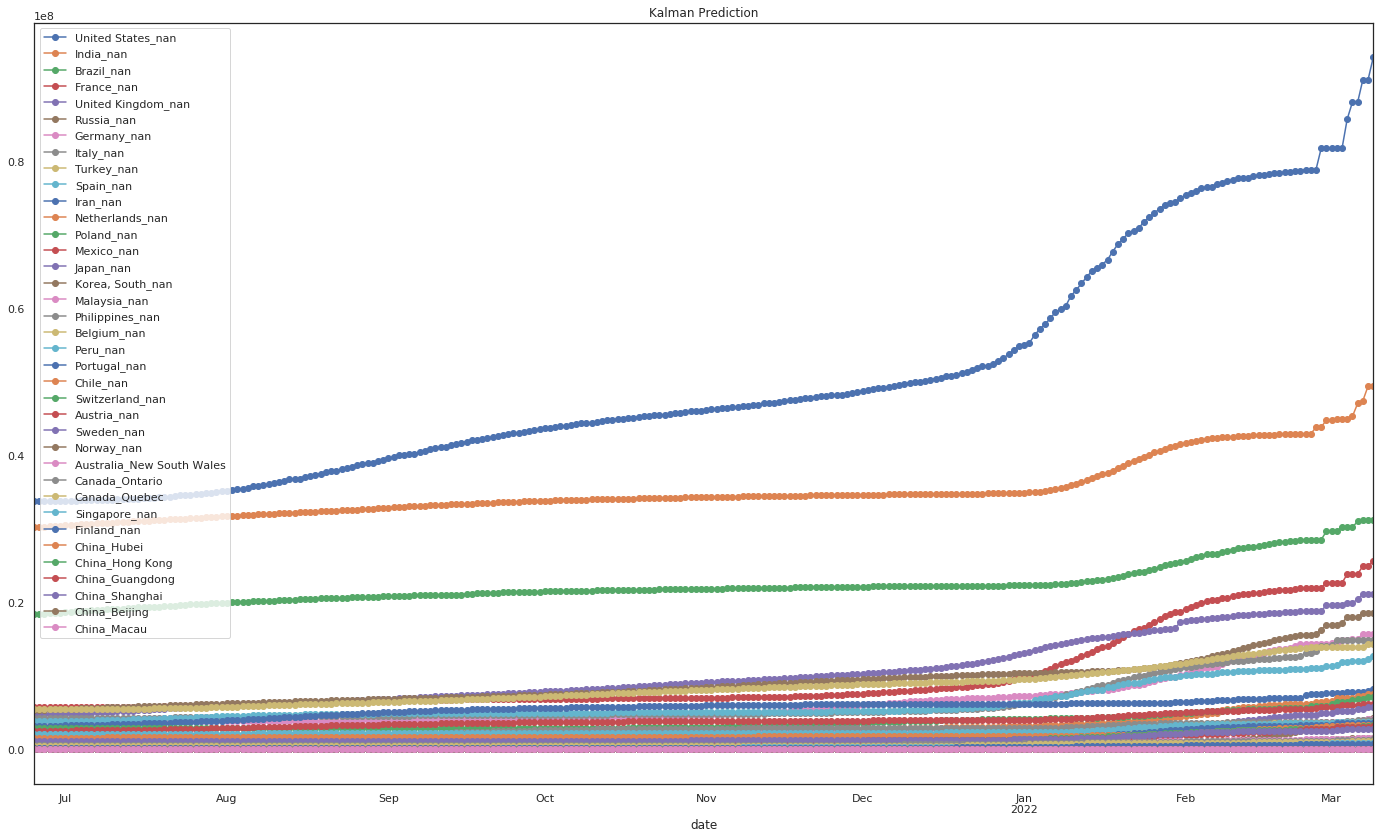

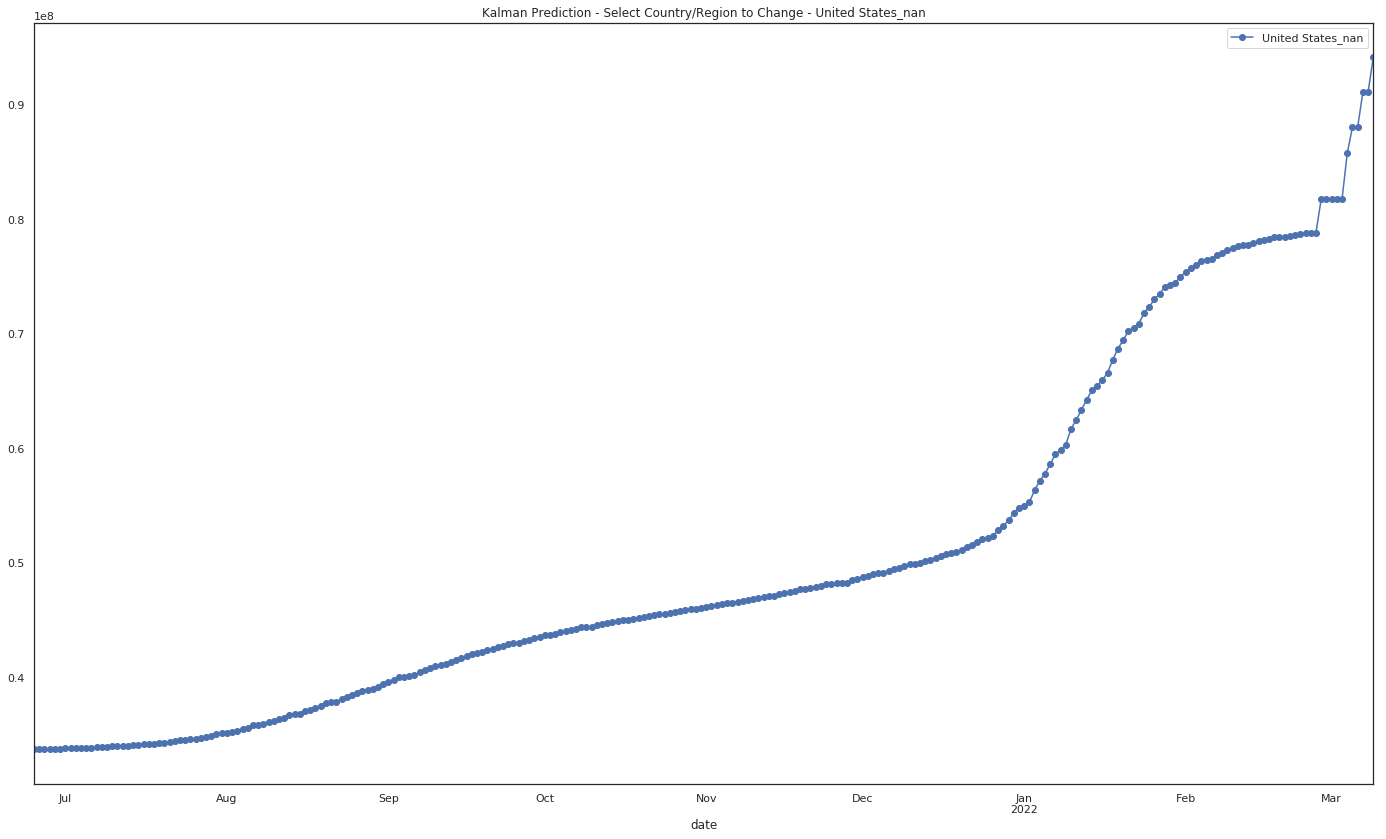

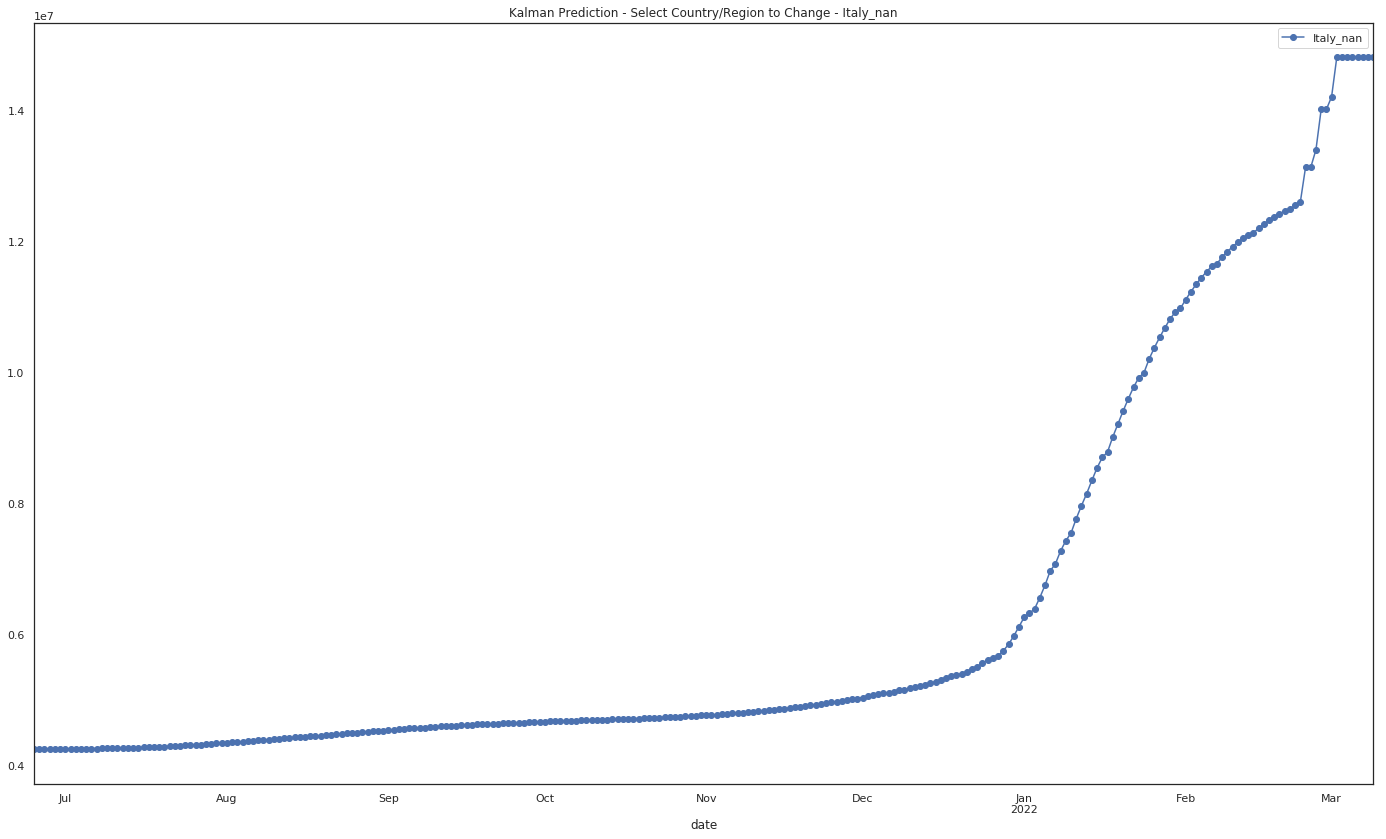

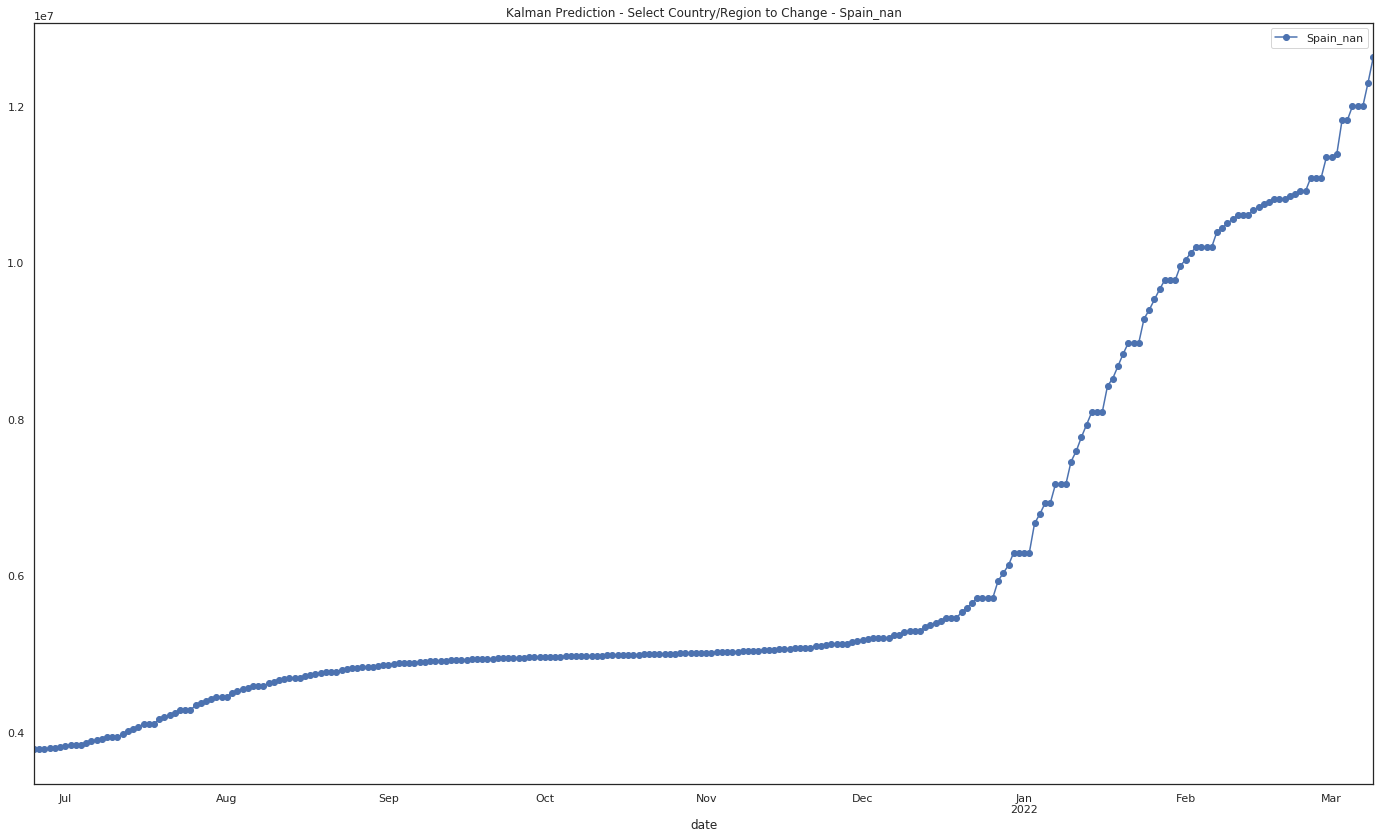

In [66]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


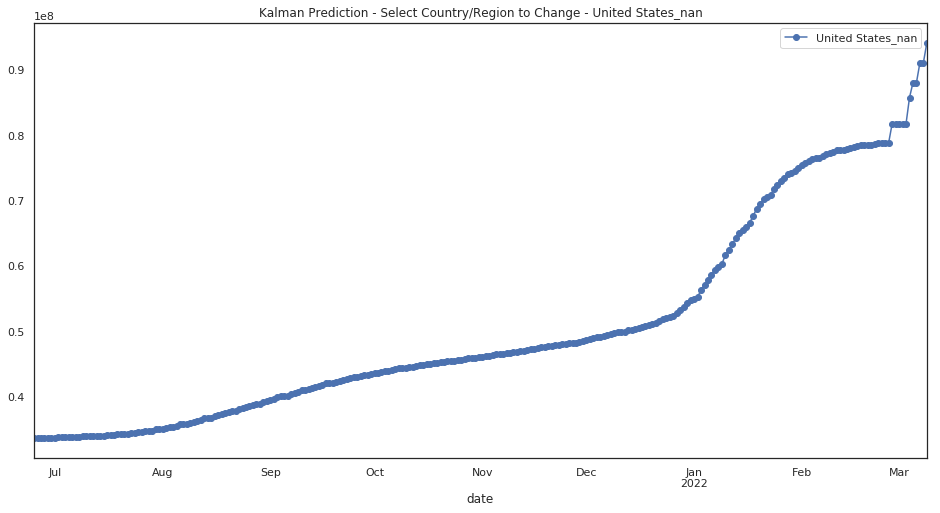

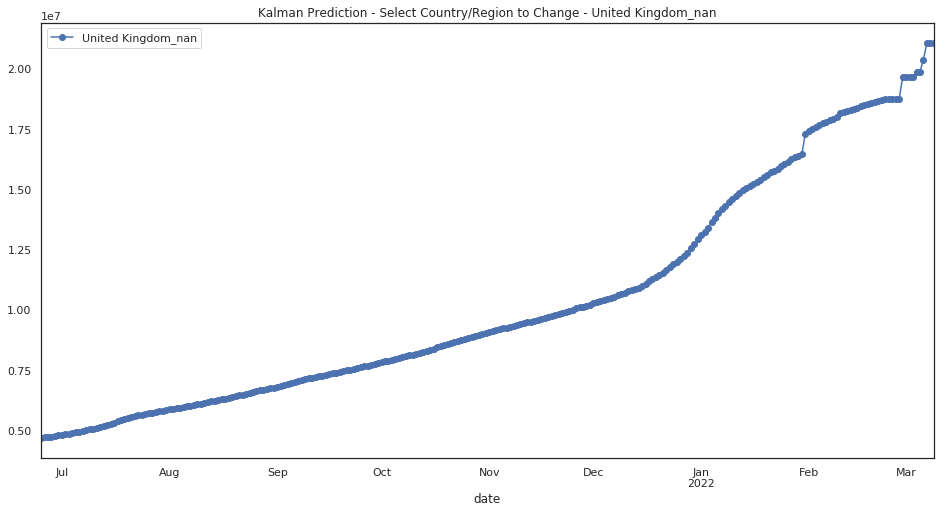

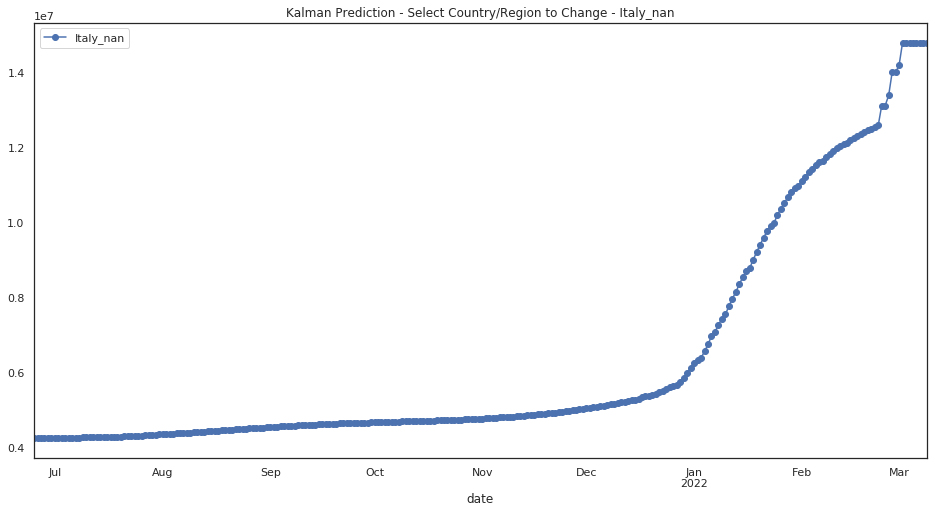

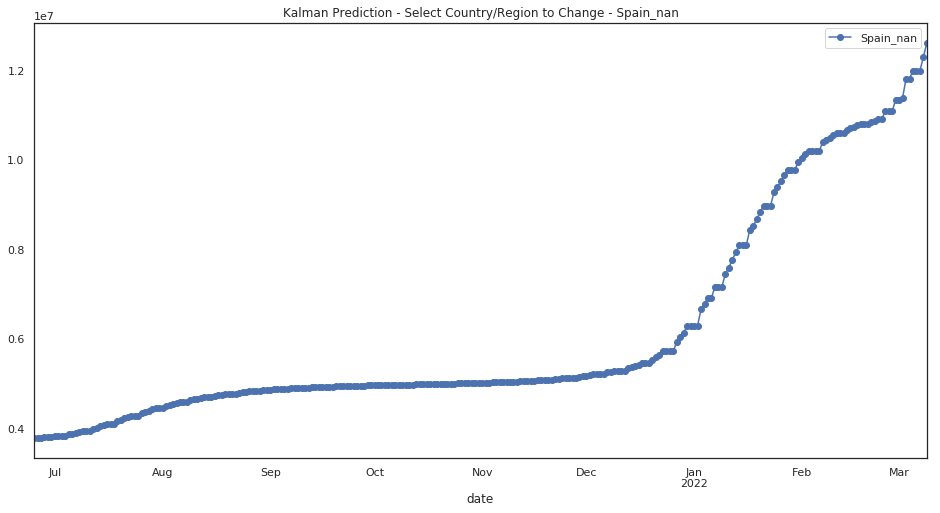

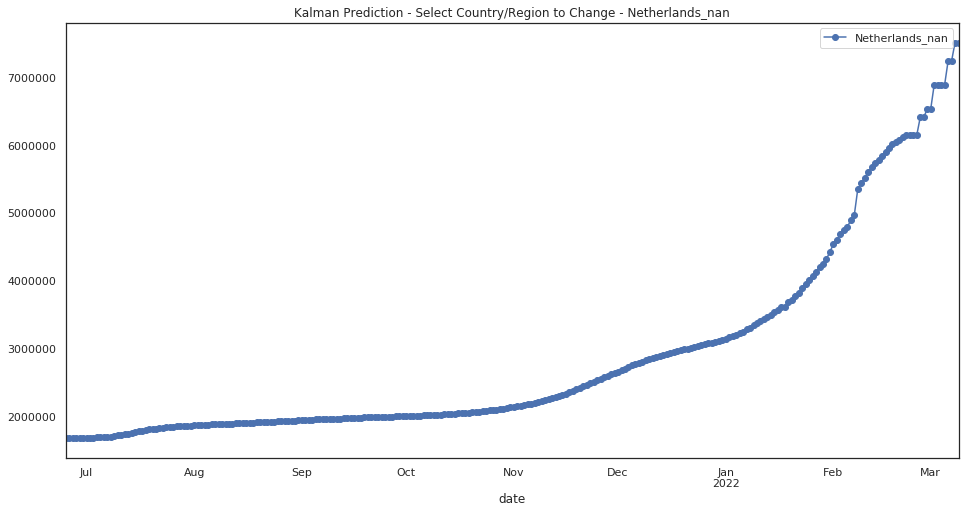

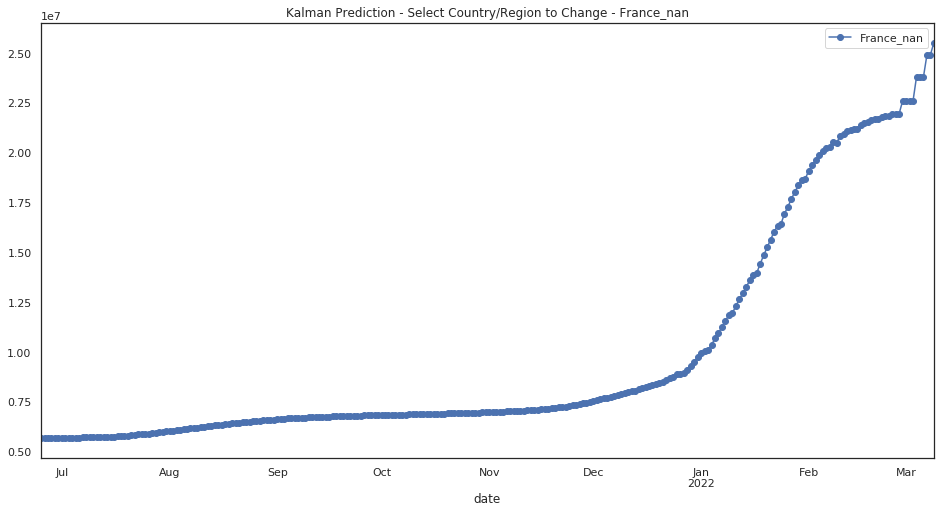

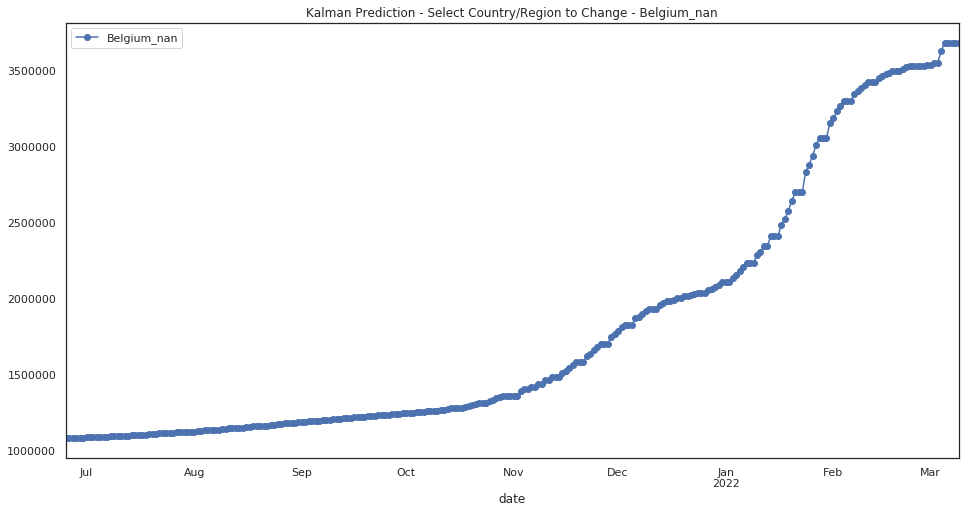

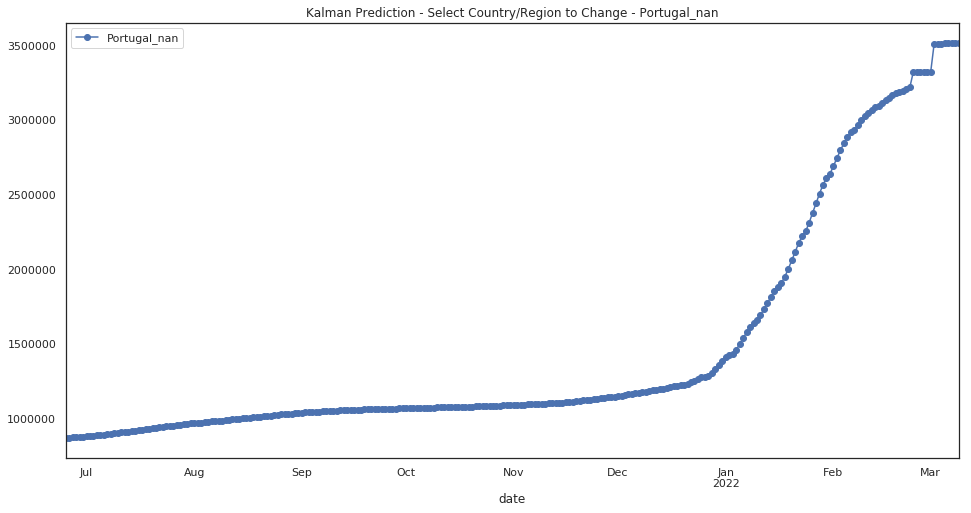

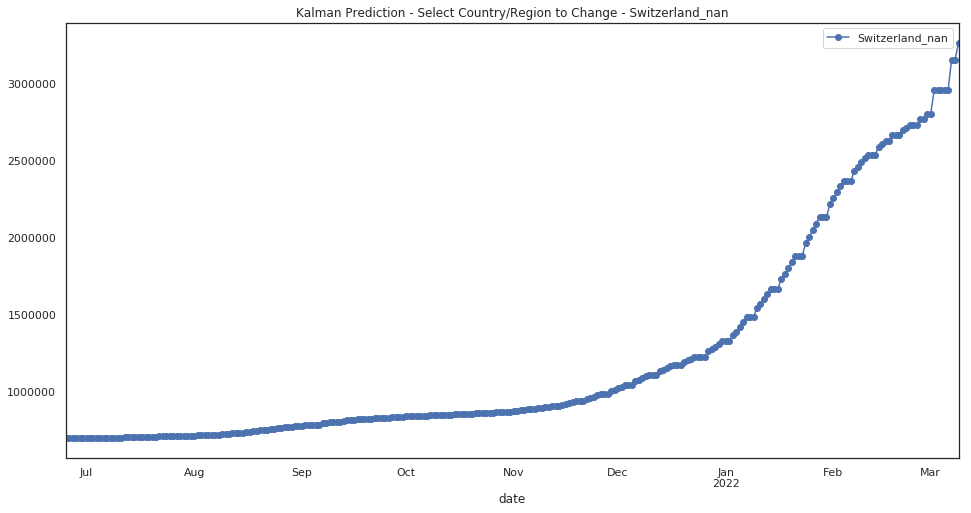

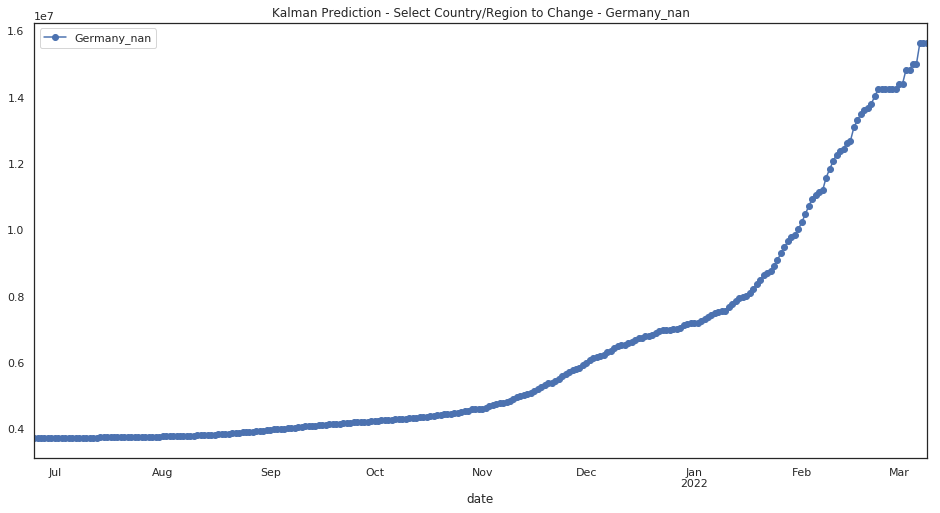

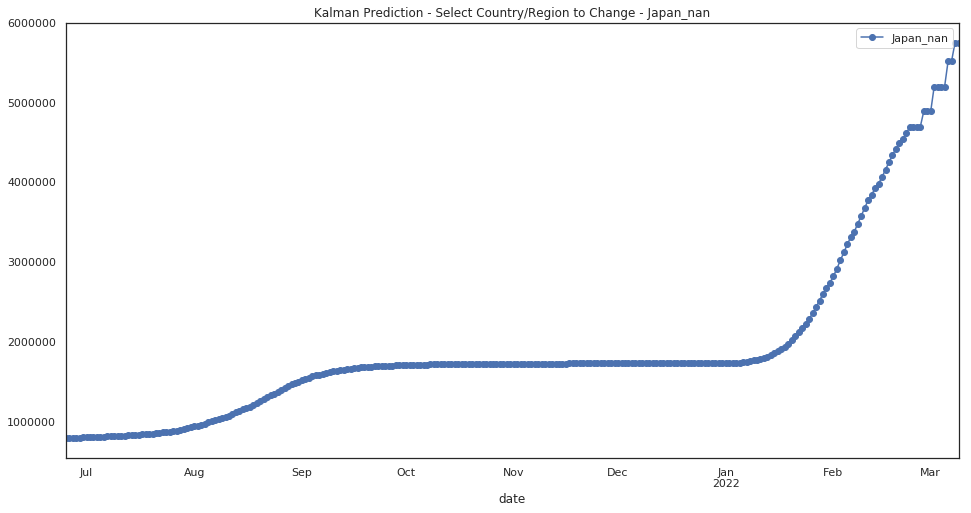

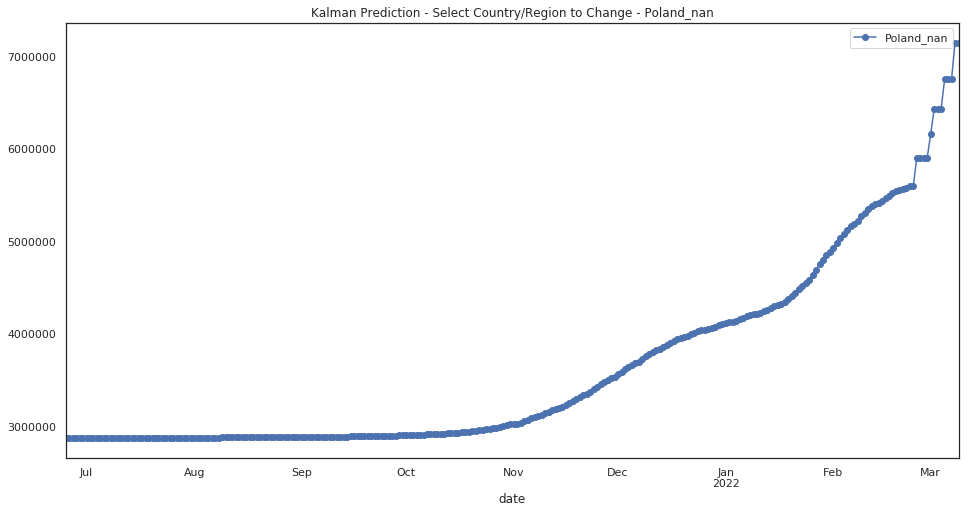

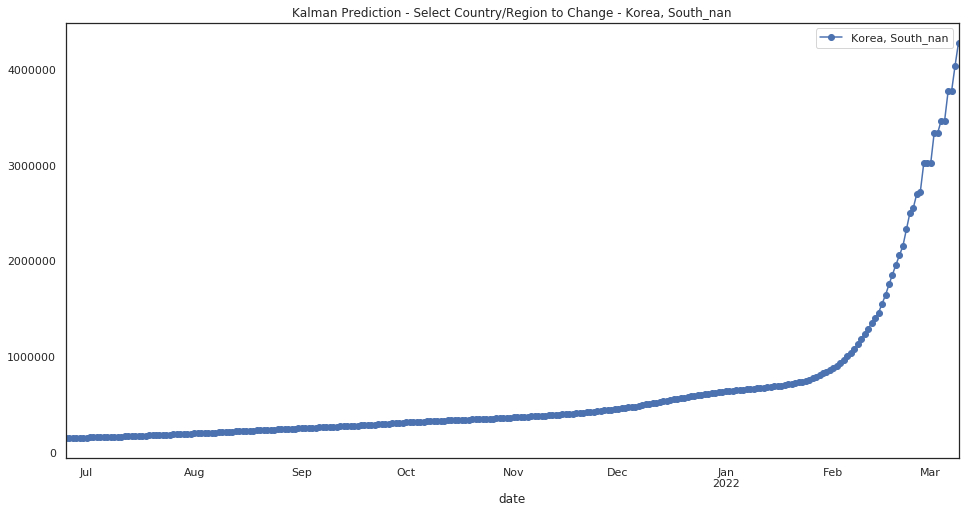

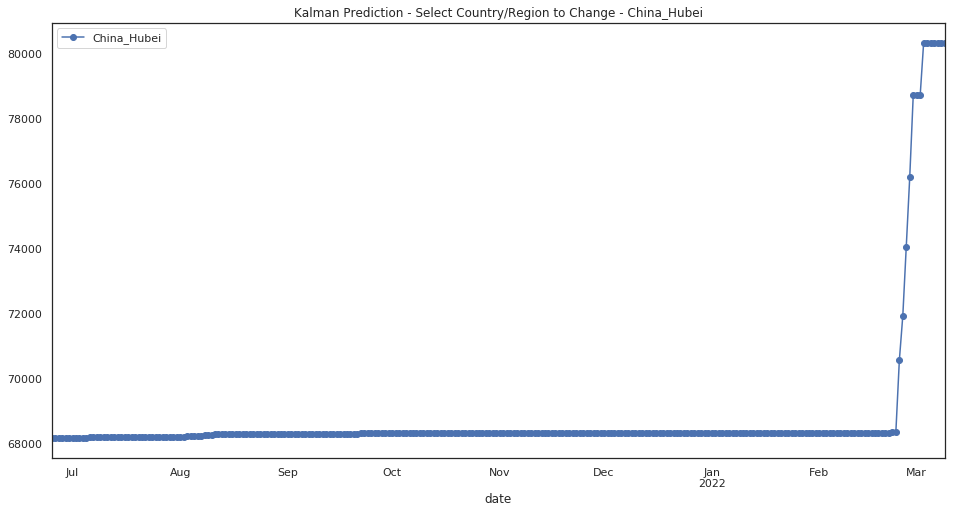

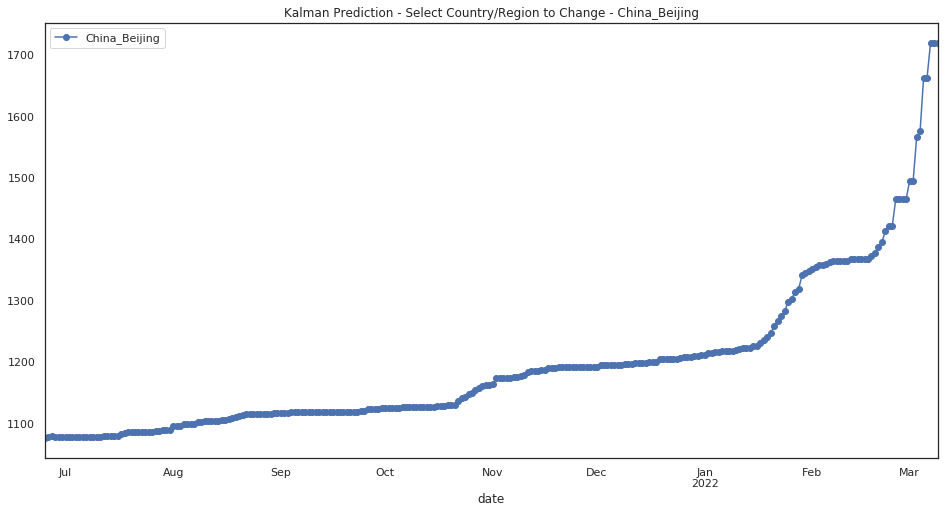

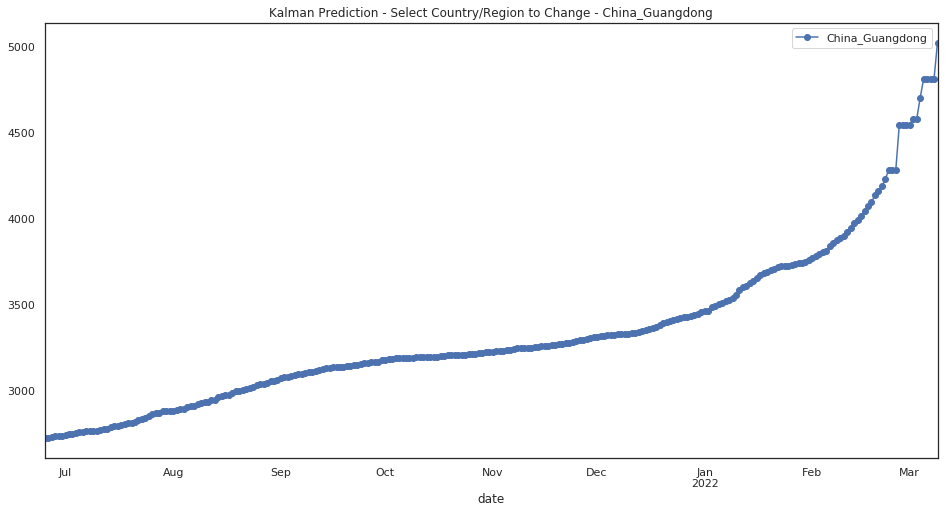

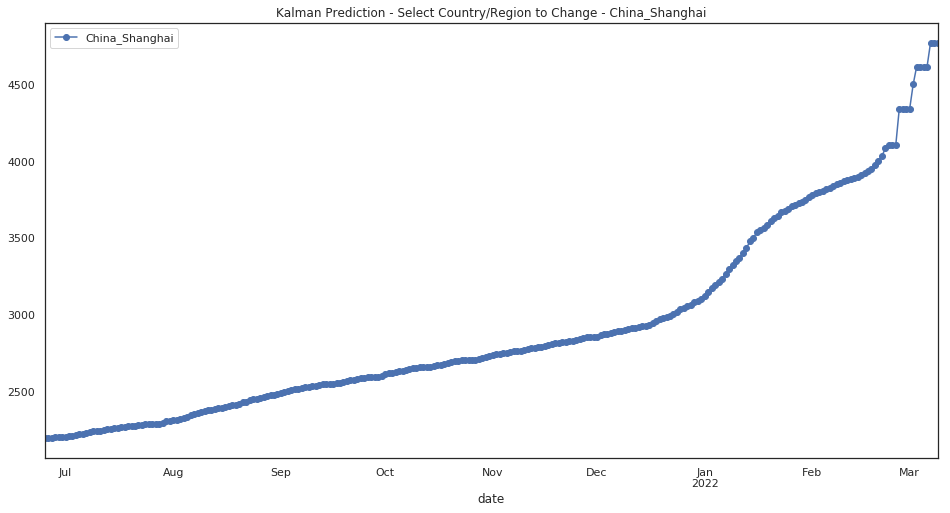

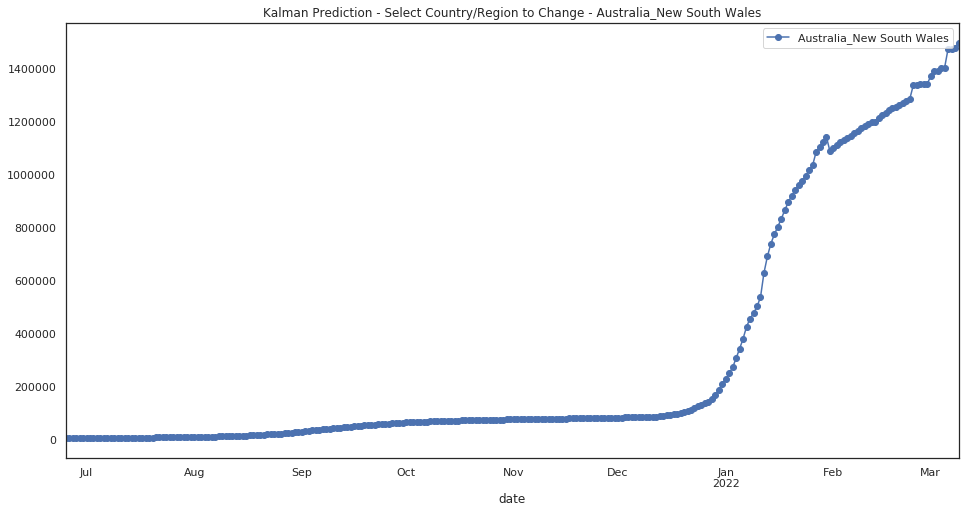

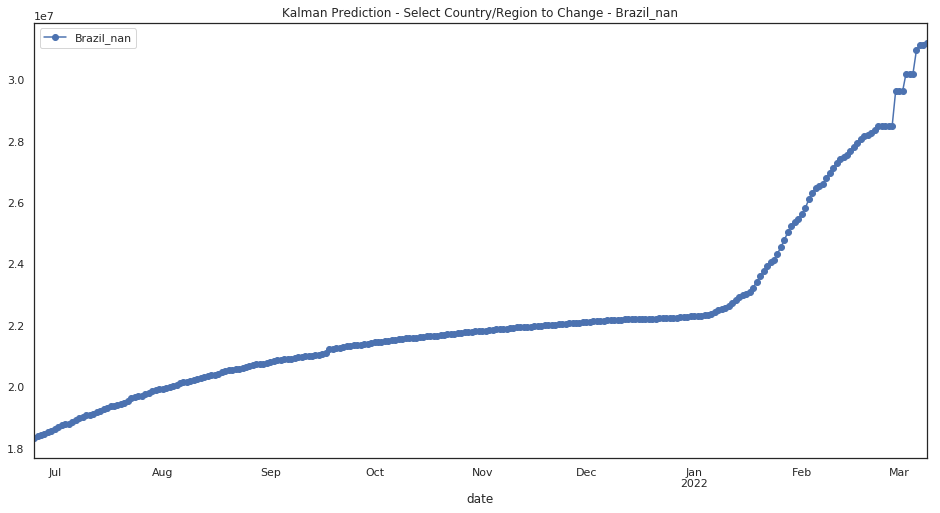

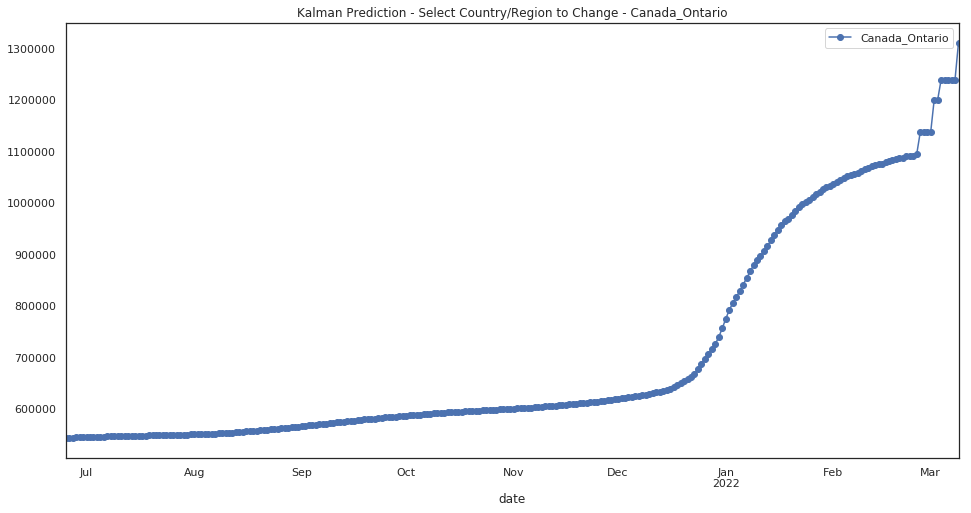

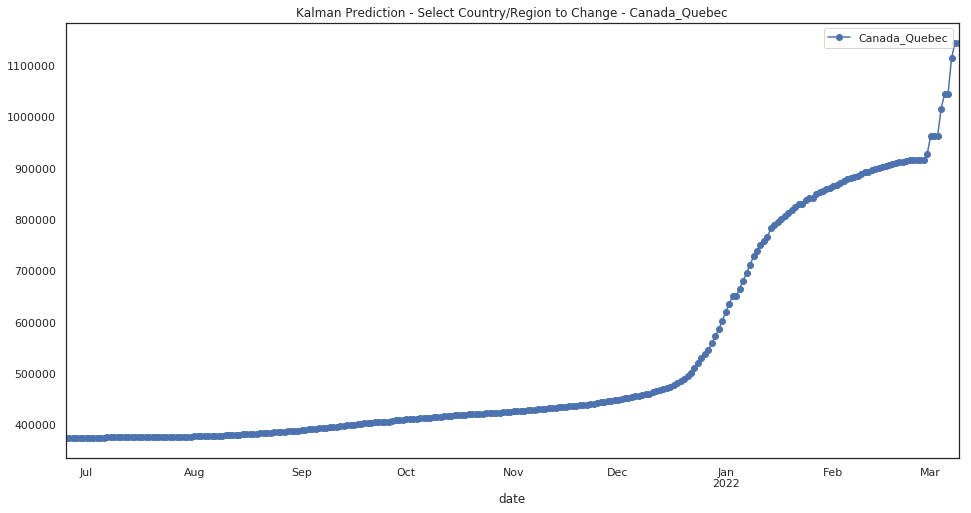

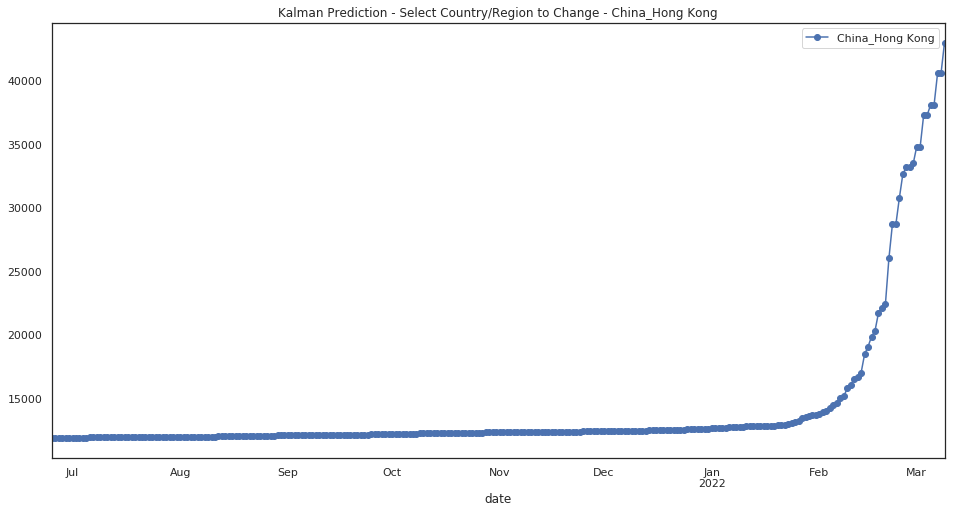

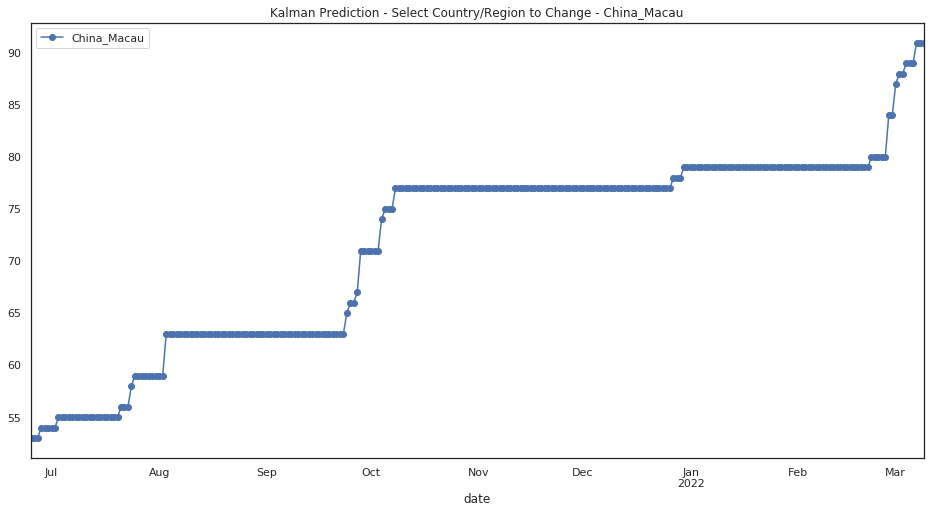

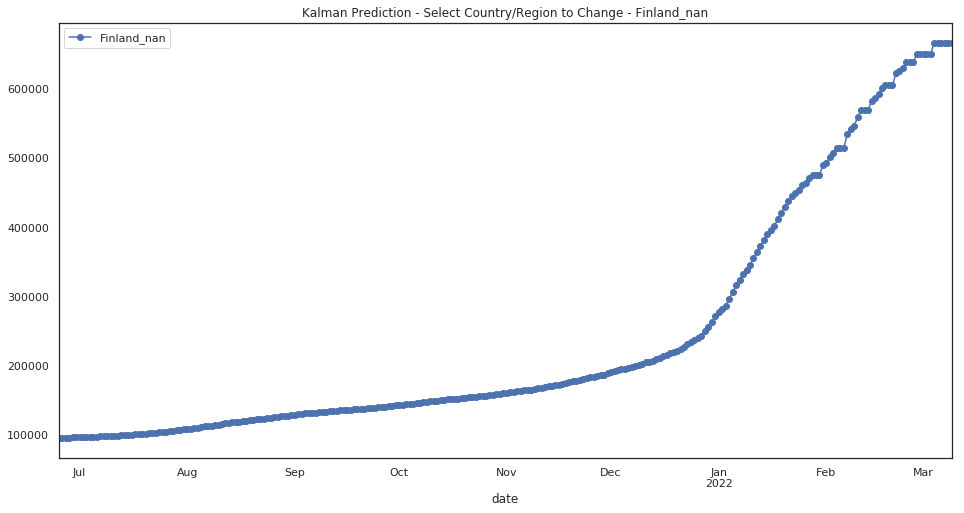

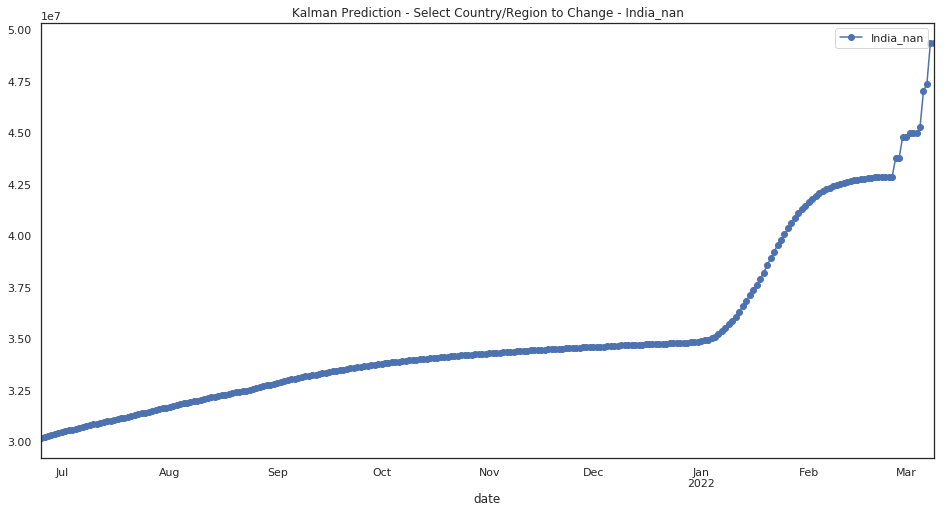

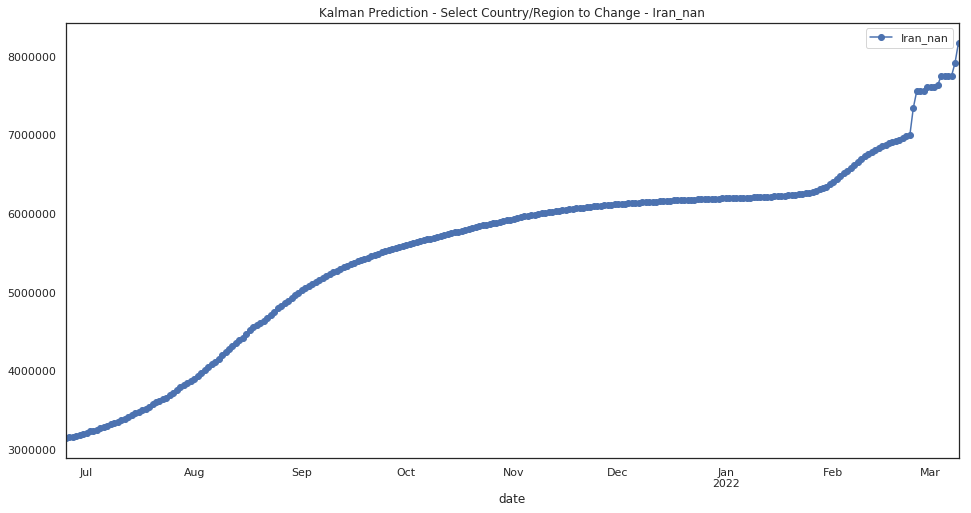

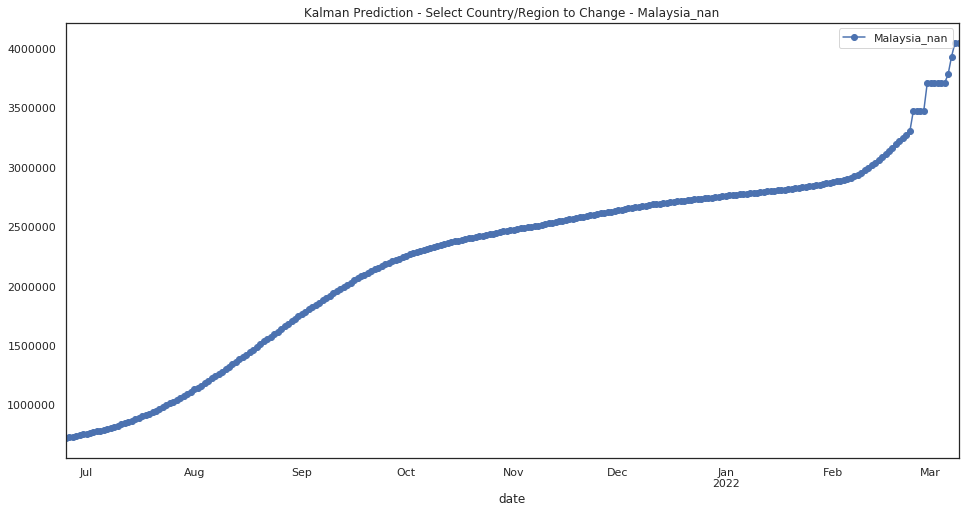

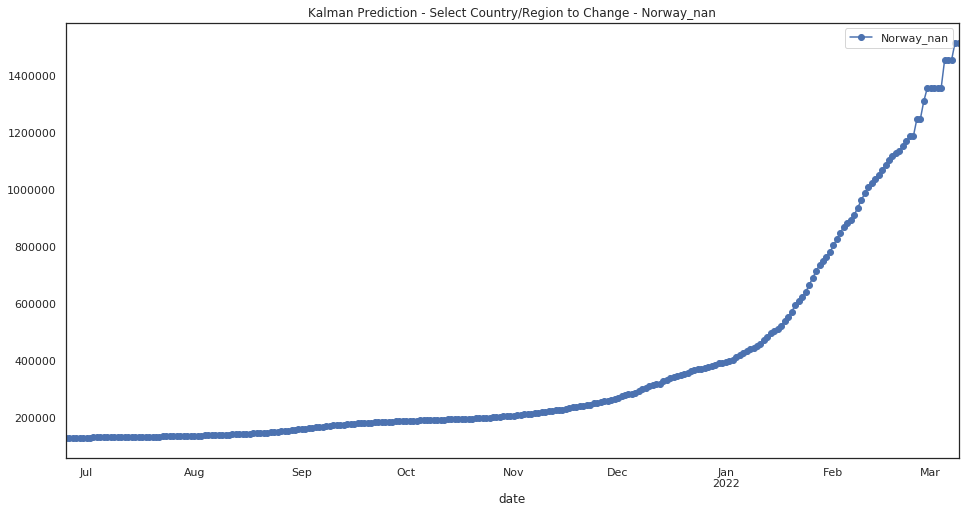

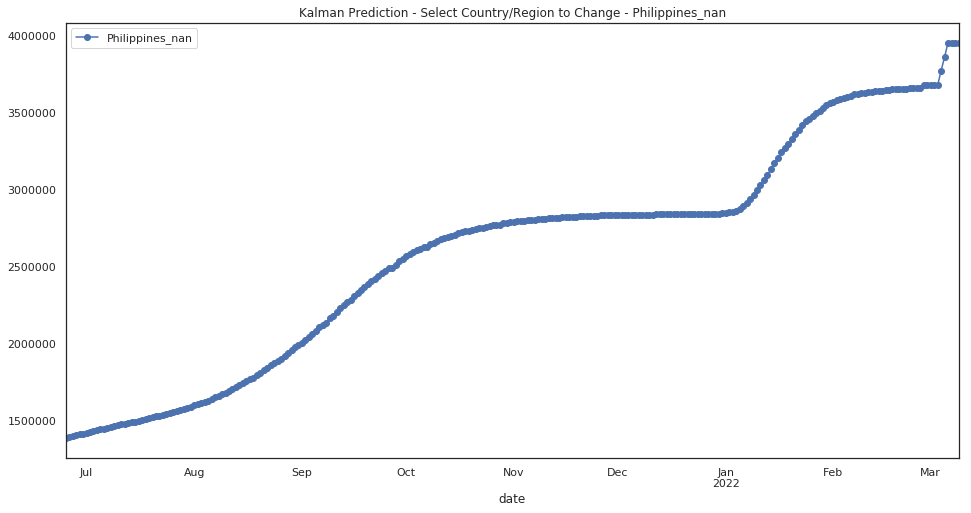

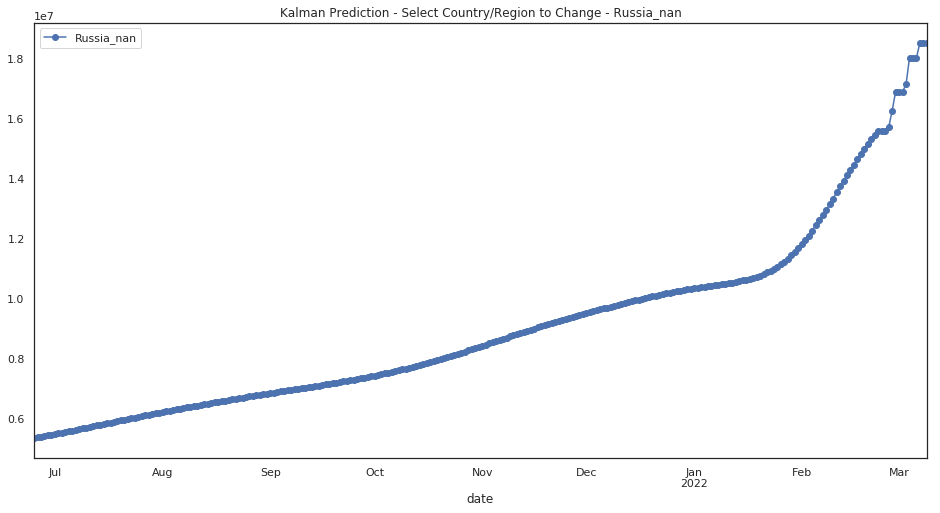

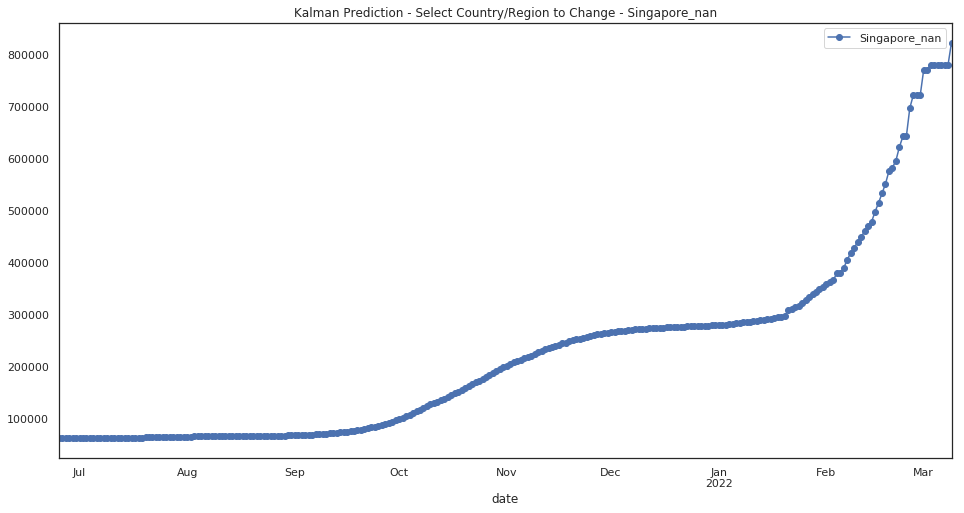

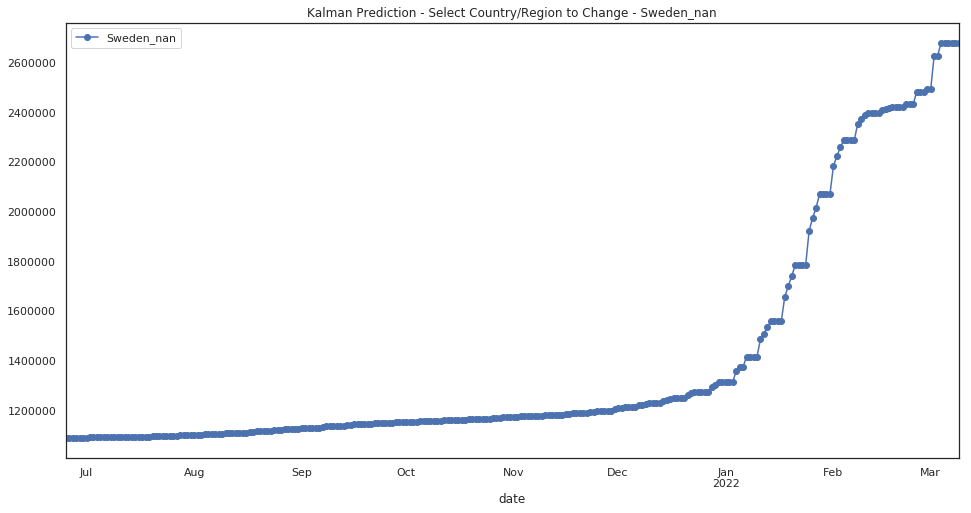

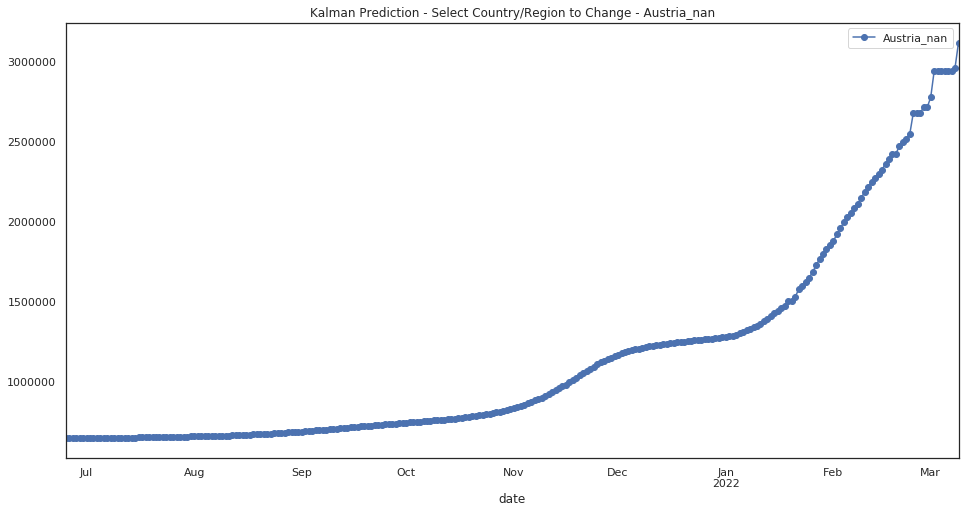

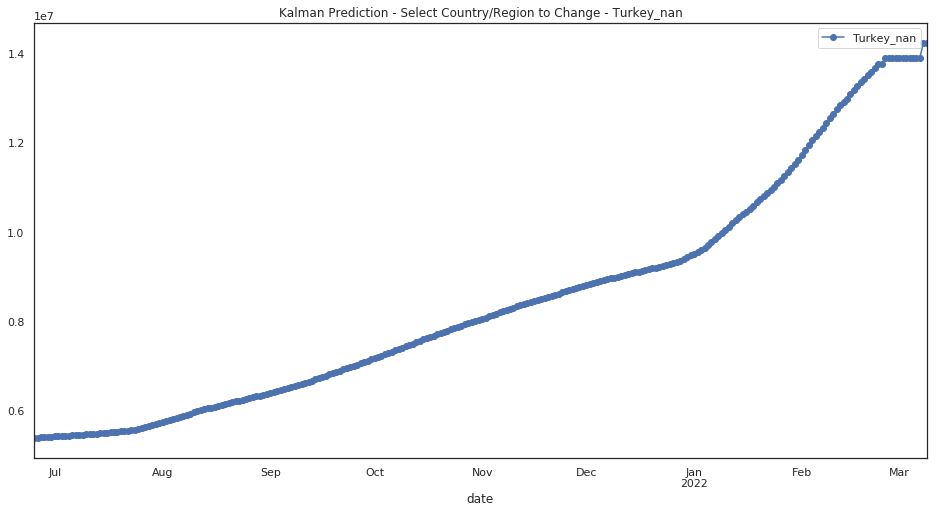

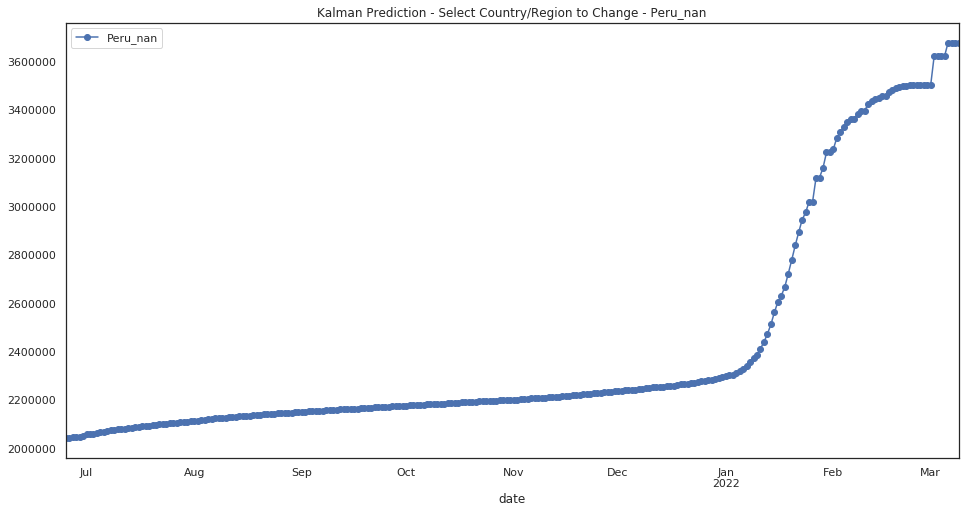

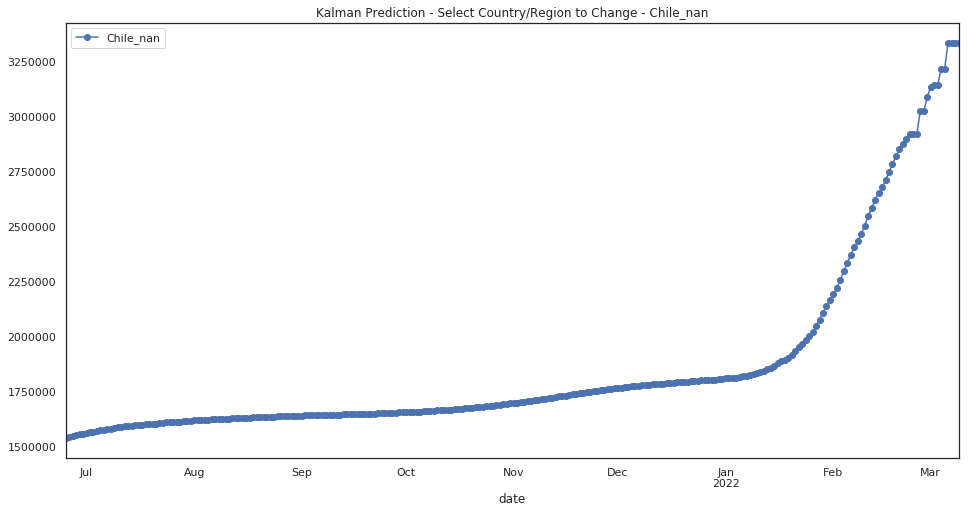

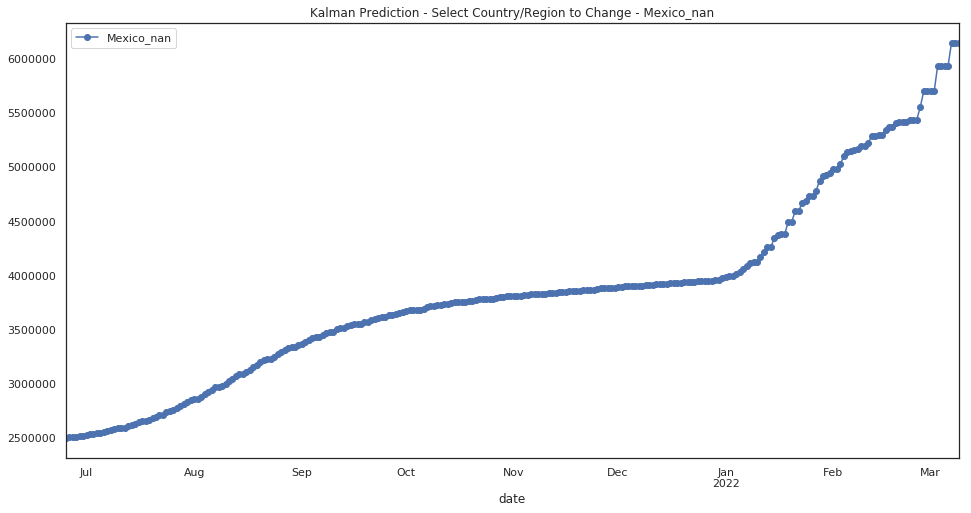

In [67]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [68]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2022-03-09 00:00:00
dtype: object


0  pred_confirmed
United States_nan                                   NaN      94149534.0
India_nan                                           NaN      49393429.0
Brazil_nan                                          NaN      31219791.0
France_nan                                          NaN      25534443.0
United Kingdom_nan                                  NaN      21089474.0
Russia_nan                                          NaN      18520206.0
Germany_nan                                         NaN      15648773.0
Italy_nan                                           NaN      14814429.0
Turkey_nan                                          NaN      14239074.0
Spain_nan                                           NaN      12625456.0
Argentina_nan                                       NaN      11332336.0
Iran_nan                                            NaN       8174000.0
Netherlands_nan                                     NaN       7514424.0
Poland_nan                                          NaN       7146652.0
Colombia_nan                                        NaN       6981333.0
Indonesia_nan                                       NaN       6560109.0
Mexico_nan                                          NaN       6150046.0
Ukraine_nan                                         NaN       5805831.0
Japan_nan                                           NaN       5747074.0
South Africa_nan                                    NaN       4939730.0
Vietnam_nan                                         NaN       4541129.0
Korea, South_nan                                    NaN       4278151.0
Israel_nan                                          NaN       4230402.0
Malaysia_nan                                        NaN       4051121.0
Philippines_nan                                     NaN       3953419.0
Czechia_nan                                         NaN       3915498.0
Belgium_nan                                         NaN       3682656.0
Peru_nan                                            NaN       3678861.0
Portugal_nan                                        NaN       3517706.0
Denmark_nan                                         NaN       3466403.0
...                                                 ...             ...
Diamond Princess_nan                                NaN           750.0
China_Chongqing                                     NaN           678.0
China_Jilin                                         NaN           669.0
Winter Olympics 2022_nan                            NaN           641.0
France_Wallis and Futuna                            NaN           551.0
Tonga_nan                                           NaN           539.0
China_Gansu                                         NaN           404.0
China_Shanxi                                        NaN           318.0
United Kingdom_Montserrat                           NaN           233.0
China_Hainan                                        NaN           214.0
China_Guizhou                                       NaN           179.0
China_Ningxia                                       NaN           153.0
United Kingdom_Falkland Islands (Malvinas)          NaN           120.0
China_Unknown                                       NaN           105.0
China_Macau                                         NaN            91.0
Samoa_nan                                           NaN            39.0
China_Qinghai                                       NaN            36.0
Holy See_nan                                        NaN            31.0
Vanuatu_nan                                         NaN            31.0
Canada_Grand Princess                               NaN            16.0
Canada_Repatriated Travellers                       NaN            13.0
Antarctica_nan                                      NaN            12.0
MS Zaandam_nan                                      NaN             9.0
Marshall Islands_nan                                NaN             7.0
United Kingdom_Saint H

In [69]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [70]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [71]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [72]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [73]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [74]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-06-25         166282.0     184239.0     188761.0      82386.0   
2021-06-26         167598.0     184242.0     189054.0      82386.0   
2021-06-27         113124.0     132509.0     138113.0      13882.0   
2021-06-28         114220.0     132512.0     138465.0      13882.0   
2021-06-29         116809.0     132513.0     138954.0      13882.0   
2021-06-30         118302.0     132514.0     139353.0      13900.0   
2021-07-01         119874.0     132521.0     139797.0      13911.0   
2021-07-02         121772.0     132523.0     140276.0      13918.0   
2021-07-03         124542.0     133697.0     142465.0      13918.0   
2021-07-04         125810.0     133699.0     142921.0      13918.0   
2021-07-05         126993.0     133701.0     143407.0      13918.0   
2021-07-06         128467.0     133707.0     143888.0      13918.0   
2021-07-07         130041.0     133719.0     144452.0      13991.0   
2021-07-08         131213.0     133728.0     145073.0      14021.0   
2021-07-09         132629.0     133742.0     145873.0      14050.0   
2021-07-10         133913.0     133750.0     146706.0      14075.0   
2021-07-11         134749.0     133755.0     147465.0      14075.0   
2021-07-12         135772.0     133759.0     148310.0      14075.0   
2021-07-13         137004.0     133769.0     149237.0      14155.0   
2021-07-14         137861.0     133778.0     150143.0      14167.0   
2021-07-15         139005.0     133790.0     151207.0      14167.0   
2021-07-16         140249.0     133807.0     152400.0      14239.0   
2021-07-17         141442.0     133826.0     153521.0      14273.0   
2021-07-18         141946.0     133846.0     154599.0      14273.0   
2021-07-19         142681.0     133858.0     155747.0      14273.0   
2021-07-20         143655.0     133895.0     157025.0      14359.0   
2021-07-21         144098.0     133922.0     158263.0      14379.0   
2021-07-22         144462.0     133952.0     159449.0      14379.0   
2021-07-23         144781.0     133984.0     160774.0      14464.0   
2021-07-24         145026.0     134008.0     162105.0      14498.0   
...                     ...          ...          ...          ...   
2022-02-09         169967.0     266870.0     261001.0      36808.0   
2022-02-10         170851.0     267546.0     261572.0      36989.0   
2022-02-11         171401.0     267563.0     262105.0      37074.0   
2022-02-12         171570.0     267905.0     262644.0      37140.0   
2022-02-13         171924.0     268528.0     263173.0      37140.0   
2022-02-14         172581.0     268879.0     263600.0      37140.0   
2022-02-15         172871.0     269023.0     263969.0      37277.0   
2022-02-16         172918.0     269430.0     264399.0      37361.0   
2022-02-17         173081.0     269913.0     264796.0      37452.0   
2022-02-18         173305.0     270205.0     265111.0      37522.0   
2022-02-19         173419.0     270467.0     265361.0      37589.0   
2022-02-20         173649.0     270745.0     265487.0      37589.0   
2022-02-21         173946.0     270952.0     265603.0      37589.0   
2022-02-22         174233.0     271038.0     265789.0      37589.0   
2022-02-23         174437.0     271247.0     265938.0      37820.0   
2022-02-24         175364.0     271368.0     265959.0      37901.0   
2022-02-25         175675.0     271284.0     265935.0      37901.0   
2022-02-26         175446.0     271302.0     270443.0      37987.0   
2022-02-27         175510.0     273666.0     276894.0      37987.0   
2022-02-28         175526.0     274944.0     277182.0      37987.0   
2022-03-01         182688.0     273944.0     275455.0      37987.0   
2022-03-02         185404.0     273950.0     275374.0      38442.0   
2022-03-03         183585.0     279562.0     286291.0      38754.0   
2022-03-04         184218.0     282610.0     294958.0      38754.0   
2022-03-05

In [75]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [76]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'France_nan',
 'United Kingdom_nan',
 'Russia_nan',
 'Germany_nan',
 'Italy_nan',
 'Turkey_nan',
 'Spain_nan',
 'Argentina_nan',
 'Iran_nan',
 'Netherlands_nan',
 'Poland_nan',
 'Colombia_nan',
 'Indonesia_nan',
 'Mexico_nan',
 'Ukraine_nan',
 'Japan_nan',
 'South Africa_nan',
 'Vietnam_nan',
 'Korea, South_nan',
 'Israel_nan',
 'Malaysia_nan',
 'Philippines_nan',
 'Czechia_nan',
 'Belgium_nan',
 'Peru_nan',
 'Portugal_nan',
 'Denmark_nan',
 'Chile_nan',
 'Thailand_nan',
 'Switzerland_nan',
 'Austria_nan',
 'Romania_nan',
 'Greece_nan',
 'Sweden_nan',
 'Slovakia_nan',
 'Iraq_nan',
 'Serbia_nan',
 'Bangladesh_nan',
 'Georgia_nan',
 'Hungary_nan',
 'Jordan_nan',
 'Pakistan_nan',
 'Kazakhstan_nan',
 'Norway_nan',
 'Ireland_nan',
 'Australia_New South Wales',
 'Bulgaria_nan',
 'Morocco_nan',
 'Canada_Ontario',
 'Cuba_nan',
 'Australia_Victoria',
 'Canada_Quebec',
 'Lebanon_nan',
 'Mongolia_nan',
 'Tunisia_nan',
 'Croatia_nan',
 'Uruguay_n

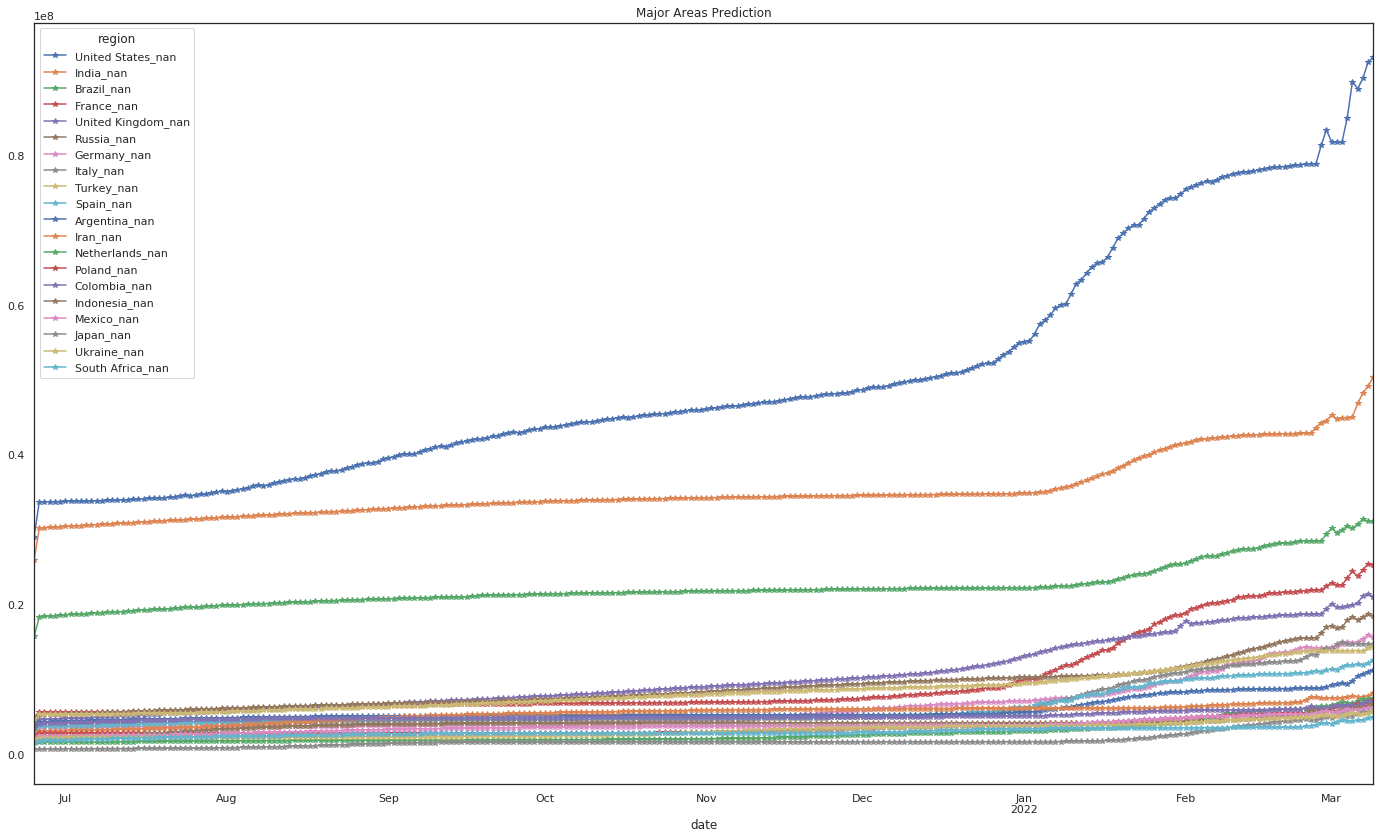

In [77]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

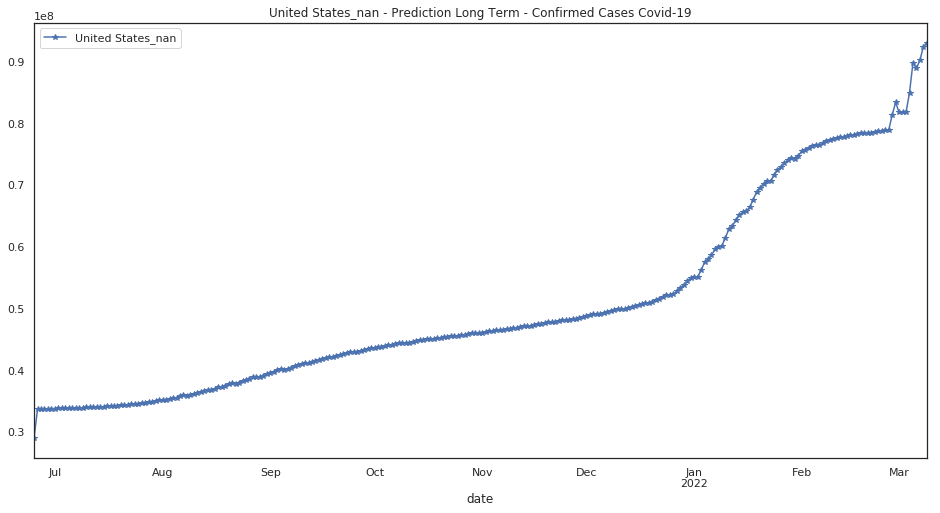

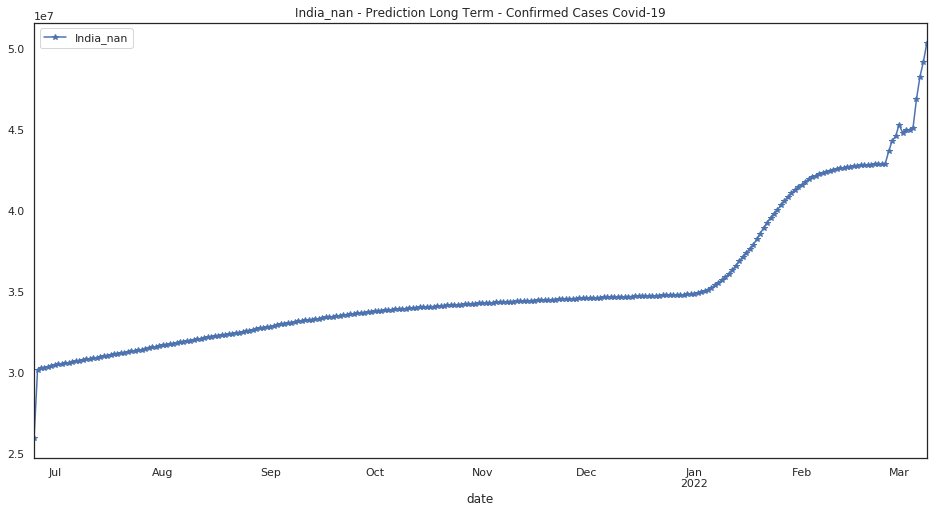

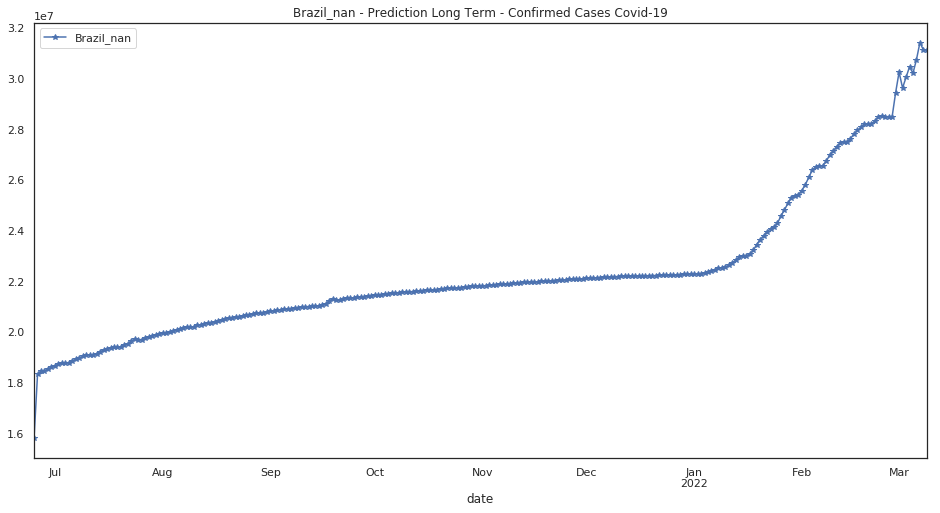

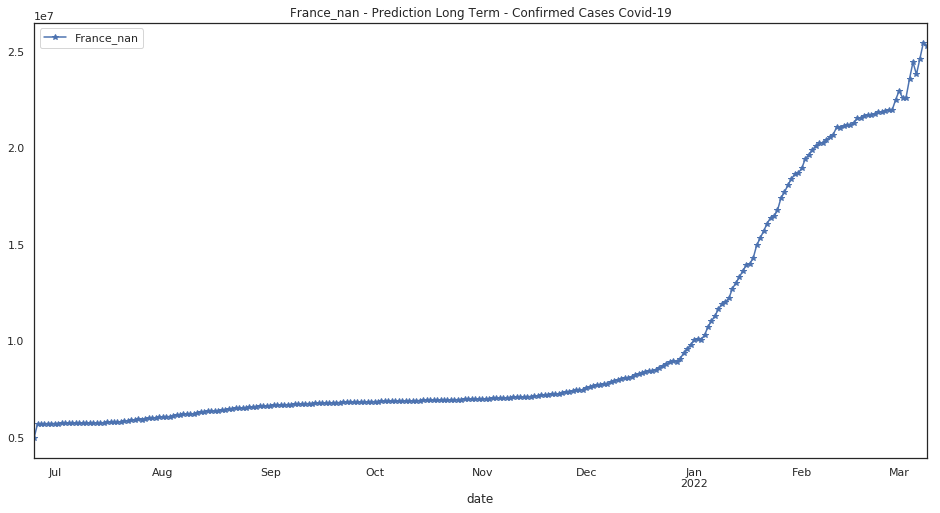

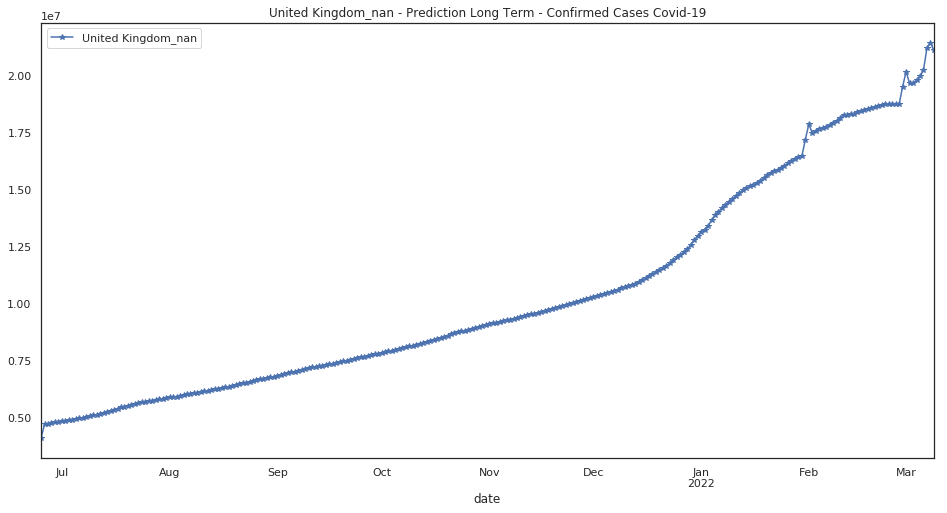

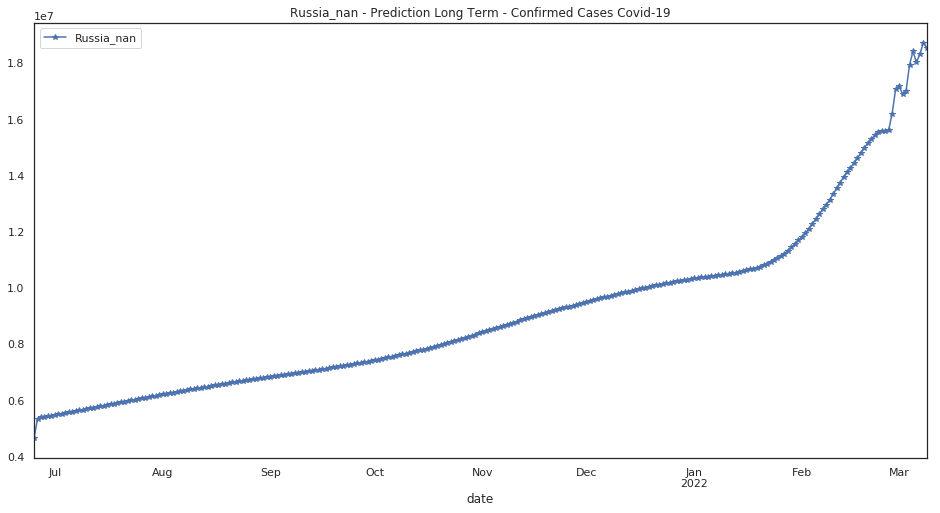

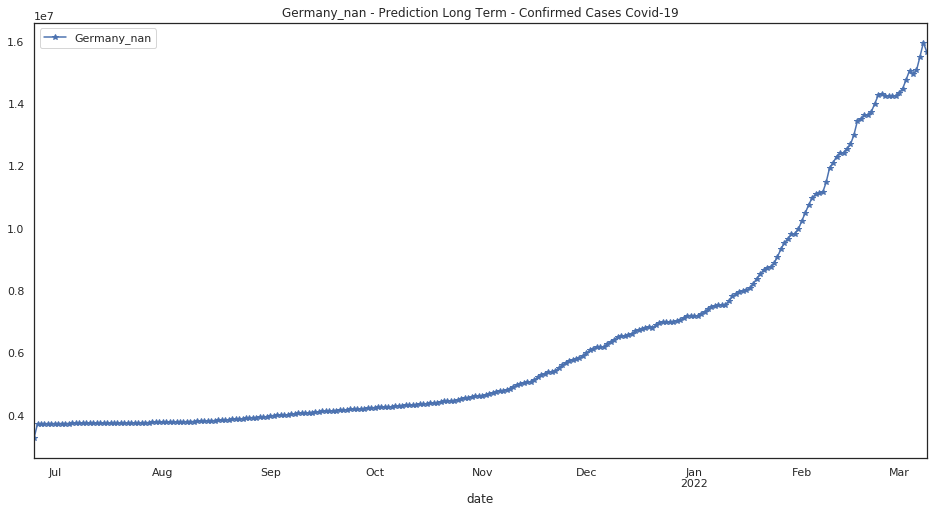

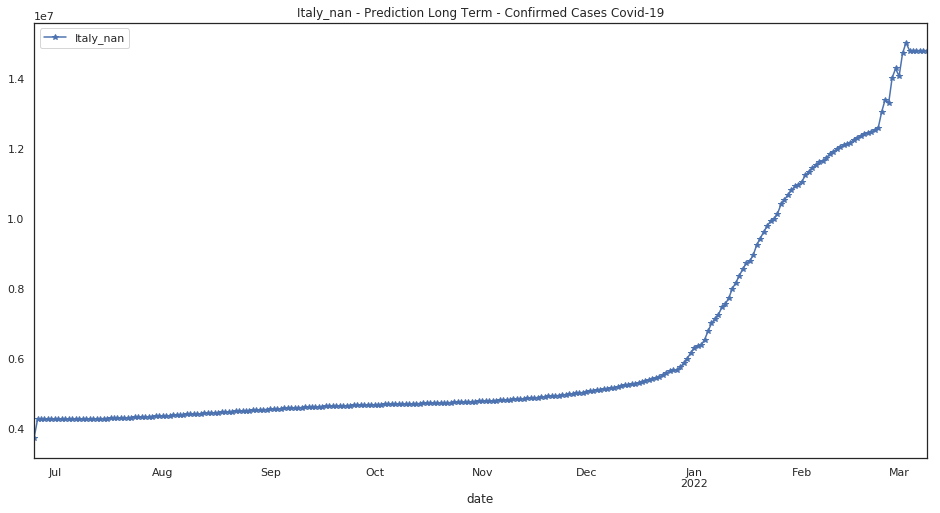

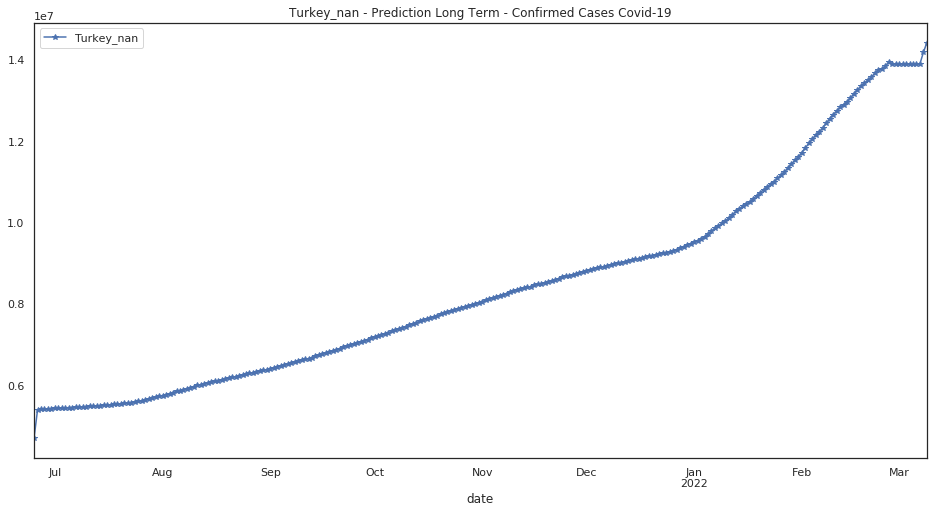

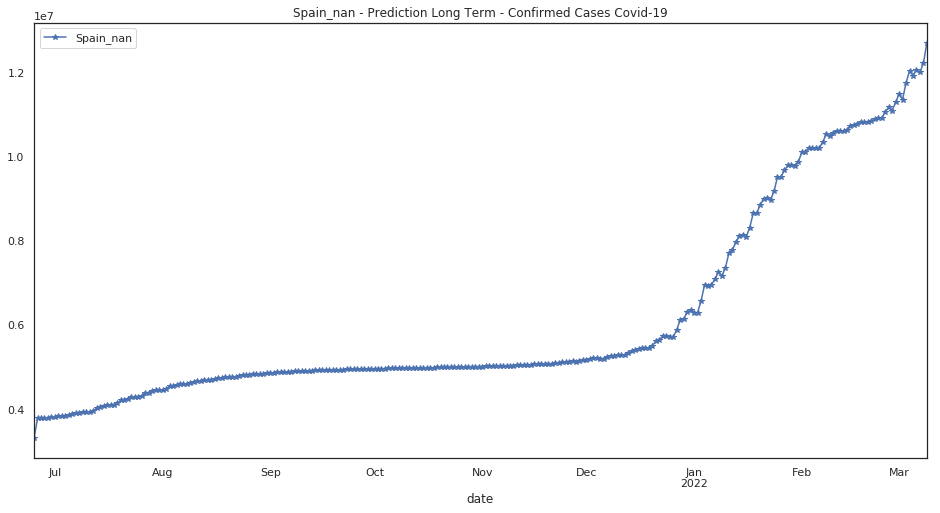

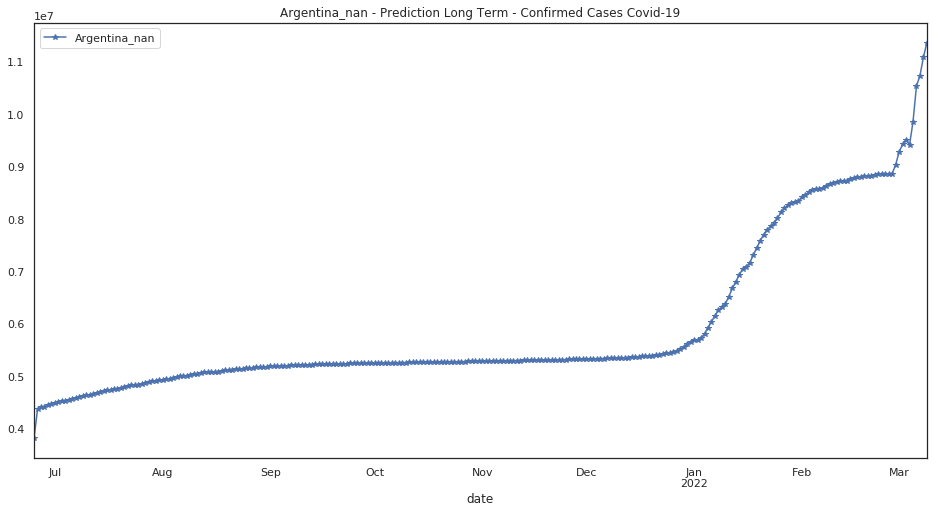

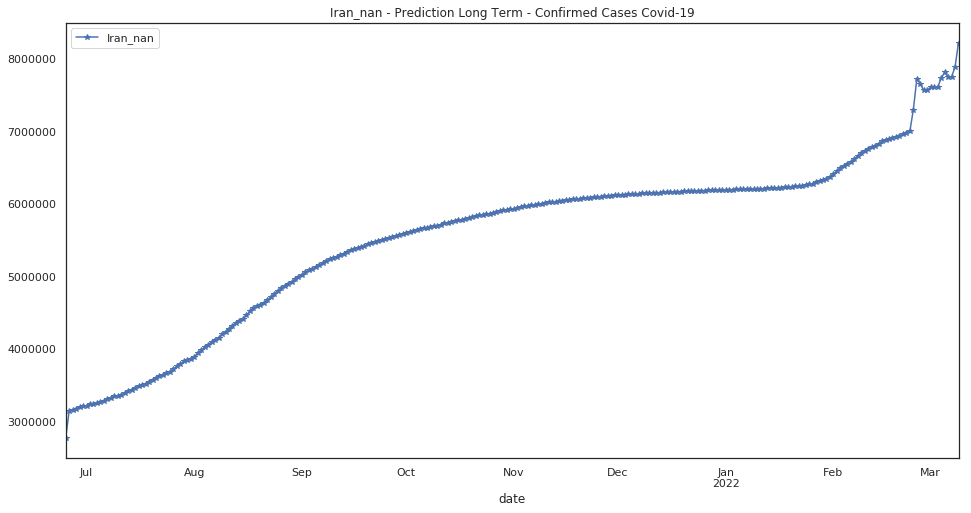

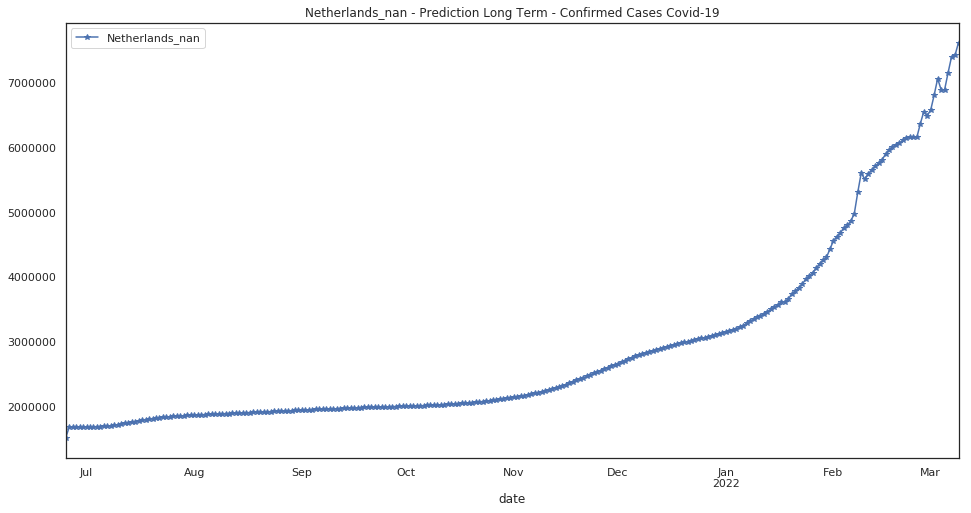

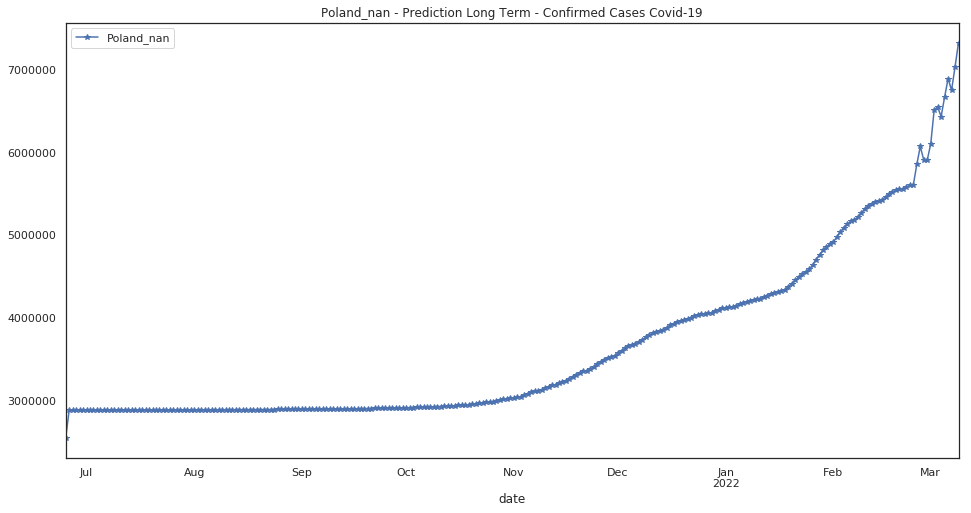

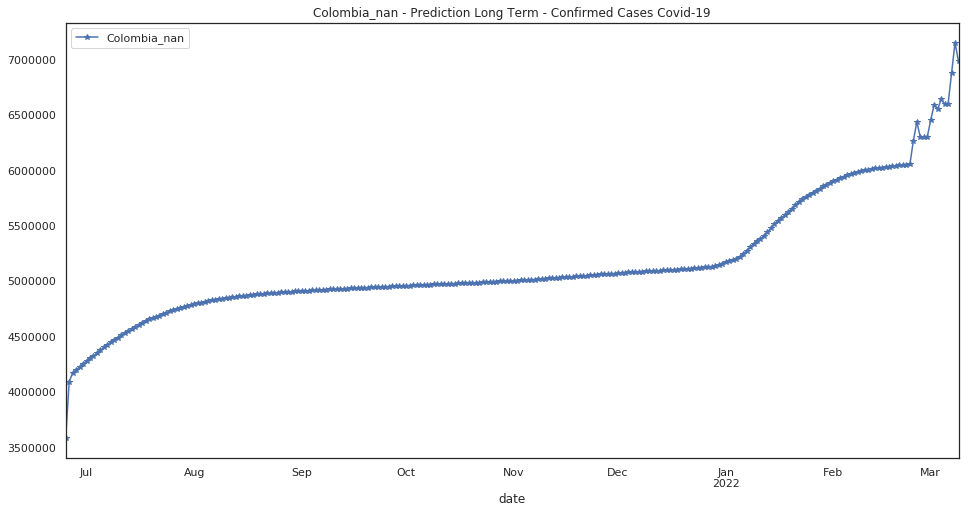

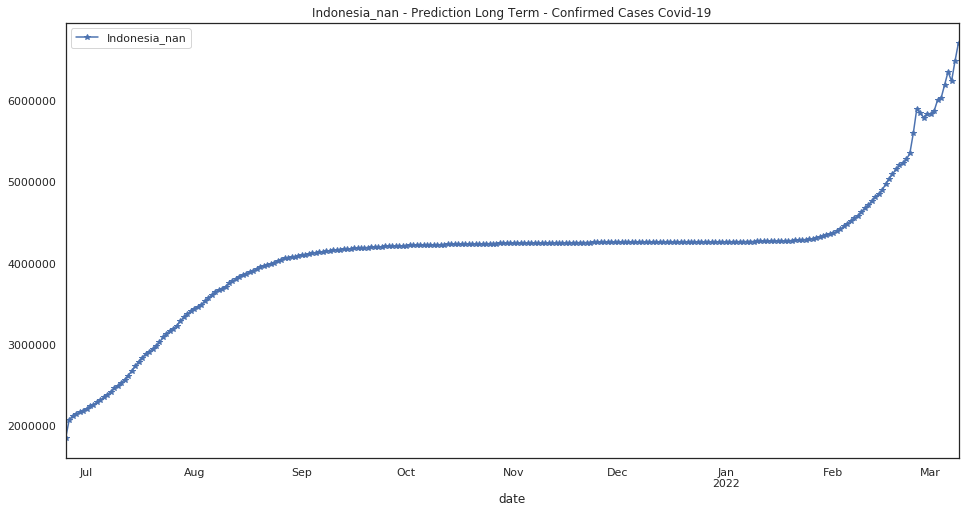

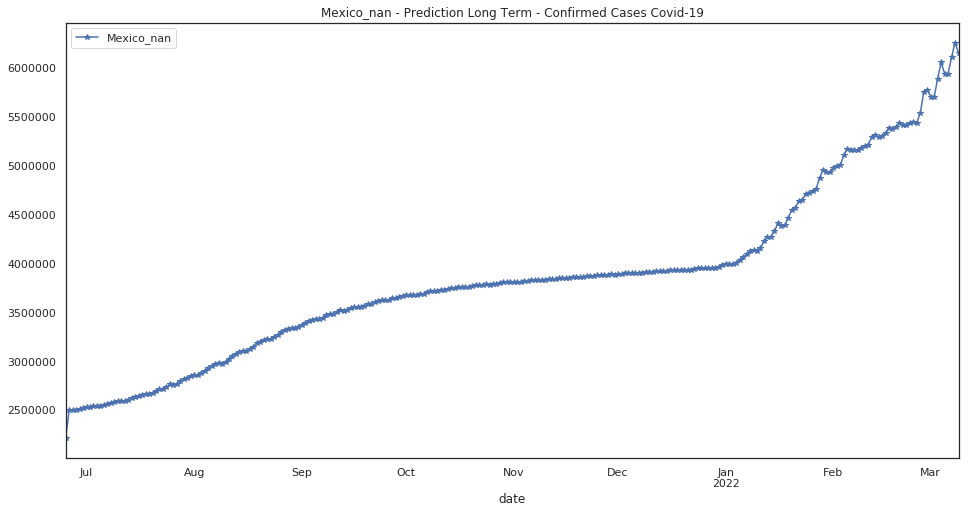

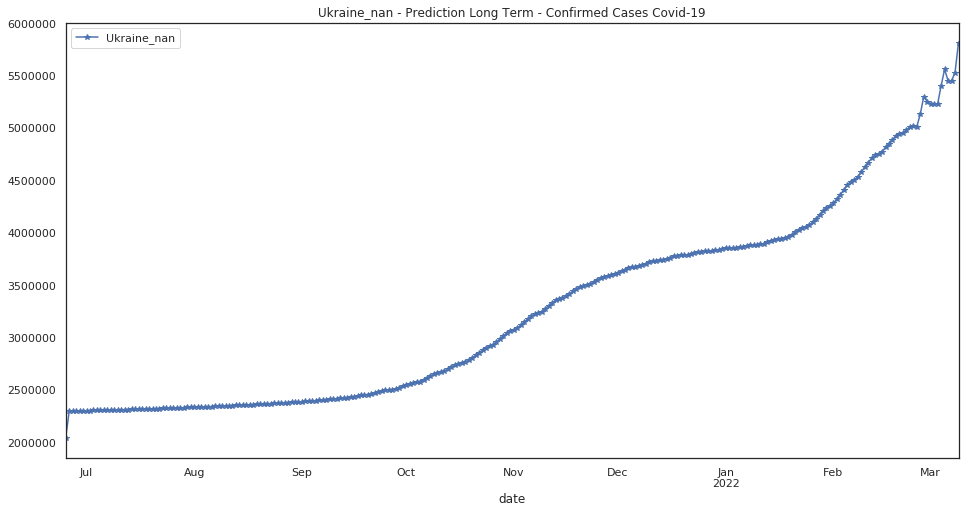

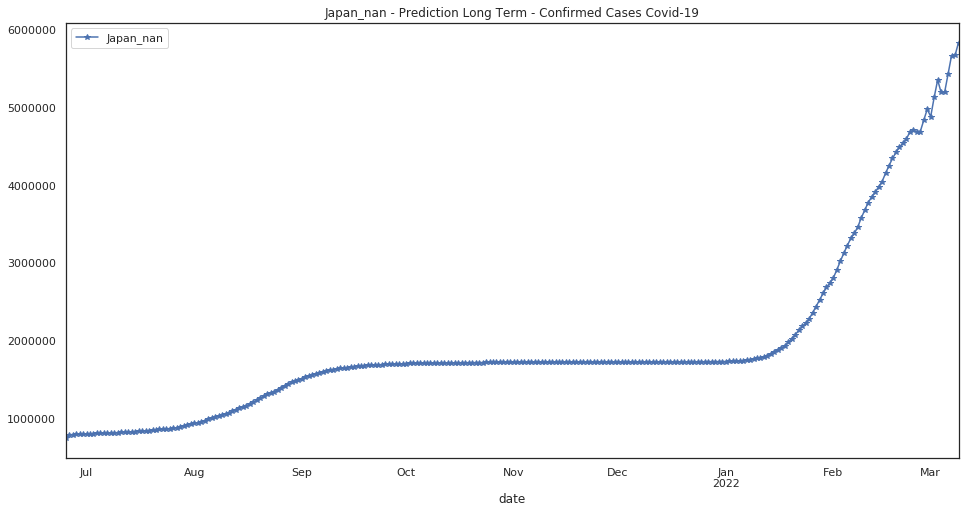

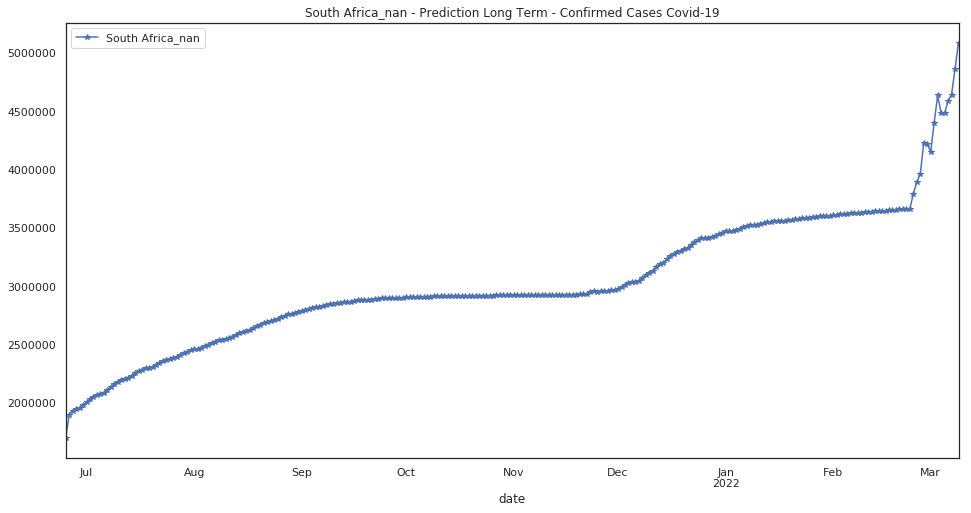

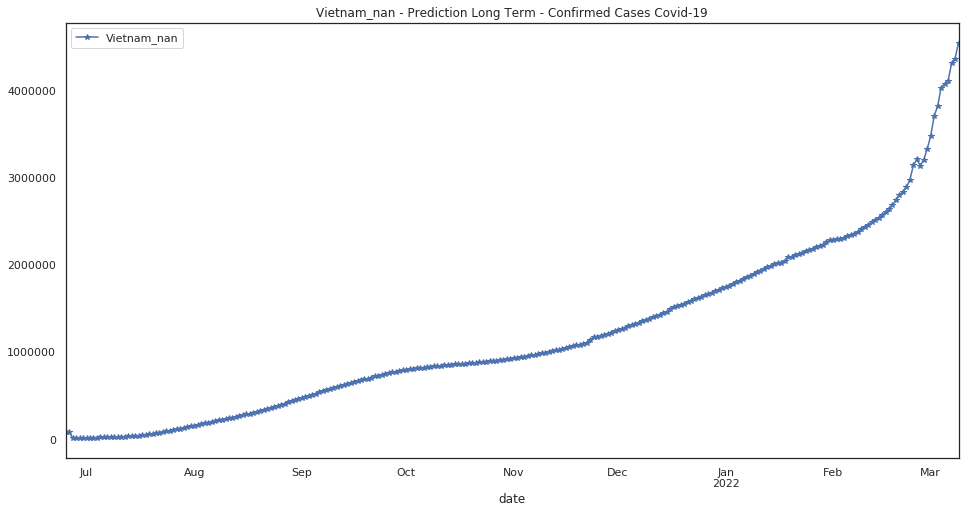

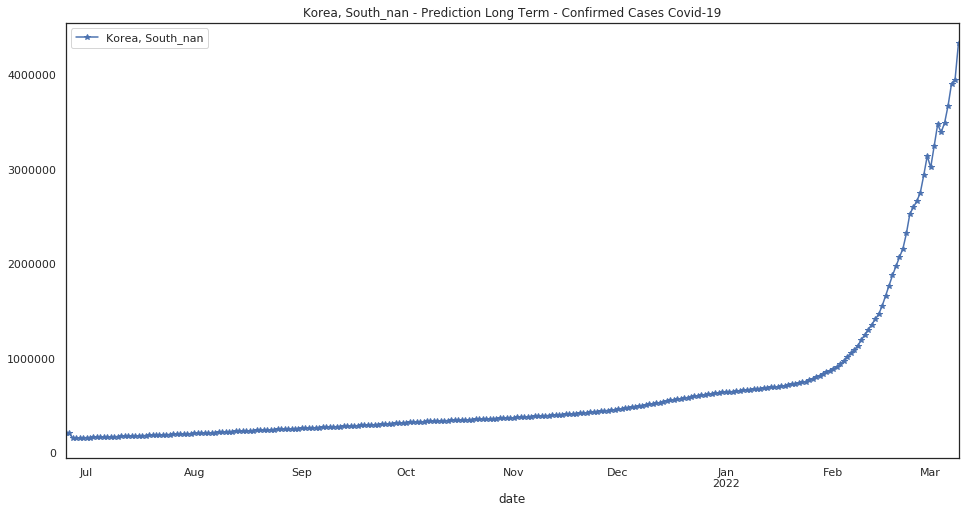

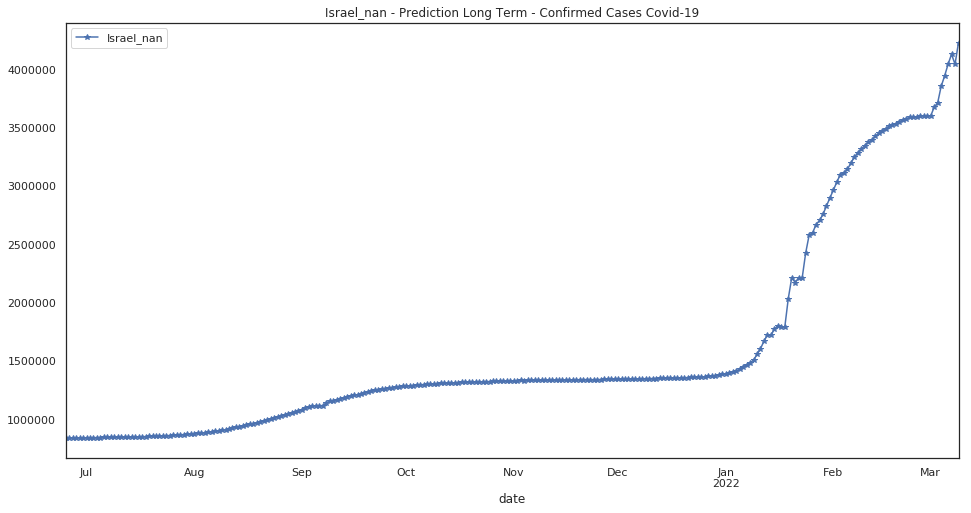

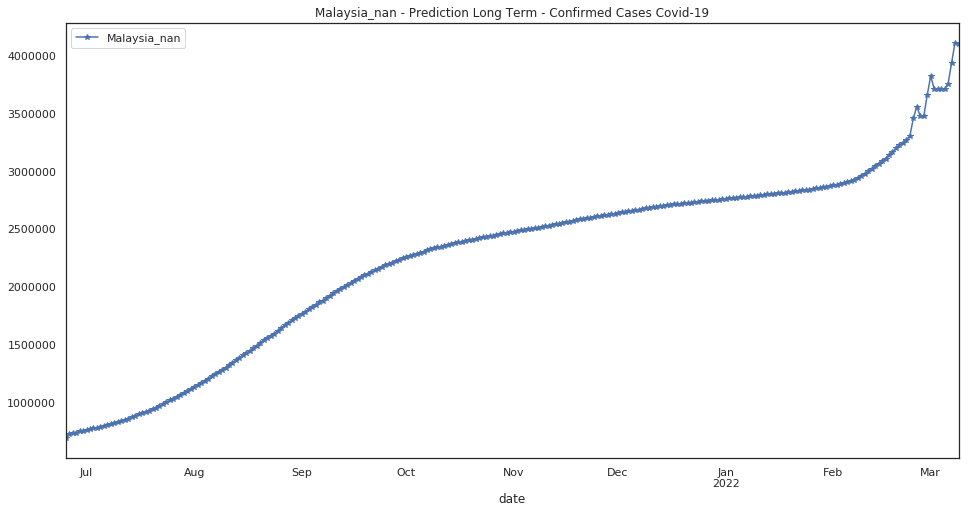

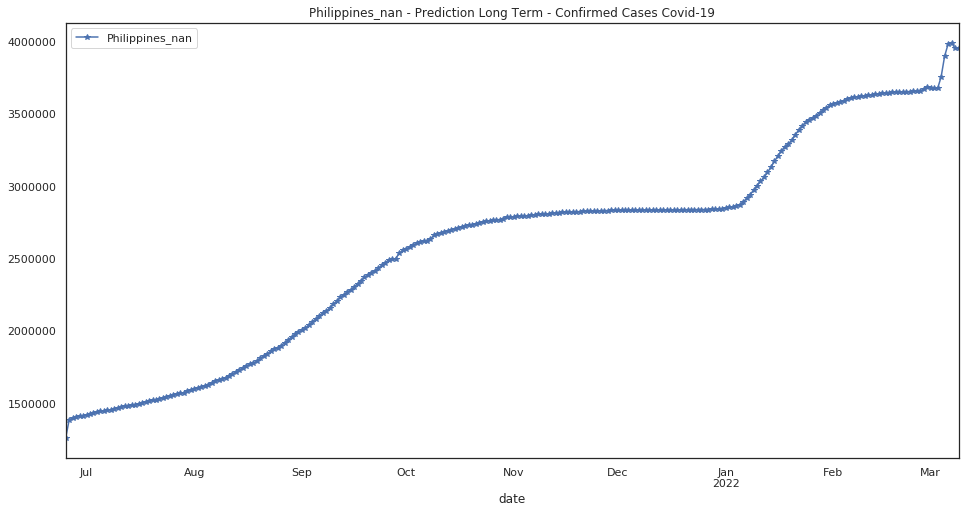

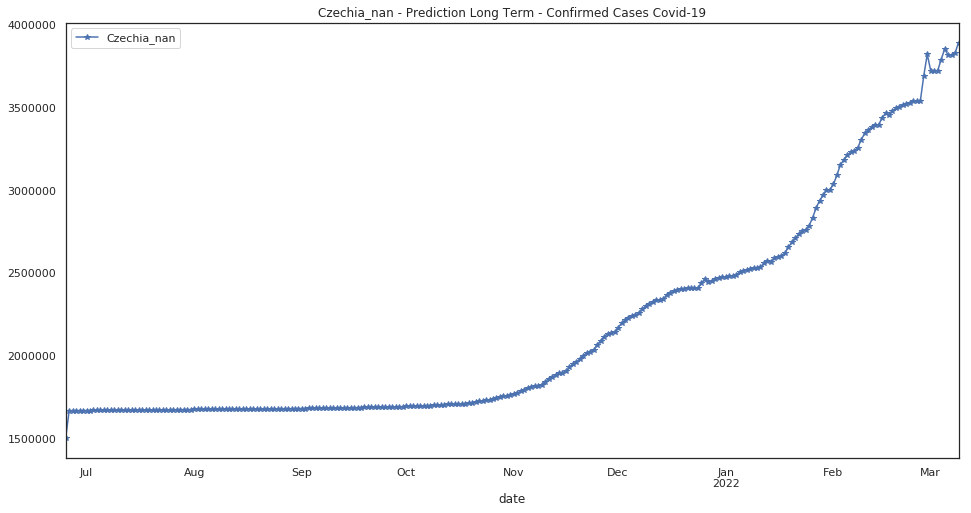

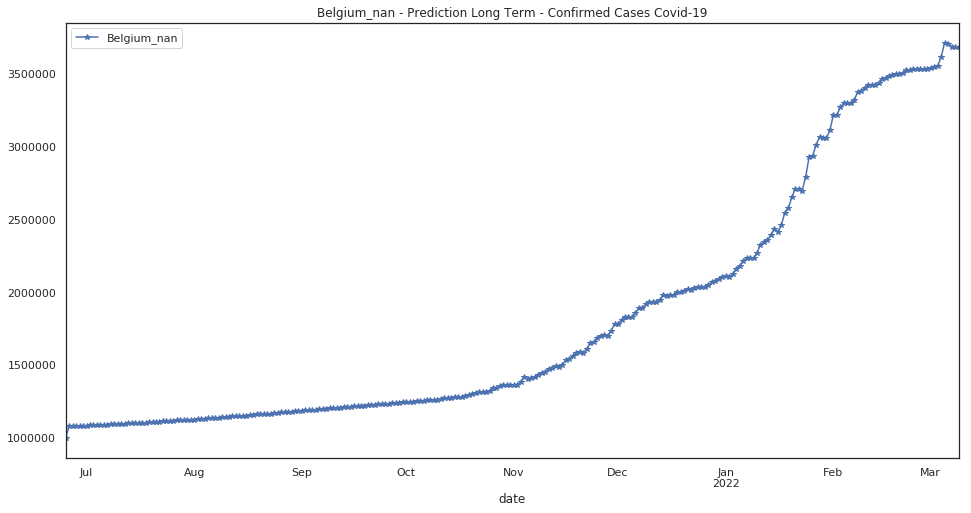

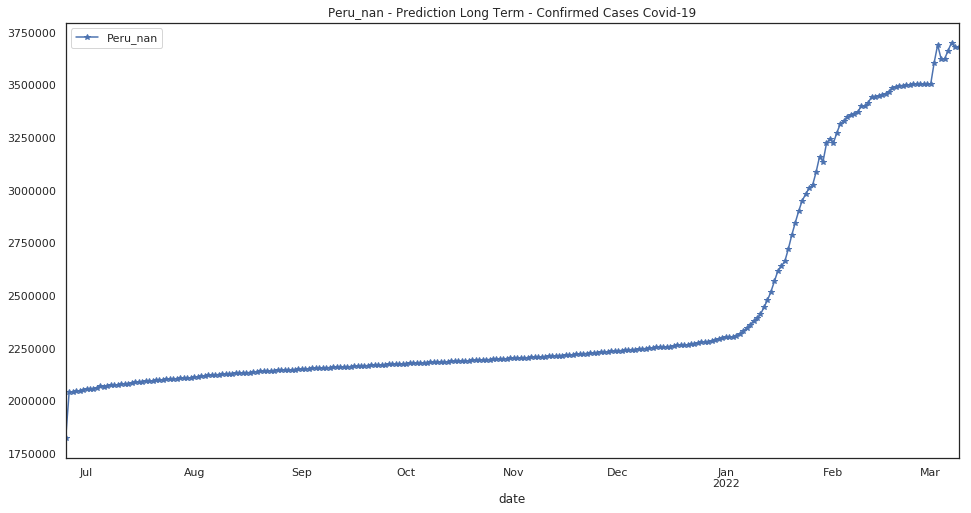

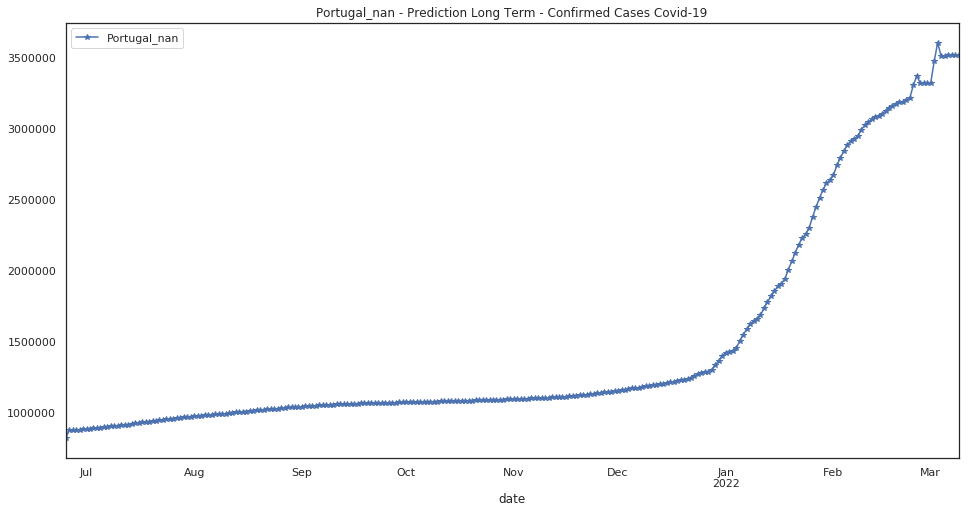

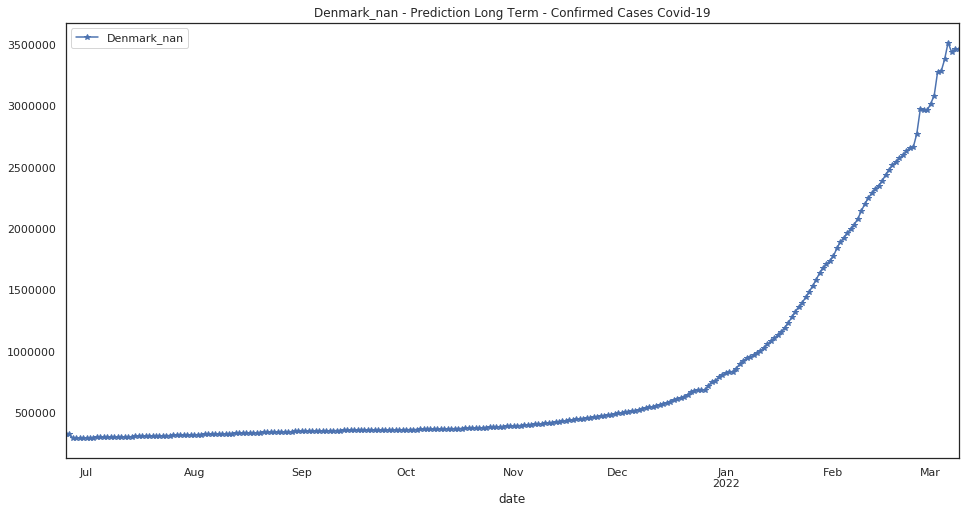

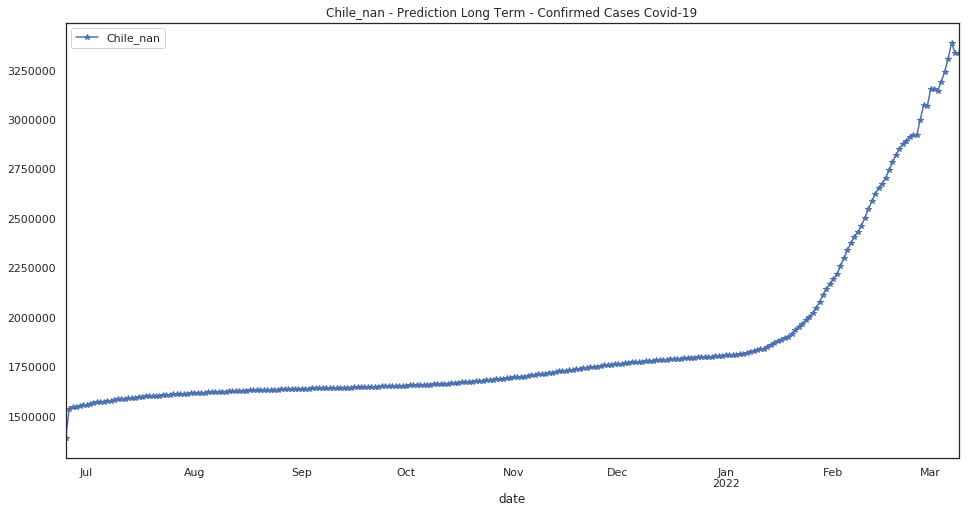

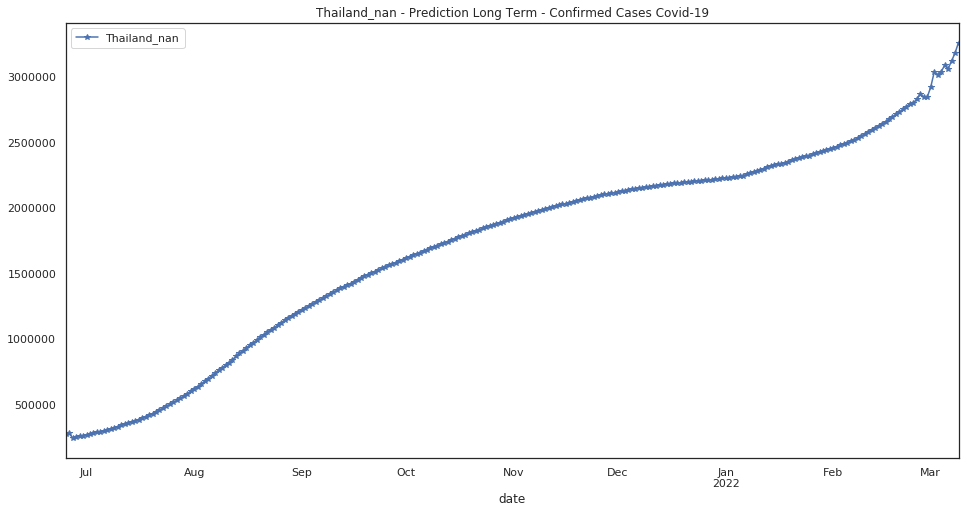

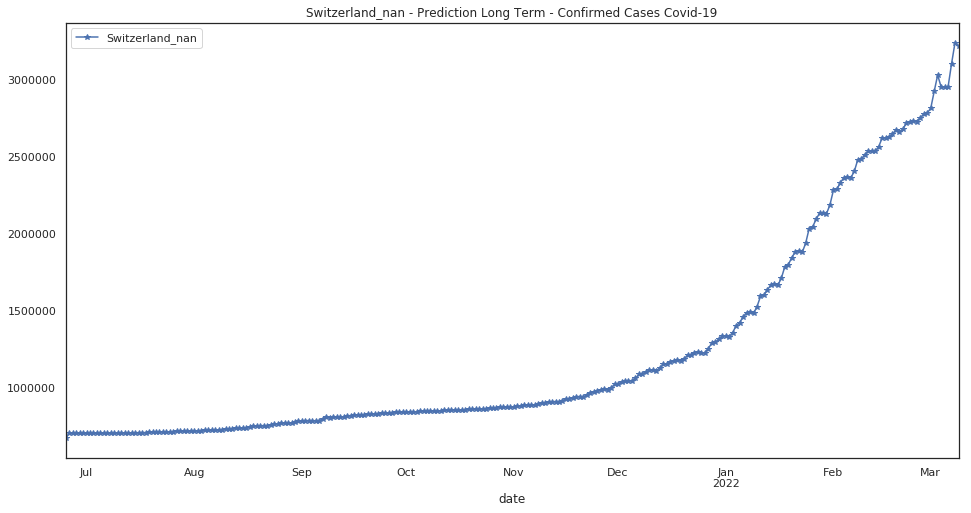

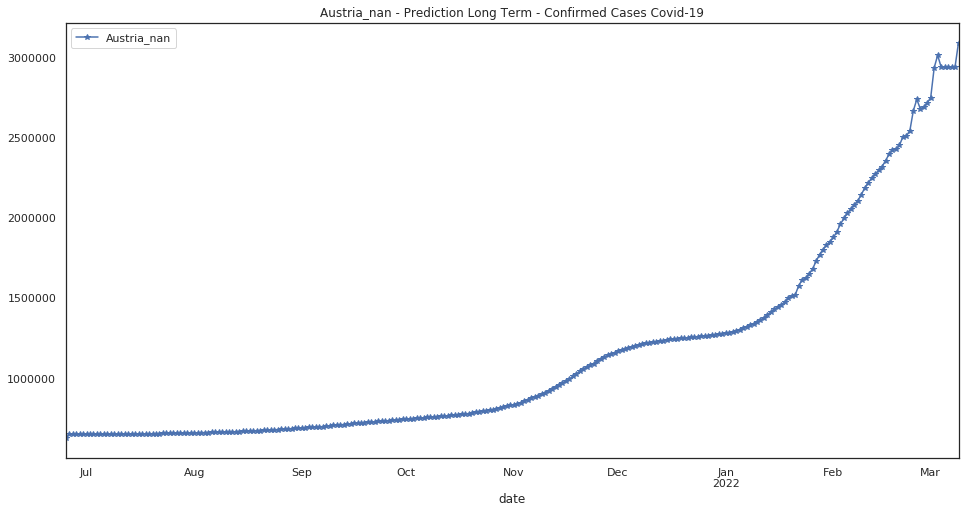

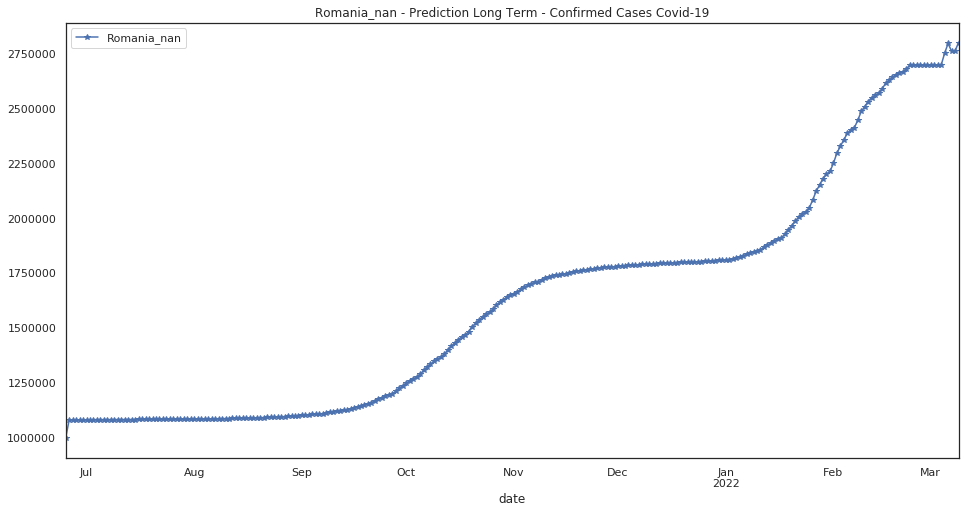

In [78]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

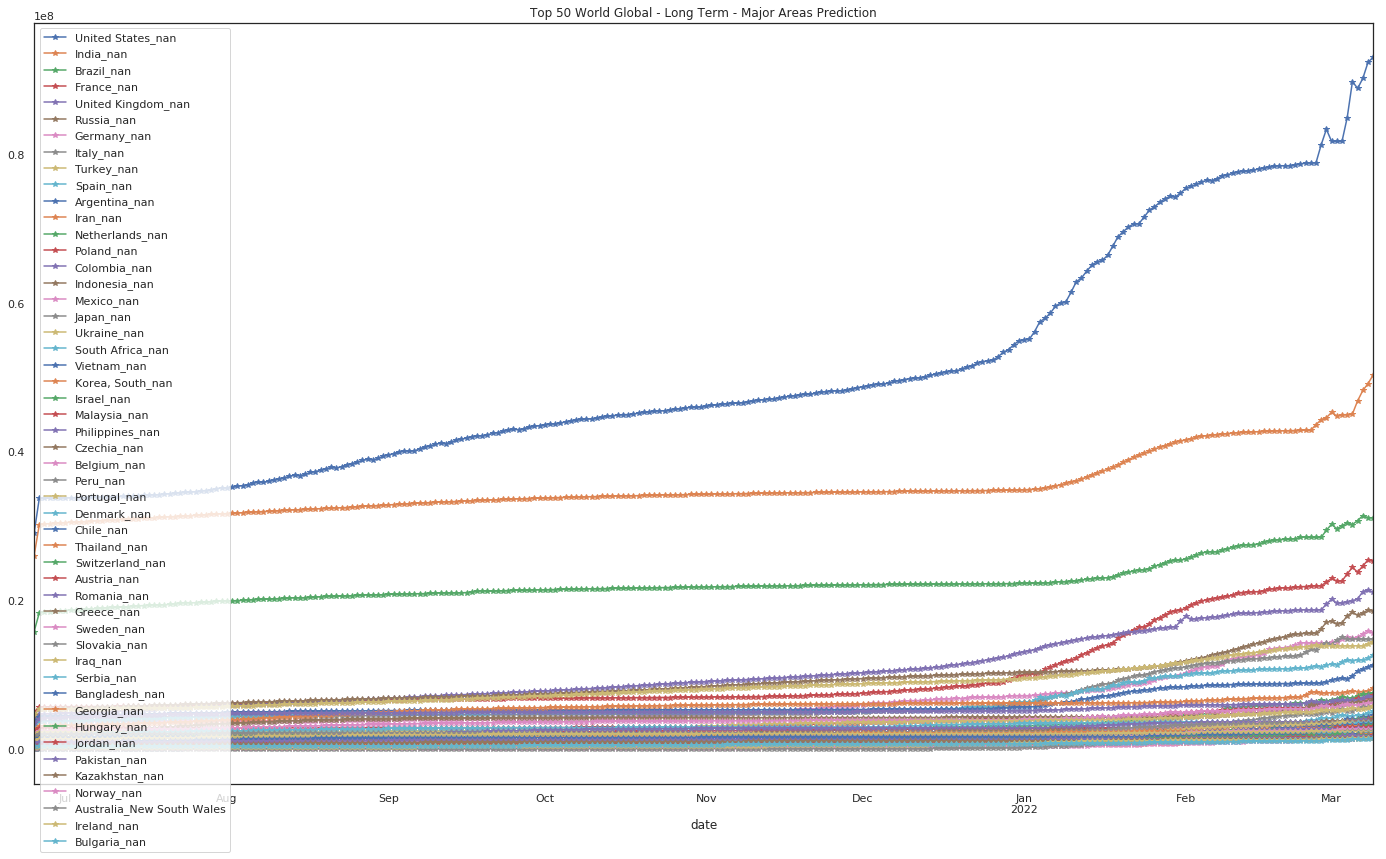

In [79]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

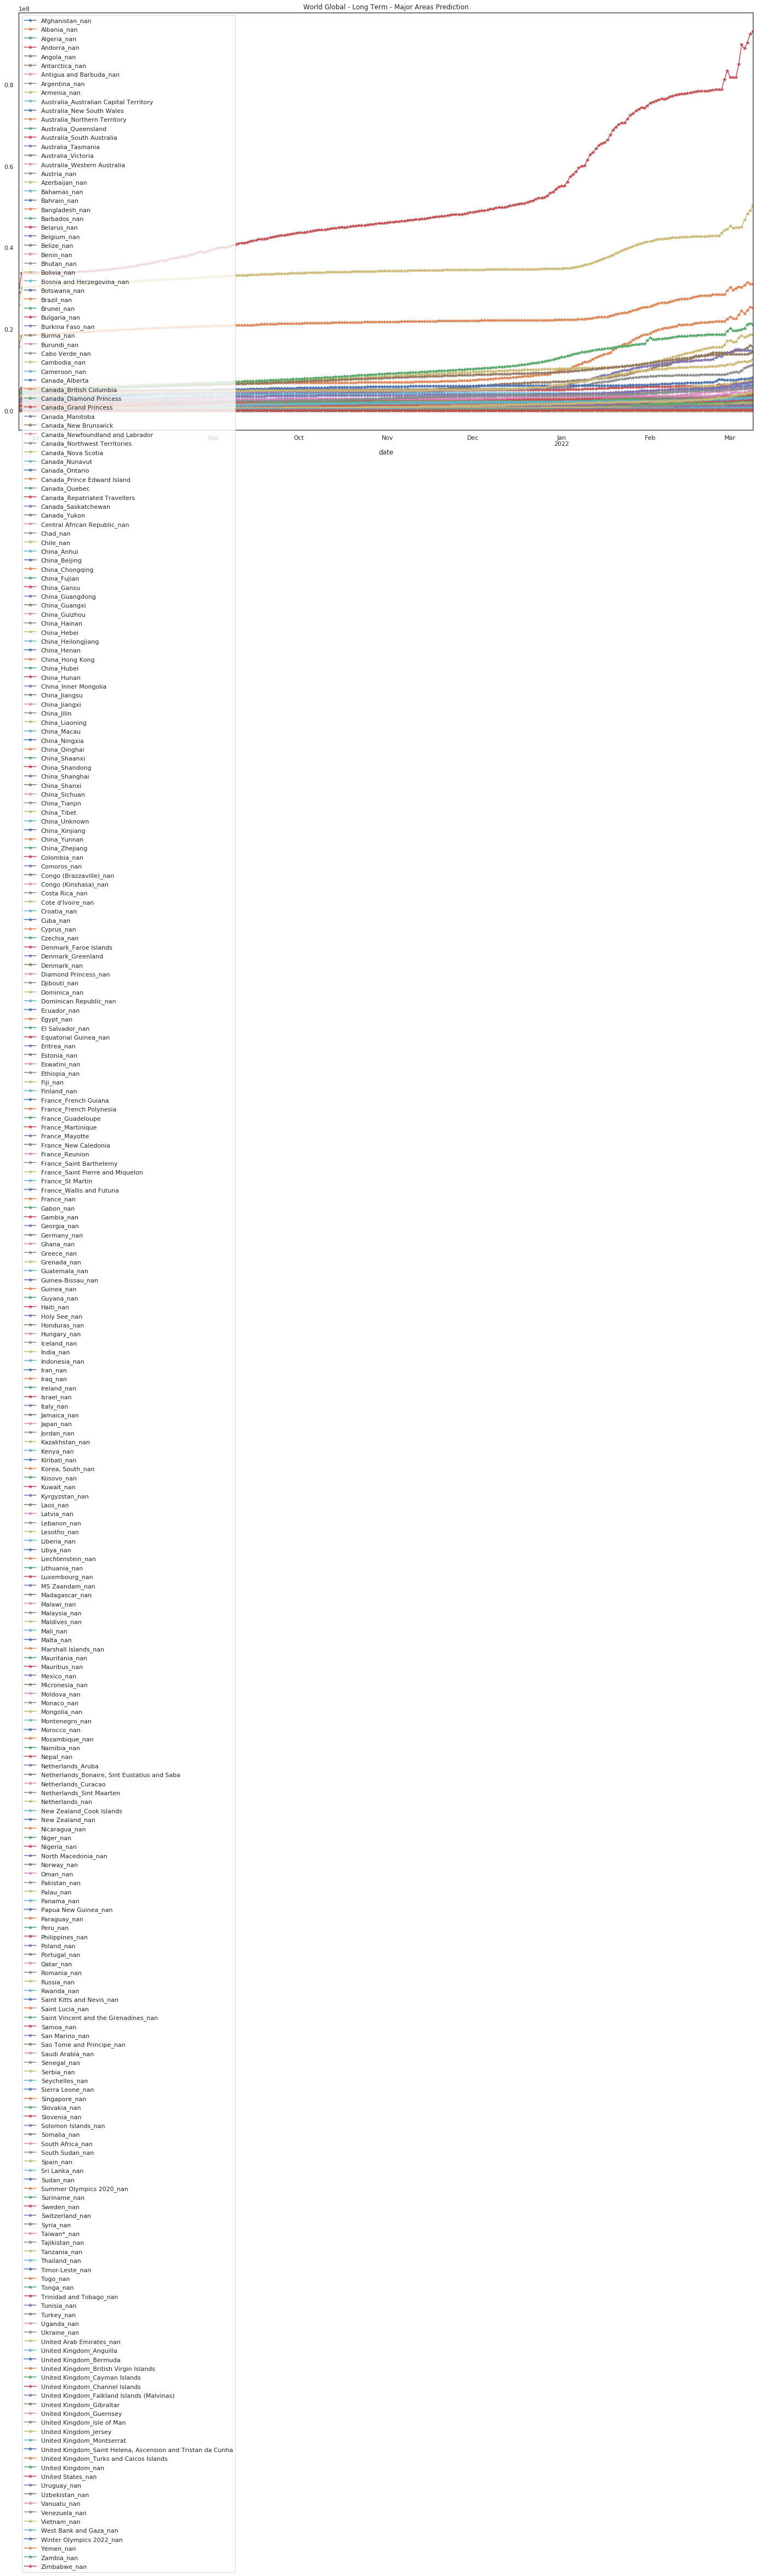

In [80]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [81]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [82]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2021-08-09         152201.0     135116.0     183584.0      14836.0   
2021-08-10         152469.0     135300.0     184575.0      14836.0   
2021-08-11         152743.0     135583.0     185452.0      14873.0   
2021-08-12         153029.0     135857.0     186305.0      14891.0   
2021-08-13         153252.0     136217.0     187188.0      14908.0   
2021-08-14         153431.0     136623.0     187977.0      14924.0   
2021-08-15         153541.0     137012.0     188596.0      14924.0   
2021-08-16         153637.0     137229.0     189274.0      14924.0   
2021-08-17         153752.0     137612.0     190011.0      14954.0   
2021-08-18         153874.0     138097.0     190741.0      14960.0   
2021-08-19         153945.0     138606.0     191455.0      14976.0   
2021-08-20         153983.0     139138.0     192052.0      14981.0   
2021-08-21         154037.0     139772.0     192561.0      14988.0   
2021-08-22         154063.0     140326.0     192981.0      14988.0   
2021-08-23         154125.0     140721.0     193453.0      14988.0   
2021-08-24         154213.0     141433.0     194020.0      15002.0   
2021-08-25         154280.0     142298.0     194582.0      15003.0   
2021-08-26         154377.0     143172.0     195107.0      15014.0   
2021-08-27         154514.0     144085.0     195618.0      15016.0   
2021-08-28         154575.0     144977.0     196113.0      15025.0   
2021-08-29         154589.0     145748.0     196596.0      15025.0   
2021-08-30         154686.0     146239.0     197016.0      15025.0   
2021-08-31         154775.0     147158.0     197491.0      15032.0   
2021-09-01         154813.0     148213.0     197974.0      15033.0   
2021-09-02         154855.0     149071.0     198360.0      15046.0   
2021-09-03         154923.0     149953.0     198743.0      15052.0   
2021-09-04         154958.0     150926.0     199106.0      15055.0   
2021-09-05         154978.0     151841.0     199446.0      15055.0   
2021-09-06         155078.0     152378.0     199767.0      15055.0   
2021-09-07         155187.0     153013.0     200090.0      15069.0   
...                     ...          ...          ...          ...   
2022-02-08         169138.0     265977.0     260328.0      36808.0   
2022-02-09         169967.0     266870.0     261001.0      36808.0   
2022-02-10         170851.0     267546.0     261572.0      36989.0   
2022-02-11         171401.0     267563.0     262105.0      37074.0   
2022-02-12         171570.0     267905.0     262644.0      37140.0   
2022-02-13         171924.0     268528.0     263173.0      37140.0   
2022-02-14         172581.0     268879.0     263600.0      37140.0   
2022-02-15         172871.0     269023.0     263969.0      37277.0   
2022-02-16         172918.0     269430.0     264399.0      37361.0   
2022-02-17         173081.0     269913.0     264796.0      37452.0   
2022-02-18         173305.0     270205.0     265111.0      37522.0   
2022-02-19         173419.0     270467.0     265361.0      37589.0   
2022-02-20         173649.0     270745.0     265487.0      37589.0   
2022-02-21         173946.0     270952.0     265603.0      37589.0   
2022-02-22         174233.0     271038.0     265789.0      37589.0   
2022-02-23         174437.0     271247.0     265938.0      37820.0   
2022-02-24         175364.0     271368.0     265959.0      37901.0   
2022-02-25         175675.0     271284.0     265935.0      37901.0   
2022-02-26         175446.0     271302.0     270443.0      37987.0   
2022-02-27         175510.0     273666.0     276894.0      37987.0   
2022-02-28         175526.0     274944.0     277182.0      37987.0   
2022-03-01         182688.0     273944.0     275455.0      37987.0   
2022-03-02         185404.0     273950.0     275374.0      38442.0   
2022-03-03         183585.0     279562.0     286291.0      38754.0   
2022-03-04

In [83]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [84]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [85]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [86]:
heatmap_m[:]

region        Lat        Long  \
0                                      Afghanistan_nan  33.939110   67.709953   
1                                          Albania_nan  41.153300   20.168300   
2                                          Algeria_nan  28.033900    1.659600   
3                                          Andorra_nan  42.506300    1.521800   
4                                           Angola_nan -11.202700   17.873900   
5                                       Antarctica_nan -71.949900   23.347000   
6                              Antigua and Barbuda_nan  17.060800  -61.796400   
7                                        Argentina_nan -38.416100  -63.616700   
8                                          Armenia_nan  40.069100   45.038200   
9               Australia_Australian Capital Territory -35.473500  149.012400   
10                           Australia_New South Wales -33.868800  151.209300   
11                        Australia_Northern Territory -12.463400  130.845600   
12                                Australia_Queensland -27.469800  153.025100   
13                           Australia_South Australia -34.928500  138.600700   
14                                  Australia_Tasmania -42.882100  147.327200   
15                                  Australia_Victoria -37.813600  144.963100   
16                         Australia_Western Australia -31.950500  115.860500   
17                                         Austria_nan  47.516200   14.550100   
18                                      Azerbaijan_nan  40.143100   47.576900   
19                                         Bahamas_nan  25.025885  -78.035889   
20                                         Bahrain_nan  26.027500   50.550000   
21                                      Bangladesh_nan  23.685000   90.356300   
22                                        Barbados_nan  13.193900  -59.543200   
23                                         Belarus_nan  53.709800   27.953400   
24                                         Belgium_nan  50.833300    4.469936   
25                                          Belize_nan  17.189900  -88.497600   
26                                           Benin_nan   9.307700    2.315800   
27                                          Bhutan_nan  27.514200   90.433600   
28                                         Bolivia_nan -16.290200  -63.588700   
29                          Bosnia and Herzegovina_nan  43.915900   17.679100   
..                                                 ...        ...         ...   
260                                        Tunisia_nan  33.886917    9.537499   
261                                         Turkey_nan  38.963700   35.243300   
262                                  United States_nan  40.000000 -100.000000   
263                                         Uganda_nan   1.373333   32.290275   
264                                        Ukraine_nan  48.379400   31.165600   
265                           United Arab Emirates_nan  23.424076   53.847818   
266                            United Kingdom_Anguilla  18.220600  -63.068600   
267                             United Kingdom_Bermuda  32.307800  -64.750500   
268              United Kingdom_British Virgin Islands  18.420700  -64.640000   
269                      United Kingdom_Cayman Islands  19.313300  -81.254600   
270                     United Kingdom_Channel Islands  49.372300   -2.364400   
271         United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
272                           United Kingdom_Gibraltar  36.140800   -5.353600   
273                            United Kingdom_Guernsey  49.448196   -2.589490   
274                         United Kingdom_Isle of Man  54.236100   -4.548100   
275                              United Kingdom_Jersey  49.213800   -2.135800   
276                          United Kingdom_Montserrat  16.742498  -62.187366   
277  United Kingdom_Saint Helena, Ascension and Tri...  -7.946700  -14.355900  

In [87]:
# Fill empty lat,long with 0
heatmap_m['Lat']=heatmap_m['Lat'].fillna(0)
heatmap_m['Long']=heatmap_m['Long'].fillna(0)
#
heatmap_m_fn="heatmap_m_"+str(num_days_R_prediction)+".csv"
heatmap_m.to_csv(r'data/'+heatmap_m_fn, index = False, header=True)

In [88]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat,lng,num,totpred,lastday7DayAvg,today7DayAvg in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]], \
                                                           (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg, \
                                                           (heatmap_m[heatmap_m.columns[ndayarray]]-heatmap_m[heatmap_m.columns[n2dayarray]])/ndaysavg):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' Current7DayAVG='+str(round(today7DayAvg))+' Predicted7DayAVG='+str(round(lastday7DayAvg))+' ConfTotPred='+str(round(totpred))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [89]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                     region        Lat        Long  \
0       7              Argentina_nan -38.416100  -63.616700   
1      10  Australia_New South Wales -33.868800  151.209300   
2      17                Austria_nan  47.516200   14.550100   
3      21             Bangladesh_nan  23.685000   90.356300   
4      24                Belgium_nan  50.833300    4.469936   
5      31                 Brazil_nan -14.235000  -51.925300   
6      33               Bulgaria_nan  42.733900   25.485800   
7      60                  Chile_nan -35.675100  -71.543000   
8      95               Colombia_nan   4.570900  -74.297300   
9     104                Czechia_nan  49.817500   15.473000   
10    107                Denmark_nan  56.263900    9.501800   
11    133                 France_nan  46.227600    2.213700   
12    136                Georgia_nan  42.315400   43.356900   
13    137                Georgia_nan  42.315400   43.356900   
14    138                Germany_nan  51.165691   10.451526   
15    140                 Greece_nan  39.074200   21.824300   
16    150                Hungary_nan  47.162500   19.503300   
17    152                  India_nan  20.593684   78.962880   
18    153              Indonesia_nan  -0.789300  113.921300   
19    154                   Iran_nan  32.427908   53.688046   
20    155                   Iraq_nan  33.223191   43.679291   
21    156                Ireland_nan  53.142400   -7.692100   
22    157                 Israel_nan  31.046051   34.851612   
23    158                 Israel_nan  31.046051   34.851612   
24    159                  Italy_nan  41.871940   12.567380   
25    161                  Japan_nan  36.204824  138.252924   
26    162                 Jordan_nan  31.240000   36.510000   
27    163             Kazakhstan_nan  48.019600   66.923700   
28    166           Korea, South_nan  35.907757  127.766922   
29    183               Malaysia_nan   4.210484  101.975766   
30    190                 Mexico_nan  23.634500 -102.552800   
31    204            Netherlands_nan  52.132600    5.291300   
32    211                 Norway_nan  60.472000    8.468900   
33    213               Pakistan_nan  30.375300   69.345100   
34    218                   Peru_nan  -9.190000  -75.015200   
35    219            Philippines_nan  12.879721  121.774017   
36    220                 Poland_nan  51.919400   19.145100   
37    221               Portugal_nan  39.399900   -8.224500   
38    223                Romania_nan  45.943200   24.966800   
39    224                 Russia_nan  61.524010  105.318756   
40    234                 Serbia_nan  44.016500   21.005900   
41    238               Slovakia_nan  48.669000   19.699000   
42    242           South Africa_nan -30.559500   22.937500   
43    244                  Spain_nan  40.463667   -3.749220   
44    249                 Sweden_nan  60.128161   18.643501   
45    250            Switzerland_nan  46.818200    8.227500   
46    255               Thailand_nan  15.870032  100.992541   
47    261                 Turkey_nan  38.963700   35.243300   
48    262          United States_nan  40.000000 -100.000000   
49    264                Ukraine_nan  48.379400   31.165600   
50    279         United Kingdom_nan  55.378100   -3.436000   
51    284                Vietnam_nan  14.058324  108.277199   

    2021-06-25 00:00:00  2021-06-26 00:00:00  2021-06-27 00:00:00  \
0             3826571.0            4374587.0            4409369.0   
1               75383.0              75409.0               5756.0   
2              628583.0             650016.0             650192.0   
3              825025.0             878804.0             886507.0   
4              999902.0            1082476.0            1082476.0   
5            15811096.0           18332493.0           18448579.0   
6              432364.0             432388.0             421515.0   
7             1390569.0            1537471.0            1544977.0   
8             3584577.0            4092746.

In [90]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
backday=num_BackTrack_Days
ndayarray=-1-backday-num_days_R_prediction
n2dayarray=-1-backday-(num_days_R_prediction*2)

for lat2,lng2,num2,totpred2,lastday7DayAvg2,today7DayAvg2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], \
                                                                (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg, \
                                                                (heatmap_m2[heatmap_m2.columns[ndayarray]]-heatmap_m2[heatmap_m2.columns[n2dayarray]])/ndaysavg):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' Current7DayAvg='+str(round(today7DayAvg2))+' Predicted7DayAvg='+str(round(lastday7DayAvg2))+' ConfTotPred='+str(round(totpred2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [91]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [92]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [93]:
exit()